# set up environment

nvidia-smi

In [1]:
# run on hssm_test
# Basics
import os
import sys
import time
from matplotlib import pyplot as plt
import arviz as az  # Visualization
import numpy as np
import pandas as pd
import pathlib
import seaborn
from pathlib import Path 
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from patsy import dmatrix
from ssms.basic_simulators.simulator import simulator
import bambi as bmb
from pandas.api.types import CategoricalDtype
import ssms
import pytensor  # Graph-based tensor library
import hssm
import random
import math
# Set float type to float32 to avoid a current bug in PyMC 
# This will not be necessary in the future
hssm.set_floatX("float32")

Setting PyTensor floatX type to float32.
Setting "jax_enable_x64" to False. If this is not intended, please set `jax` to False.


# set up paths

In [2]:
basepath = '/users/afengler/data/proj_tt/mpib-HSSM-oddball-data'

# Check whether save directories exist; if not, create them
pathlib.Path(basepath+'/models/hssm/').mkdir(parents=True, exist_ok=True)
pathlib.Path(basepath+'/results/hssm/').mkdir(parents=True, exist_ok=True)
pathlib.Path(basepath+'/plots/hssm/').mkdir(parents=True, exist_ok=True)
pathlib.Path(basepath+'/ppc/hssm/').mkdir(parents=True, exist_ok=True)

# set up data

## response as accuracy

In [3]:
df = pd.read_csv(basepath+'/data/OB_singletrial_YAOA.csv')

df['response'] = df['accuracy']
# And then modify the 'response' column where the condition is met
df.loc[df['response'] == 0, 'response'] = -1

df.rename(columns={'reactiontime': 'rt'}, inplace=True)
df.rename(columns={'id': 'participant_id'}, inplace=True)

oddballDataDay2 = df[df['response'].notna()]

data=oddballDataDay2[:]
dataForModel = data[data['pupil'].notna()]

dataForModel = dataForModel.copy()
dataForModel = dataForModel[dataForModel['beta_insula'].notna()]

dataForModel = dataForModel.copy()
dataForModel = dataForModel[dataForModel['switch_condition_num'].notna()]


dataForModel['switch_condition_num']=isinstance(dataForModel['switch_condition_num'].dtype, CategoricalDtype)

## response as choices

In [3]:
df2 = pd.read_csv(basepath+'/data/OB_singletrial_YAOA.csv')
df2['switch_condition_num']

#dataForModel["trl_condition_bin"] (1==standard, 2==oddball)
#dataForModel["trl_condition"] (1==standard, 2==oddball1,3==oddball2)
choice1=pd.Series([np.nan]*len(df2["trl_condition"]))
for i in range(len(df2["trl_condition"])): 
    if df2["accuracy"].iloc[i] == 1:
        choice1[i]=int(df2["trl_condition"].iloc[i]-1)
    elif df2["accuracy"].iloc[i] == 0 and df2["trl_condition_bin"].iloc[i] == 2:   
        choice1[i]=0
    elif df2["accuracy"].iloc[i] == 0 and df2["trl_condition_bin"].iloc[i] == 1: 
        choice1[i]=random.randint(1, 2)
    
df2['response']=choice1    
df2.rename(columns={'reactiontime': 'rt'}, inplace=True)
df2.rename(columns={'id': 'participant_id'}, inplace=True)

In [4]:
df2

id_runningnum  participant_id  agegrp    toi1    toi2  offset  \
0                  1           42013       1   48306   50806   -1250   
1                  1           42013       1   52293   54793   -1250   
2                  1           42013       1   54293   56793   -1250   
3                  1           42013       1   57293   59793   -1250   
4                  1           42013       1   59293   61793   -1250   
...              ...             ...     ...     ...     ...     ...   
11284             77           62433       2  463649  466149   -1250   
11285             77           62433       2  465649  468149   -1250   
11286             77           62433       2  470649  473149   -1250   
11287             77           62433       2  472649  475149   -1250   
11288             77           62433       2  475649  478149   -1250   

       trl_runningnum  event  trigger  artfree  ...  beta_insula   beta_LC  \
0                   1     70       16        1  ...    -0.010940 -0.997148   
1                   2     74       16        1  ...    -0.065556 -0.771706   
2                   3     78       16        1  ...     0.509185 -0.017799   
3                   4     82       16        1  ...     1.049503 -0.247686   
4                   5     86       16        1  ...    -0.611262  0.441441   
...               ...    ...      ...      ...  ...          ...       ...   
11284             155    657       16        1  ...    -0.901538 -1.274403   
11285             156    661       16        1  ...     0.026958 -0.852999   
11286             157    665       16        1  ...    -0.940993  1.145411   
11287             158    669       16        1  ...    -0.779456  1.448574   
11288             159    673       16        1  ...    -0.750940  0.867637   

          pupil       LCr  trl_condition_bin    switch_condition  \
0      2.175158  0.985568                  1                 NaN   
1     -0.275299  0.985568                  1       stay_standard   
2      1.874566  0.985568                  2   switch_to_oddball   
3     -0.516399  0.985568                  2        stay_oddball   
4      0.710667  0.985568                  1  switch_to_standard   
...         ...       ...                ...                 ...   
11284  0.761824  0.386572                  1       stay_standard   
11285 -0.115871  0.386572                  1       stay_standard   
11286  1.098559  0.386572                  2   switch_to_oddball   
11287 -0.044915  0.386572                  1  switch_to_standard   
11288  0.324306  0.386572                  1       stay_standard   

       switch_condition_num  logreactiontime logreactiontimez  response  
0                       NaN         0.210081         1.375260       0.0  
1                       1.0        -0.174549        -0.033526       0.0  
2                       3.0         0.289645         1.666682       2.0  
3                       2.0         0.296416         1.691481       1.0  
4                       4.0        -0.418396        -0.926666       0.0  
...                     ...              ...              ...       ...  
11284                   1.0        -0.137351        -0.110256       0.0  
11285                   1.0        -0.197492        -0.575755       0.0  
11286                   3.0         0.066526         1.467764       1.0  
11287                   4.0        -0.082262         0.316131       0.0  
11288                   1.0        -0.133665        -0.081732       0.0  

[11289 rows x 23 columns]

In [5]:
oddballDataDay2Choice = df2[df2['response'].notna()]

In [6]:
oddballDataDay2Choice

id_runningnum  participant_id  agegrp    toi1    toi2  offset  \
0                  1           42013       1   48306   50806   -1250   
1                  1           42013       1   52293   54793   -1250   
2                  1           42013       1   54293   56793   -1250   
3                  1           42013       1   57293   59793   -1250   
4                  1           42013       1   59293   61793   -1250   
...              ...             ...     ...     ...     ...     ...   
11284             77           62433       2  463649  466149   -1250   
11285             77           62433       2  465649  468149   -1250   
11286             77           62433       2  470649  473149   -1250   
11287             77           62433       2  472649  475149   -1250   
11288             77           62433       2  475649  478149   -1250   

       trl_runningnum  event  trigger  artfree  ...  beta_insula   beta_LC  \
0                   1     70       16        1  ...    -0.010940 -0.997148   
1                   2     74       16        1  ...    -0.065556 -0.771706   
2                   3     78       16        1  ...     0.509185 -0.017799   
3                   4     82       16        1  ...     1.049503 -0.247686   
4                   5     86       16        1  ...    -0.611262  0.441441   
...               ...    ...      ...      ...  ...          ...       ...   
11284             155    657       16        1  ...    -0.901538 -1.274403   
11285             156    661       16        1  ...     0.026958 -0.852999   
11286             157    665       16        1  ...    -0.940993  1.145411   
11287             158    669       16        1  ...    -0.779456  1.448574   
11288             159    673       16        1  ...    -0.750940  0.867637   

          pupil       LCr  trl_condition_bin    switch_condition  \
0      2.175158  0.985568                  1                 NaN   
1     -0.275299  0.985568                  1       stay_standard   
2      1.874566  0.985568                  2   switch_to_oddball   
3     -0.516399  0.985568                  2        stay_oddball   
4      0.710667  0.985568                  1  switch_to_standard   
...         ...       ...                ...                 ...   
11284  0.761824  0.386572                  1       stay_standard   
11285 -0.115871  0.386572                  1       stay_standard   
11286  1.098559  0.386572                  2   switch_to_oddball   
11287 -0.044915  0.386572                  1  switch_to_standard   
11288  0.324306  0.386572                  1       stay_standard   

       switch_condition_num  logreactiontime logreactiontimez  response  
0                       NaN         0.210081         1.375260       0.0  
1                       1.0        -0.174549        -0.033526       0.0  
2                       3.0         0.289645         1.666682       2.0  
3                       2.0         0.296416         1.691481       1.0  
4                       4.0        -0.418396        -0.926666       0.0  
...                     ...              ...              ...       ...  
11284                   1.0        -0.137351        -0.110256       0.0  
11285                   1.0        -0.197492        -0.575755       0.0  
11286                   3.0         0.066526         1.467764       1.0  
11287                   4.0        -0.082262         0.316131       0.0  
11288                   1.0        -0.133665        -0.081732       0.0  

[11227 rows x 23 columns]

In [7]:
oddballDataDay2Choice['response'].unique()

array([0., 2., 1.])

In [8]:
oddballDataDay2Choice = oddballDataDay2Choice.copy()
oddballDataDay2Choice = oddballDataDay2Choice[oddballDataDay2Choice['switch_condition_num'].notna()]

oddballDataDay2Choice = oddballDataDay2Choice.reset_index(drop=True)

In [9]:
oddballDataDay2Choice

id_runningnum  participant_id  agegrp    toi1    toi2  offset  \
0                  1           42013       1   52293   54793   -1250   
1                  1           42013       1   54293   56793   -1250   
2                  1           42013       1   57293   59793   -1250   
3                  1           42013       1   59293   61793   -1250   
4                  1           42013       1   61293   63793   -1250   
...              ...             ...     ...     ...     ...     ...   
11159             77           62433       2  463649  466149   -1250   
11160             77           62433       2  465649  468149   -1250   
11161             77           62433       2  470649  473149   -1250   
11162             77           62433       2  472649  475149   -1250   
11163             77           62433       2  475649  478149   -1250   

       trl_runningnum  event  trigger  artfree  ...  beta_insula   beta_LC  \
0                   2     74       16        1  ...    -0.065556 -0.771706   
1                   3     78       16        1  ...     0.509185 -0.017799   
2                   4     82       16        1  ...     1.049503 -0.247686   
3                   5     86       16        1  ...    -0.611262  0.441441   
4                   6     90       16        1  ...    -0.546911  1.490605   
...               ...    ...      ...      ...  ...          ...       ...   
11159             155    657       16        1  ...    -0.901538 -1.274403   
11160             156    661       16        1  ...     0.026958 -0.852999   
11161             157    665       16        1  ...    -0.940993  1.145411   
11162             158    669       16        1  ...    -0.779456  1.448574   
11163             159    673       16        1  ...    -0.750940  0.867637   

          pupil       LCr  trl_condition_bin    switch_condition  \
0     -0.275299  0.985568                  1       stay_standard   
1      1.874566  0.985568                  2   switch_to_oddball   
2     -0.516399  0.985568                  2        stay_oddball   
3      0.710667  0.985568                  1  switch_to_standard   
4      0.795430  0.985568                  1       stay_standard   
...         ...       ...                ...                 ...   
11159  0.761824  0.386572                  1       stay_standard   
11160 -0.115871  0.386572                  1       stay_standard   
11161  1.098559  0.386572                  2   switch_to_oddball   
11162 -0.044915  0.386572                  1  switch_to_standard   
11163  0.324306  0.386572                  1       stay_standard   

       switch_condition_num  logreactiontime logreactiontimez  response  
0                       1.0        -0.174549        -0.033526       0.0  
1                       3.0         0.289645         1.666682       2.0  
2                       2.0         0.296416         1.691481       1.0  
3                       4.0        -0.418396        -0.926666       0.0  
4                       1.0        -0.238042        -0.266080       0.0  
...                     ...              ...              ...       ...  
11159                   1.0        -0.137351        -0.110256       0.0  
11160                   1.0        -0.197492        -0.575755       0.0  
11161                   3.0         0.066526         1.467764       1.0  
11162                   4.0        -0.082262         0.316131       0.0  
11163                   1.0        -0.133665        -0.081732       0.0  

[11164 rows x 23 columns]

## first look at real data RT

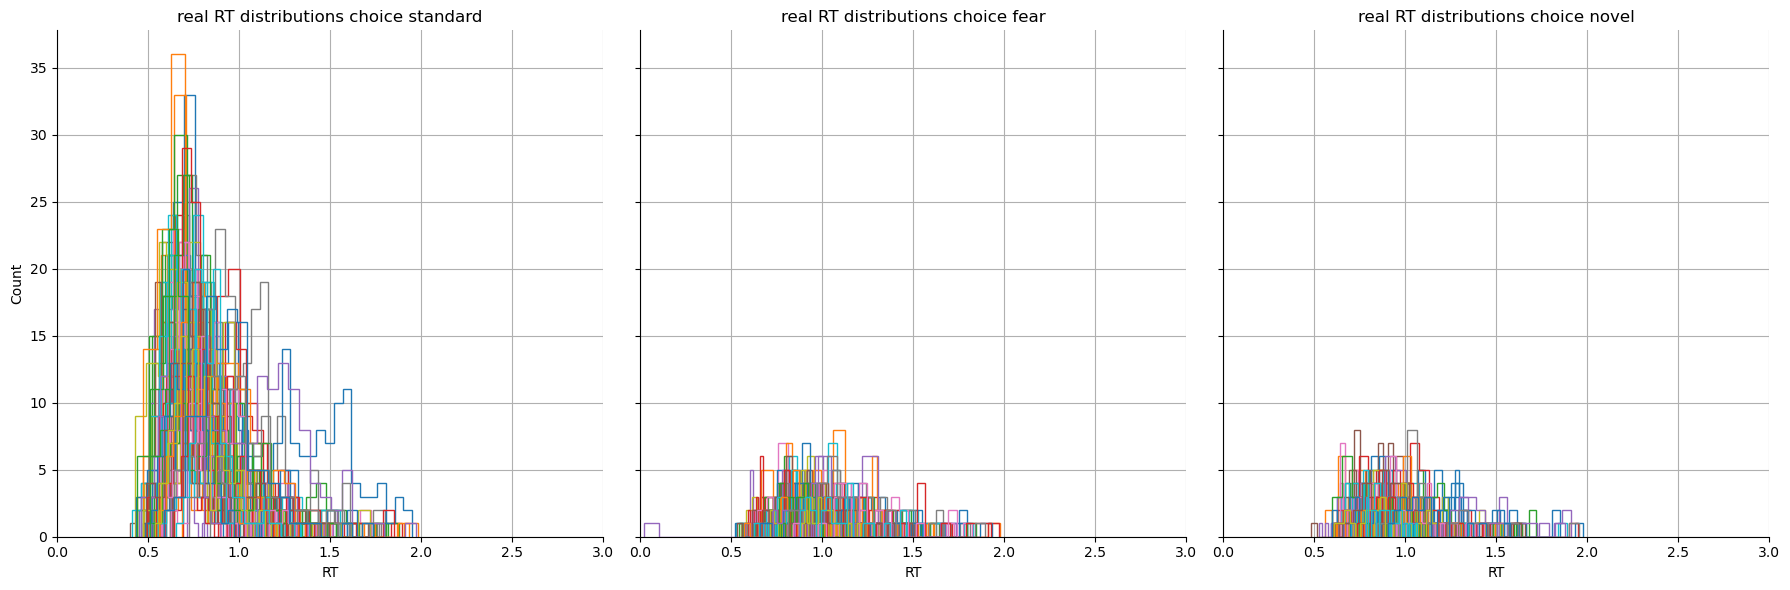

In [10]:
oddballDataDay2Choice['rtPlot']=oddballDataDay2Choice['rt']

# Filter data for each response type
dataResponse0 = oddballDataDay2Choice.loc[oddballDataDay2Choice['response'] == 0]
dataResponse1 = oddballDataDay2Choice.loc[oddballDataDay2Choice['response'] == 1]
dataResponse2 = oddballDataDay2Choice.loc[oddballDataDay2Choice['response'] == 2]

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot for response == 0
for i, subj_data in dataResponse0.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[0])
axes[0].set_title('real RT distributions choice standard')
axes[0].set_xlabel('RT')
axes[0].set_ylabel('Count')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].set_xlim(0, 3)

# Plot for response == 1
for i, subj_data in dataResponse1.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[1])
axes[1].set_title('real RT distributions choice fear')
axes[1].set_xlabel('RT')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].set_xlim(0, 3)

# Plot for response == 2
for i, subj_data in dataResponse2.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[2])
axes[2].set_title('real RT distributions choice novel')
axes[2].set_xlabel('RT')
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)
axes[2].set_xlim(0, 3)

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig(basepath + '/figures/rea_subRT_dist_all_choices.pdf')


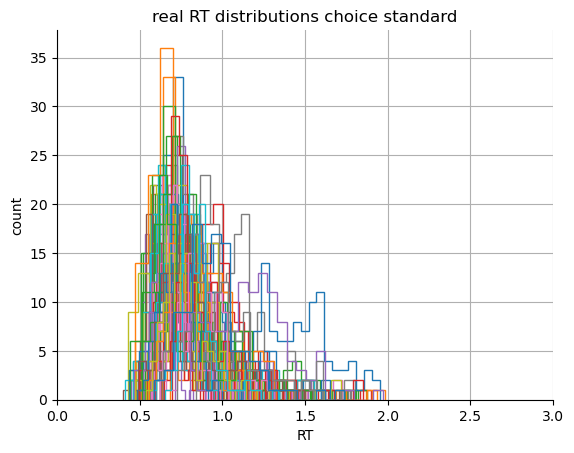

In [11]:
oddballDataDay2Choice['rtPlot']=oddballDataDay2Choice['rt']
dataStandardChoice=oddballDataDay2Choice.loc[oddballDataDay2Choice['response'] == 0]
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='real RT distributions choice standard')
for i, subj_data in dataStandardChoice.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=ax)

plt.xlim(0,3)   
ax = plt.gca()

# Remove the top and right spines (the outer box)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig(basepath + '/figures/real_subRT_dist_choice_standard.pdf')

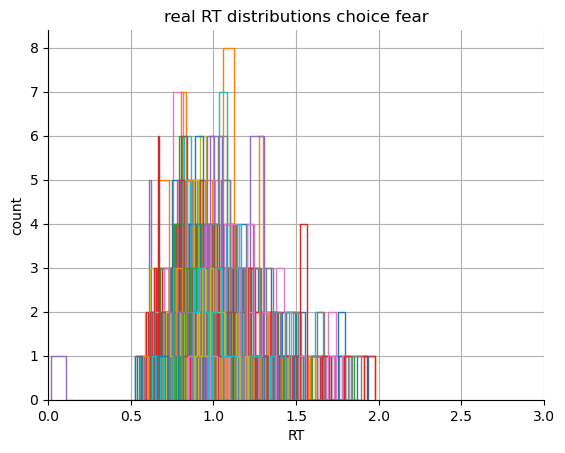

In [31]:
oddballDataDay2Choice['rtPlot']=oddballDataDay2Choice['rt']
dataFearChoice=oddballDataDay2Choice.loc[oddballDataDay2Choice['response'] == 1]
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='real RT distributions choice fear')
for i, subj_data in dataFearChoice.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=ax)

plt.xlim(0,3) 
ax = plt.gca()

# Remove the top and right spines (the outer box)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig(basepath + '/figures/real_subRT_dist_choice_fear.pdf')

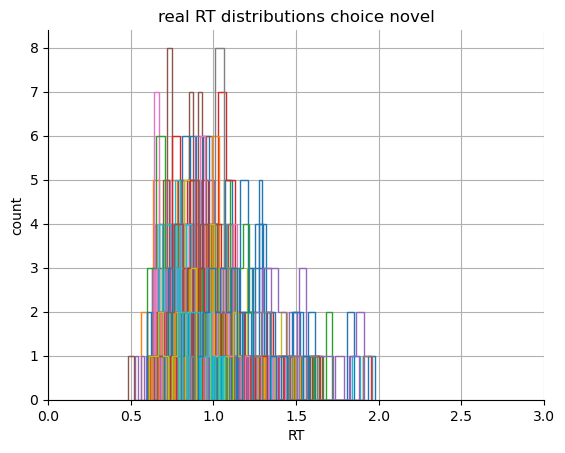

In [30]:
oddballDataDay2Choice['rtPlot']=oddballDataDay2Choice['rt']
dataNovelChoice=oddballDataDay2Choice.loc[oddballDataDay2Choice['response'] == 2]
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='real RT distributions choice novel')
for i, subj_data in dataNovelChoice.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=ax)

plt.xlim(0,3)   
ax = plt.gca()

# Remove the top and right spines (the outer box)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig(basepath + '/figures/real_subRT_dist_choice_novel.pdf')

## day2SubList

In [12]:
# based on the real data, we figure:
# we need to simulate data with 'participant_id','rt',and 'response' 
# we need to get the correct sub numbers out and also correct trial number (samples in simulation) per subject
day2SubList=oddballDataDay2Choice['participant_id'].unique()
len(day2SubList)


71

# set up sampler for real data

In [ ]:
simple_LBA_model_hier_all_noPrior = hssm.HSSM(
    data=oddballDataDay2Choice,
    model="lba3",
    choices = [0,1,2],
    hierarchical=True,
    noncentered=False,
    loglik_kind="analytical")


In [ ]:
pathlib.Path(basepath+'/models/lba/sept24/numpyro/').mkdir(parents=True, exist_ok=True)

inferenceData_simple_LBA_model_hier_all_noPrior=simple_LBA_model_hier_all_noPrior.sample(
    sampler="nuts_numpyro",
    chains=4,
    cores=1,
    draws=3000,
    tune=1000,
    discard_tuned_samples=False,
    idata_kwargs=dict(log_likelihood=False),)

fileName = basepath + '/models/lba/sept24/numpyro/inferenceData_simple_LBA_model_hier_all_noPrior.nc'
data = inferenceData_simple_LBA_model_hier_all_noPrior
az.to_netcdf(data, fileName)


Using default initvals. 

The model has already been sampled. Overwriting the previous inference object. Any previous reference to the inference object will still point to the old object.


/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/pymc/sampling/jax.py:451: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:69: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/users/afengler/data/software/minico

'/users/afengler/data/proj_tt/mpib-HSSM-oddball-data/models/lba/sept24/numpyro/inferenceData_simple_LBA_model_hier_all_noPrior.nc'

In [13]:
fileName = basepath + '/models/lba/sept24/numpyro/inferenceData_simple_LBA_model_hier_all_noPrior.nc'
LBA3_inferenceData=az.from_netcdf(fileName)

In [14]:
az.summary(LBA3_inferenceData,var_names=['v0_Intercept',
                                         'v1_Intercept',
                                         'v2_Intercept',
                                         'A_Intercept',
                                         'b_Intercept'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
v0_Intercept  0.501  0.017   0.477    0.534      0.007    0.005       6.0   
v1_Intercept  0.349  0.015   0.327    0.380      0.007    0.005       5.0   
v2_Intercept  0.358  0.011   0.338    0.378      0.004    0.003       8.0   
A_Intercept   0.137  0.020   0.104    0.175      0.009    0.007       5.0   
b_Intercept   0.498  0.032   0.446    0.546      0.015    0.011       5.0   

              ess_tail  r_hat  
v0_Intercept      11.0   1.82  
v1_Intercept      12.0   2.02  
v2_Intercept      16.0   1.41  
A_Intercept       13.0   2.37  
b_Intercept       21.0   2.36

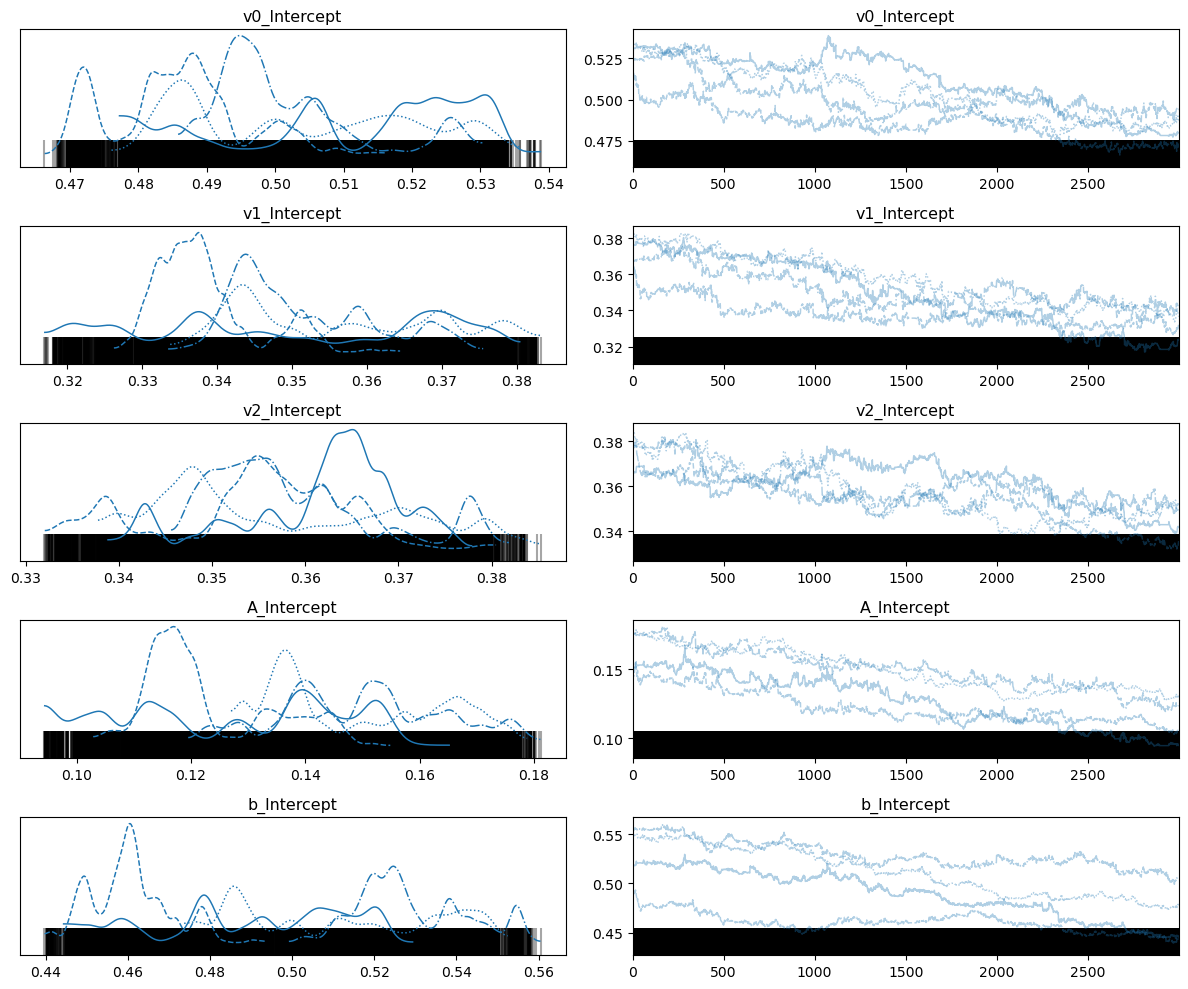

In [ ]:
az.plot_trace(
    inferenceData_simple_LBA_model_hier_all_noPrior,var_names=['v0_Intercept','v1_Intercept',
                                                               'v2_Intercept', 'A_Intercept',
                                                               'b_Intercept']
)
plt.tight_layout()

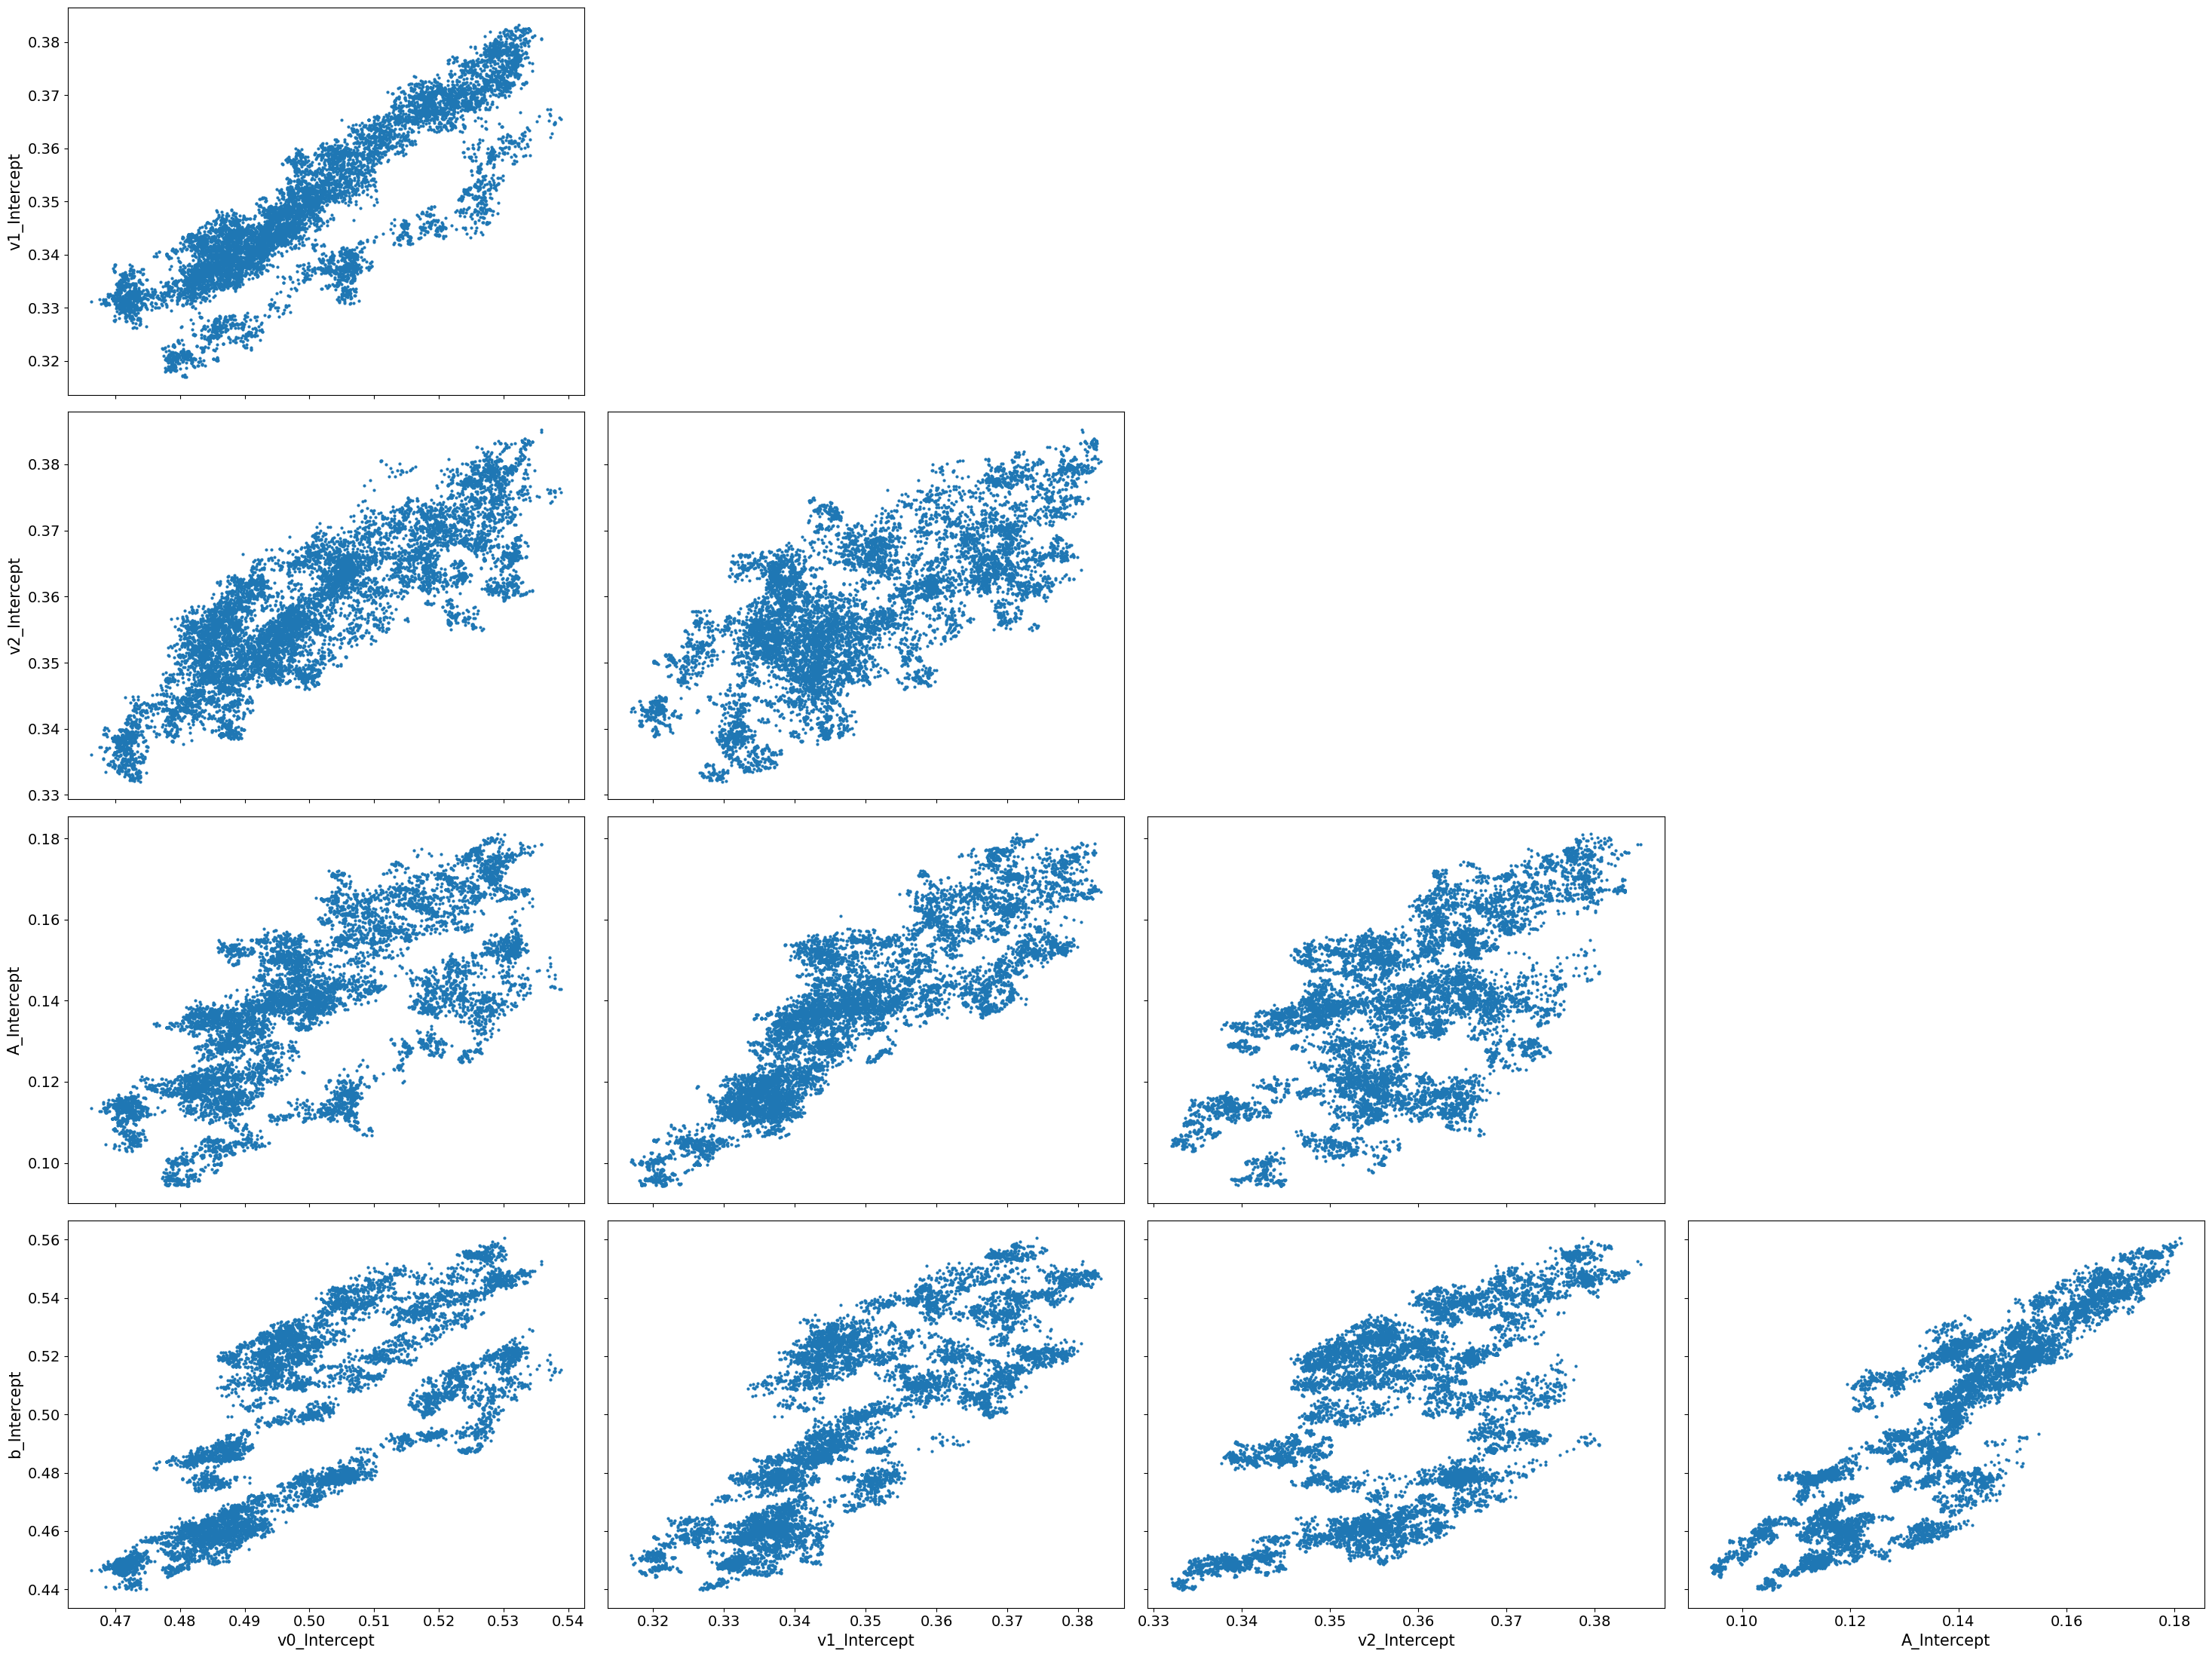

In [ ]:
az.plot_pair(
    inferenceData_simple_LBA_model_hier_all_noPrior,var_names=['v0_Intercept','v1_Intercept',
                                                               'v2_Intercept', 'A_Intercept',
                                                               'b_Intercept']
)
plt.tight_layout()

## check results from hier model drift rate depends on trial type

In [15]:
fileName = basepath + '/models/lba/sept24/numpyro/inferenceData_simple_LBA_model_trialDepend_hier_.nc'
LBA3_inferenceData=az.from_netcdf(fileName)
LBA3_inferenceData

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [14]:
az.summary(LBA3_inferenceData,var_names=['v0_Intercept',
                                         'v1_Intercept',
                                         'v2_Intercept',
                                         'A_Intercept',
                                         'b_Intercept'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
v0_Intercept  0.431  0.050   0.359    0.475      0.034    0.028       2.0   
v1_Intercept  0.443  0.031   0.406    0.473      0.022    0.018       2.0   
v2_Intercept  0.129  0.019   0.110    0.150      0.013    0.011       2.0   
A_Intercept   0.241  0.046   0.195    0.288      0.033    0.028       3.0   
b_Intercept   0.246  0.008   0.239    0.254      0.006    0.005       2.0   

              ess_tail  r_hat  
v0_Intercept      11.0   3.68  
v1_Intercept      11.0   3.64  
v2_Intercept       2.0   3.30  
A_Intercept        2.0   2.24  
b_Intercept       24.0   3.61

/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or n

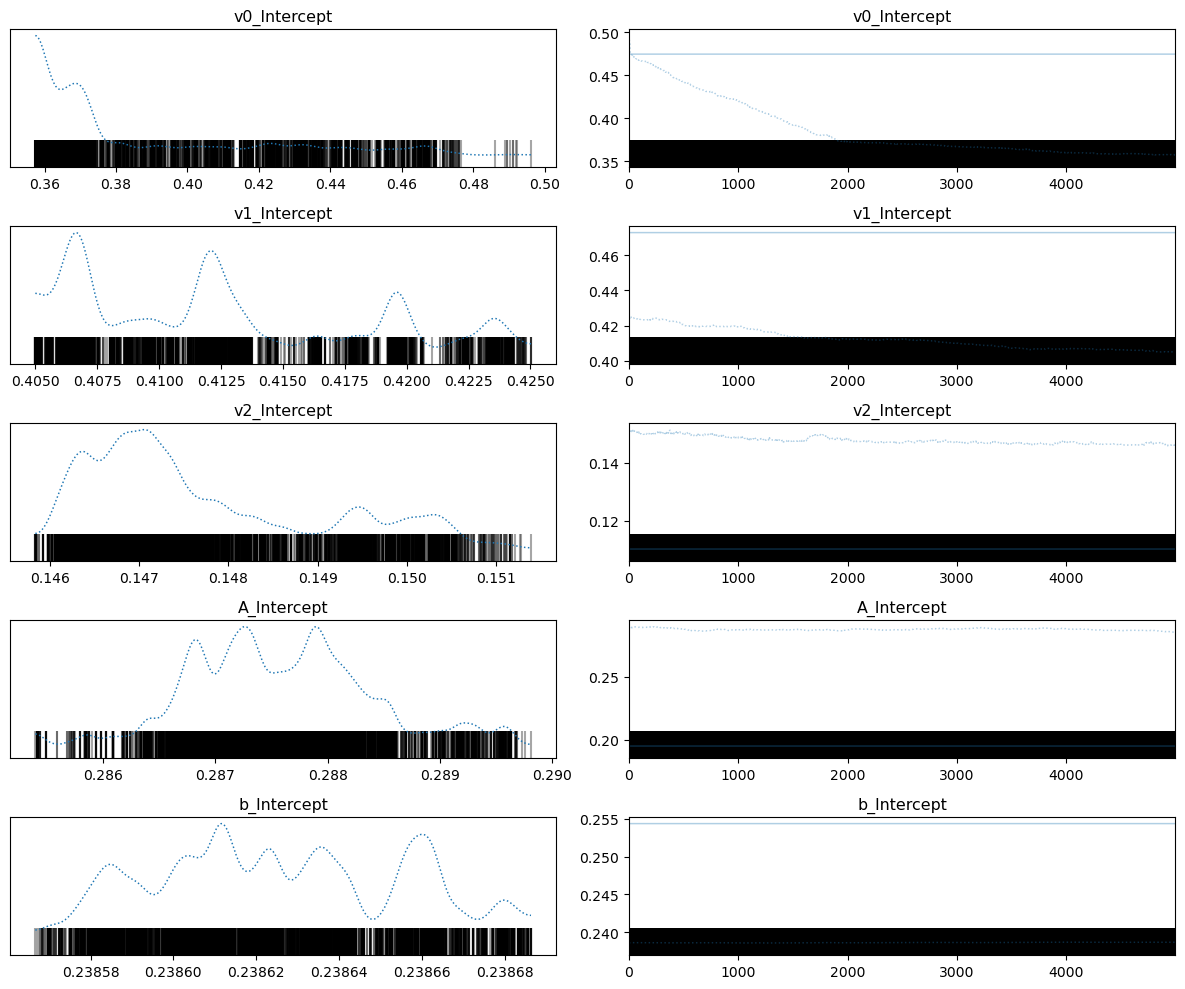

In [16]:
az.plot_trace(
    LBA3_inferenceData,var_names=['v0_Intercept','v1_Intercept',
                                                               'v2_Intercept', 'A_Intercept',
                                                               'b_Intercept']
)
plt.tight_layout()

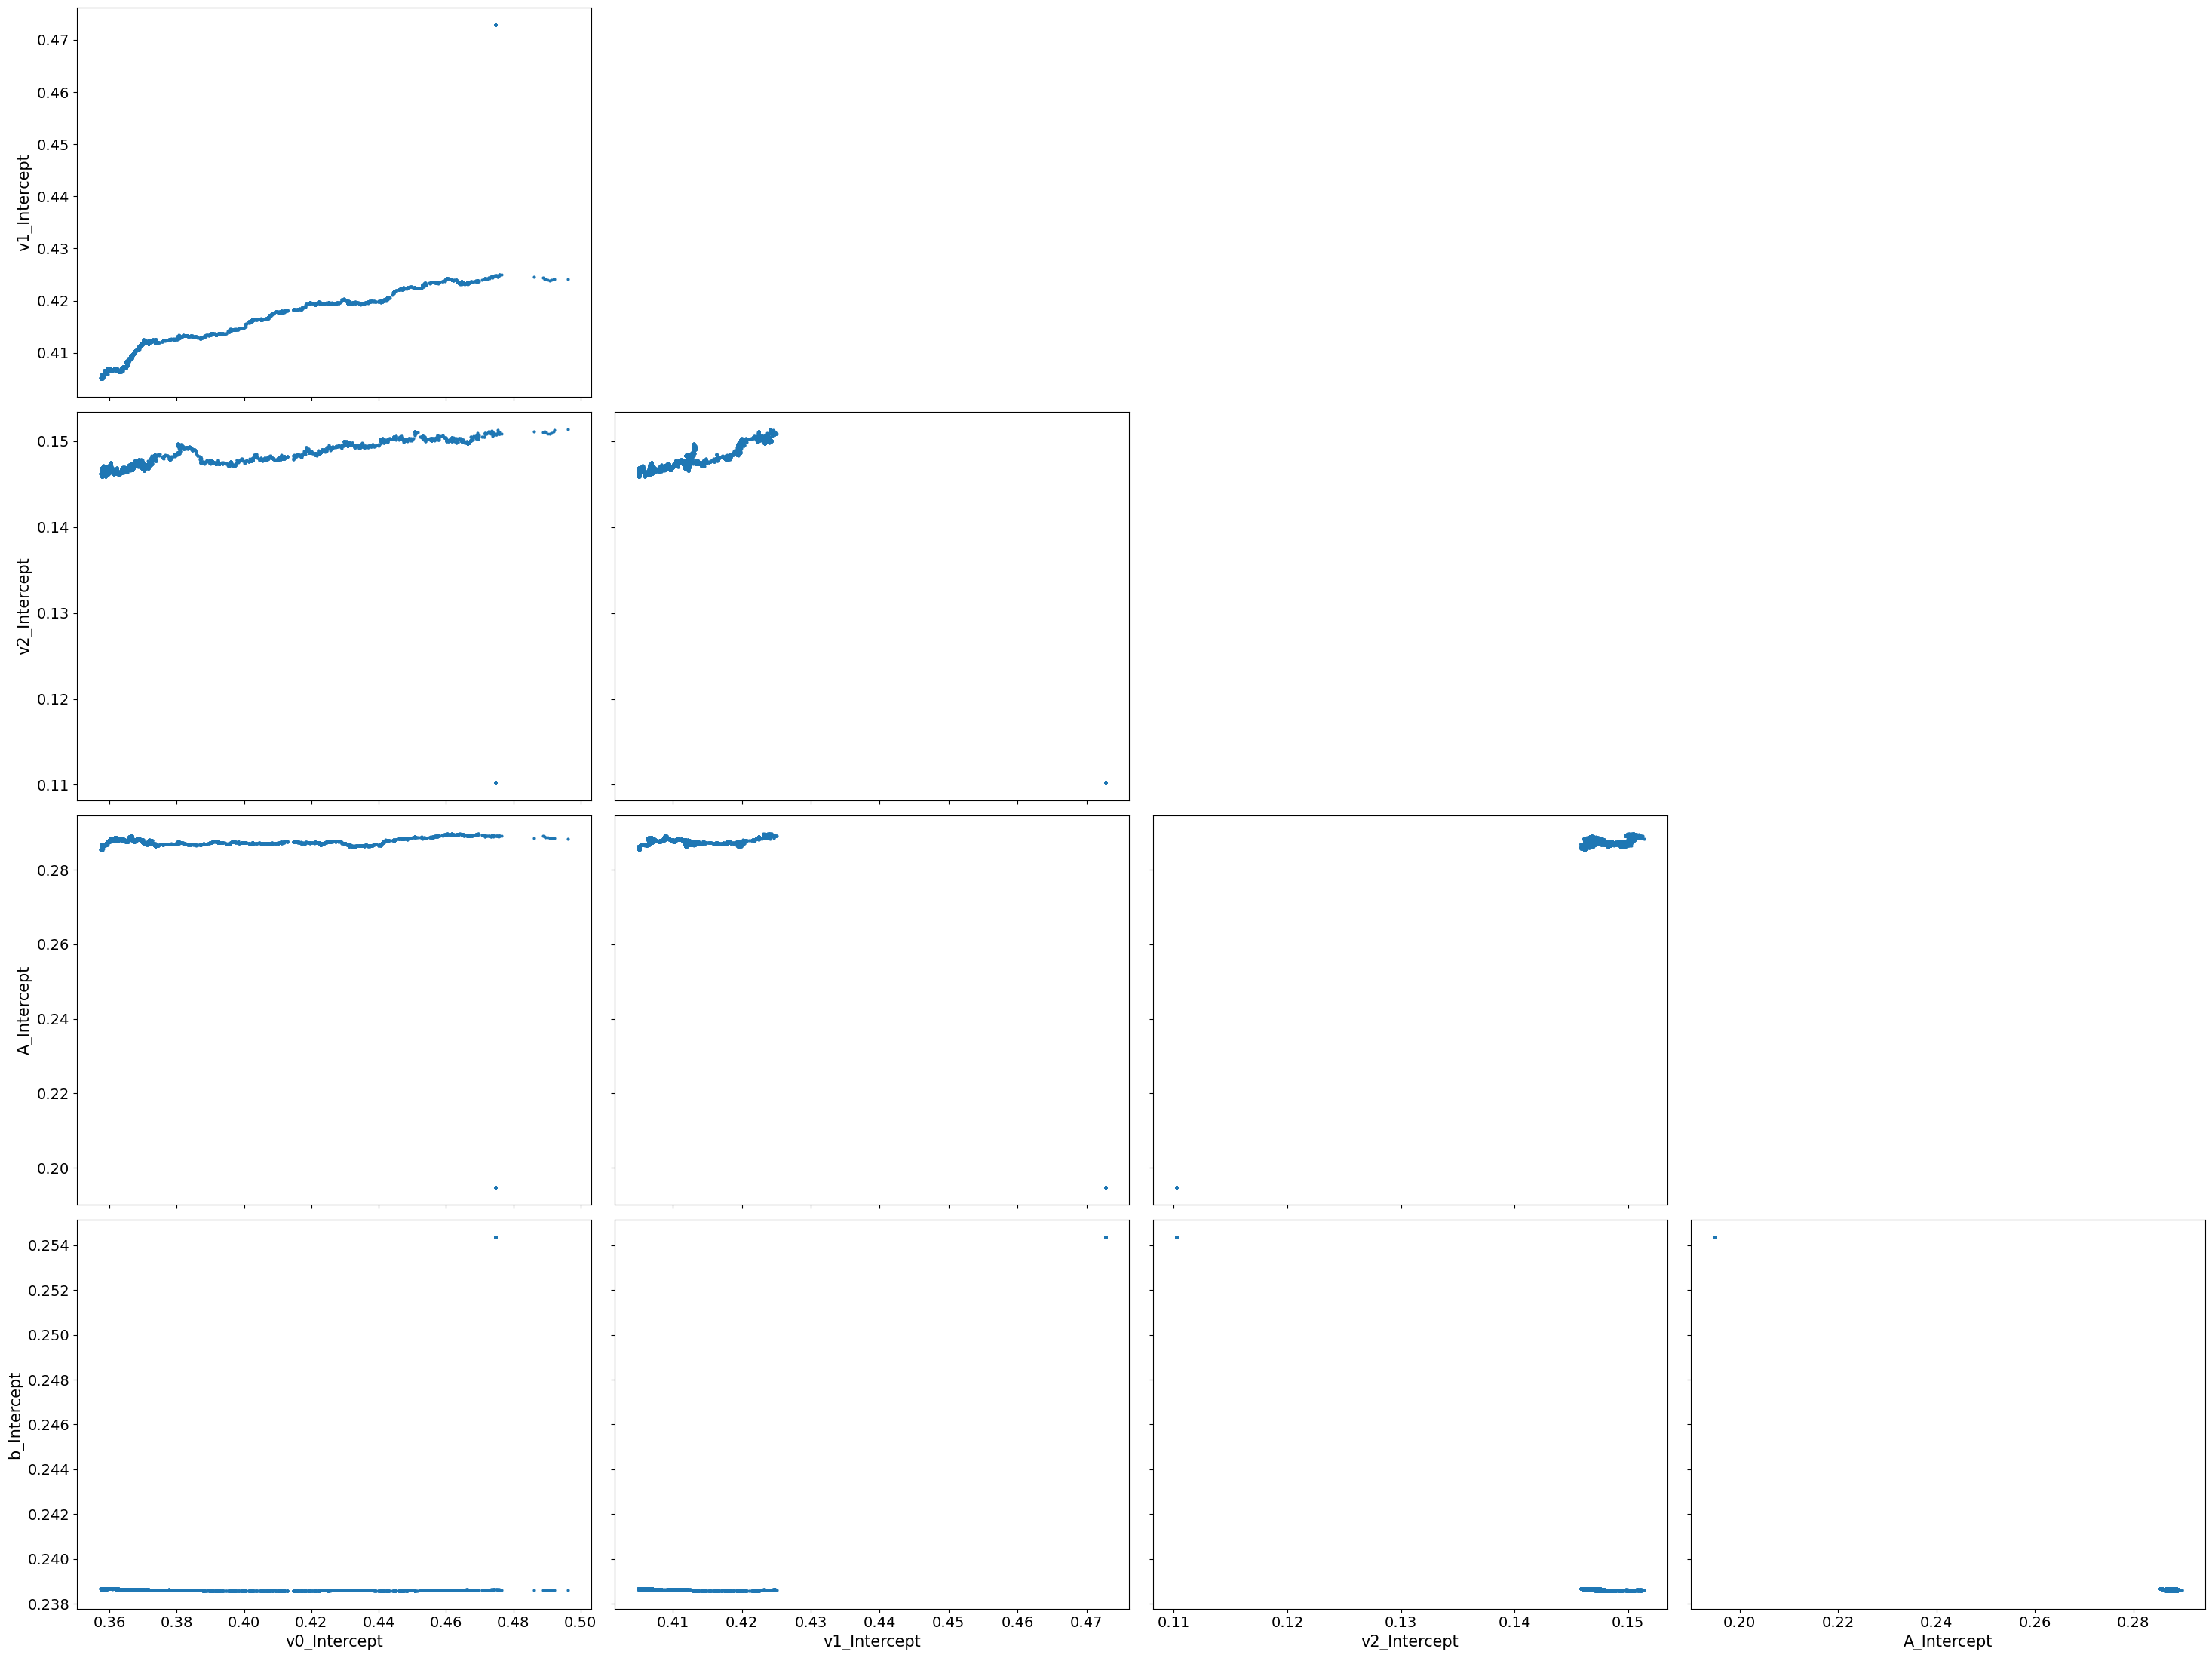

In [17]:
az.plot_pair(
    LBA3_inferenceData,var_names=['v0_Intercept','v1_Intercept',
                                                               'v2_Intercept', 'A_Intercept',
                                                               'b_Intercept']
)
plt.tight_layout()

# simulate data: simplest LBA 3 choices all params free

In [14]:
ssms.config.model_config['lba3']
#z is A starting point
#a is b threshold

{'name': 'lba3',
 'params': ['A', 'b', 'v0', 'v1', 'v2'],
 'param_bounds': [[0.0, 0.0, 0.0, 0.1, 0.1], [1.0, 1.0, 1.0, 1.1, 0.5]],
 'boundary_name': 'constant',
 'boundary': <function ssms.basic_simulators.boundary_functions.constant(t=0)>,
 'n_params': 5,
 'default_params': [0.3, 0.5, 0.25, 0.5, 0.25],
 'nchoices': 3,
 'simulator': <cyfunction lba_vanilla at 0x7f4c6c6b6f60>}

In [49]:
vanillaLBAallFree_simData=pd.DataFrame();
for sub in range(len(day2SubList)):
    
    idNum=day2SubList[sub]
    
    # figure out trial number from real data for the sub to determine sample numbers in the simulator
    trialNum=len(oddballDataDay2Choice.loc[oddballDataDay2Choice['participant_id'] == idNum])
    
    idCol=pd.DataFrame({'participant_id': [idNum] * trialNum})

    
    # Specify parameters based on gaussians using stats from the model fit with real data
    v0_true, v1_true, v2_true, a_true, z_true = [np.random.normal(0.45,0.001), 
                                                 np.random.normal(0.275,0.001), 
                                                 np.random.normal(0.275,0.001),
                                                 np.random.normal(0.5,0.001),
                                                 np.random.normal(0.2,0.001)]

#     v0_true, v1_true, v2_true, a_true, z_true = [1/3, 
#                                                  1/3, 
#                                                  1/3,
#                                                  0.5,
#                                                  0.2]
    # Simulate data
    sim_out = simulator(
        theta=[v0_true, v1_true, v2_true, a_true, z_true],  # parameter list
        model="lba_3_v1",  # specify model (many are included in ssms)
        n_samples=trialNum,  # number of samples for each set of parameters
    )

    # Turn into nice dataset
    # Turn data into a pandas dataframe
    subDataset = pd.DataFrame(
        np.column_stack([idCol["participant_id"],sim_out["rts"][:, 0], sim_out["choices"][:, 0]]),
        columns=["participant_id", "rt", "response"],
    )

    vanillaLBAallFree_simData=pd.concat([vanillaLBAallFree_simData, subDataset], ignore_index=True)

In [35]:
vanillaLBAallFree_simData

participant_id        rt  response
0             42013.0  0.847607       0.0
1             42013.0  0.773736       0.0
2             42013.0  0.881964       0.0
3             42013.0  0.717005       0.0
4             42013.0  0.964391       0.0
...               ...       ...       ...
11159         62433.0  1.101790       0.0
11160         62433.0  0.599279       0.0
11161         62433.0  1.191082       2.0
11162         62433.0  0.910320       1.0
11163         62433.0  1.071283       0.0

[11164 rows x 3 columns]

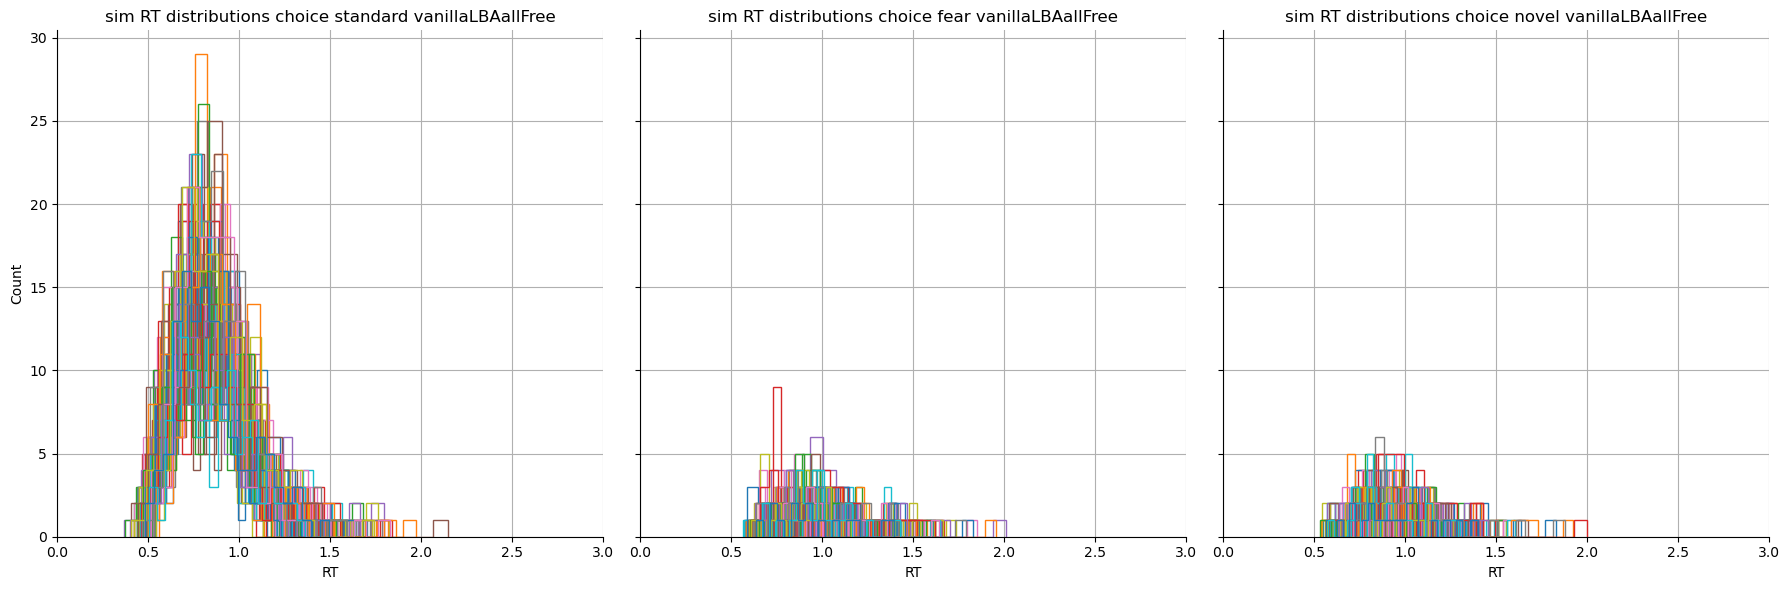

In [50]:
vanillaLBAallFree_simData['rtPlot']=vanillaLBAallFree_simData['rt']

# Filter data for each response type
dataResponse0 = vanillaLBAallFree_simData.loc[vanillaLBAallFree_simData['response'] == 0]
dataResponse1 = vanillaLBAallFree_simData.loc[vanillaLBAallFree_simData['response'] == 1]
dataResponse2 = vanillaLBAallFree_simData.loc[vanillaLBAallFree_simData['response'] == 2]

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot for response == 0
for i, subj_data in dataResponse0.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[0])
axes[0].set_title('sim RT distributions choice standard vanillaLBAallFree')
axes[0].set_xlabel('RT')
axes[0].set_ylabel('Count')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].set_xlim(0, 3)

# Plot for response == 1
for i, subj_data in dataResponse1.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[1])
axes[1].set_title('sim RT distributions choice fear vanillaLBAallFree')
axes[1].set_xlabel('RT')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].set_xlim(0, 3)

# Plot for response == 2
for i, subj_data in dataResponse2.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[2])
axes[2].set_title('sim RT distributions choice novel vanillaLBAallFree')
axes[2].set_xlabel('RT')
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)
axes[2].set_xlim(0, 3)

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig(basepath + '/figures/sim_subRT_dist_all_choices_vanillaLBAallFree.pdf')


 ### set up LBA model nuts numpyro

In [80]:
simple_LBA_model_hier_all_noPrior_simData = hssm.HSSM(
    data=vanillaLBAallFree_simData,
    model="lba3",
    choices = [0,1,2],
    hierarchical=True,
    noncentered=False,
    loglik_kind="analytical")


Model initialized successfully.


In [53]:
print(simple_LBA_model_hier_all_noPrior)

Hierarchical Sequential Sampling Model
Model: lba3

Response variable: rt,response
Likelihood: analytical
Observations: 11164

Parameters:

A:
    Formula: A ~ 1 + (1|participant_id)
    Priors:
        A_Intercept ~ Normal(mu: 0.0, sigma: 0.25)
        A_1|participant_id ~ Normal(mu: 0.0, sigma: Weibull(alpha: 1.5, beta: 0.30000001192092896))
    Link: identity
    Explicit bounds: (0.0, inf)

b:
    Formula: b ~ 1 + (1|participant_id)
    Priors:
        b_Intercept ~ Normal(mu: 0.0, sigma: 0.25)
        b_1|participant_id ~ Normal(mu: 0.0, sigma: Weibull(alpha: 1.5, beta: 0.30000001192092896))
    Link: identity
    Explicit bounds: (0.2, inf)

v0:
    Formula: v0 ~ 1 + (1|participant_id)
    Priors:
        v0_Intercept ~ Normal(mu: 0.0, sigma: 0.25)
        v0_1|participant_id ~ Normal(mu: 0.0, sigma: Weibull(alpha: 1.5, beta: 0.30000001192092896))
    Link: identity
    Explicit bounds: (0.0, inf)

v1:
    Formula: v1 ~ 1 + (1|participant_id)
    Priors:
        v1_Intercept ~ No

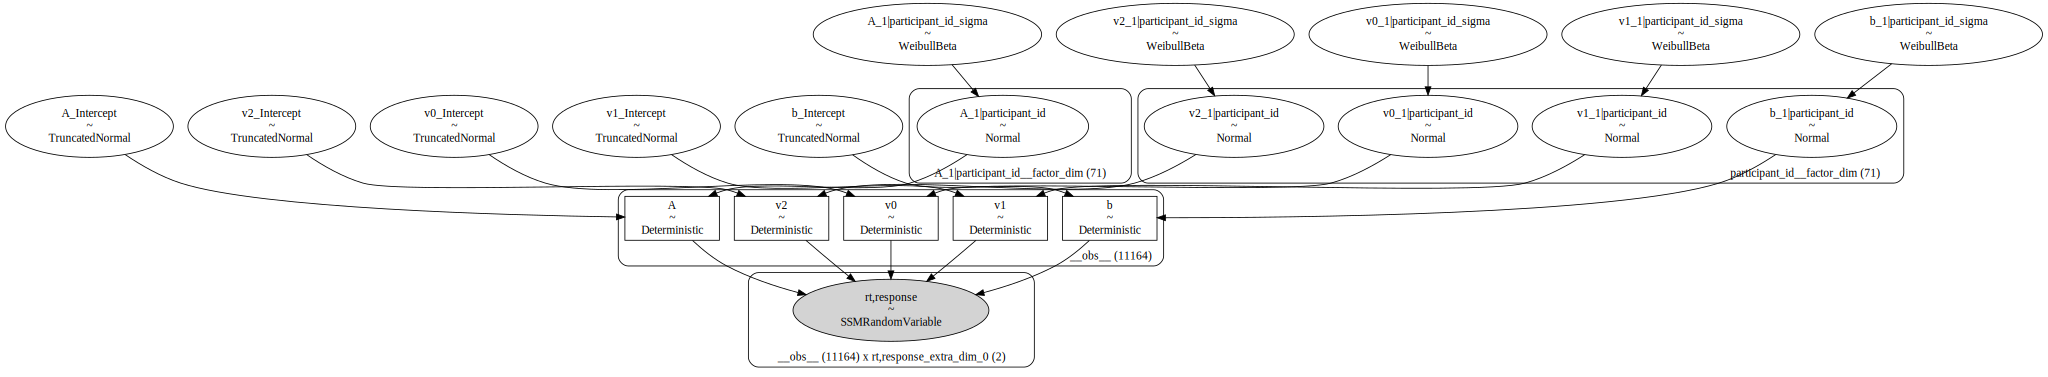

In [54]:
simple_LBA_model_hier_all_noPrior.graph()

In [ ]:
simple_LBA_model_hier_all_noPrior.pymc_model.deterministics

[A_1|participant_id ~ Deterministic(f(A_1|participant_id_offset, A_1|participant_id_sigma)),
 b_1|participant_id ~ Deterministic(f(b_1|participant_id_offset, b_1|participant_id_sigma)),
 v0_1|participant_id ~ Deterministic(f(v0_1|participant_id_offset, v0_1|participant_id_sigma)),
 v1_1|participant_id ~ Deterministic(f(v1_1|participant_id_offset, v1_1|participant_id_sigma)),
 v2_1|participant_id ~ Deterministic(f(v2_1|participant_id_offset, v2_1|participant_id_sigma)),
 A ~ Deterministic(f(A_Intercept, A_1|participant_id_offset, A_1|participant_id_sigma)),
 b ~ Deterministic(f(b_Intercept, b_1|participant_id_offset, b_1|participant_id_sigma)),
 v0 ~ Deterministic(f(v0_Intercept, v0_1|participant_id_offset, v0_1|participant_id_sigma)),
 v1 ~ Deterministic(f(v1_Intercept, v1_1|participant_id_offset, v1_1|participant_id_sigma)),
 v2 ~ Deterministic(f(v2_Intercept, v2_1|participant_id_offset, v2_1|participant_id_sigma))]

In [ ]:
help(simple_LBA_model_hier_all_noPrior.pymc_model._compute_deterministics)

In [81]:
pathlib.Path(basepath+'/models/lba/sept24/numpyro/').mkdir(parents=True, exist_ok=True)

inferenceData_simple_LBA_model_hier_all_noPrior=simple_LBA_model_hier_all_noPrior_simData.sample(
    sampler="nuts_numpyro",
    chains=4,
    cores=1,
    draws=3000,
    tune=1000,
    discard_tuned_samples=False,
    idata_kwargs=dict(log_likelihood=False),)

fileName = basepath + '/models/lba/sept24/numpyro/inferenceData_sim_simple_LBA_model_hier_all_noPrior.nc'
data = inferenceData_simple_LBA_model_hier_all_noPrior
az.to_netcdf(data, fileName)


Using default initvals. 



/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/pymc/sampling/jax.py:451: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:69: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/users/afengler/data/software/minico

'/users/afengler/data/proj_tt/mpib-HSSM-oddball-data/models/lba/sept24/numpyro/inferenceData_sim_simple_LBA_model_hier_all_noPrior.nc'

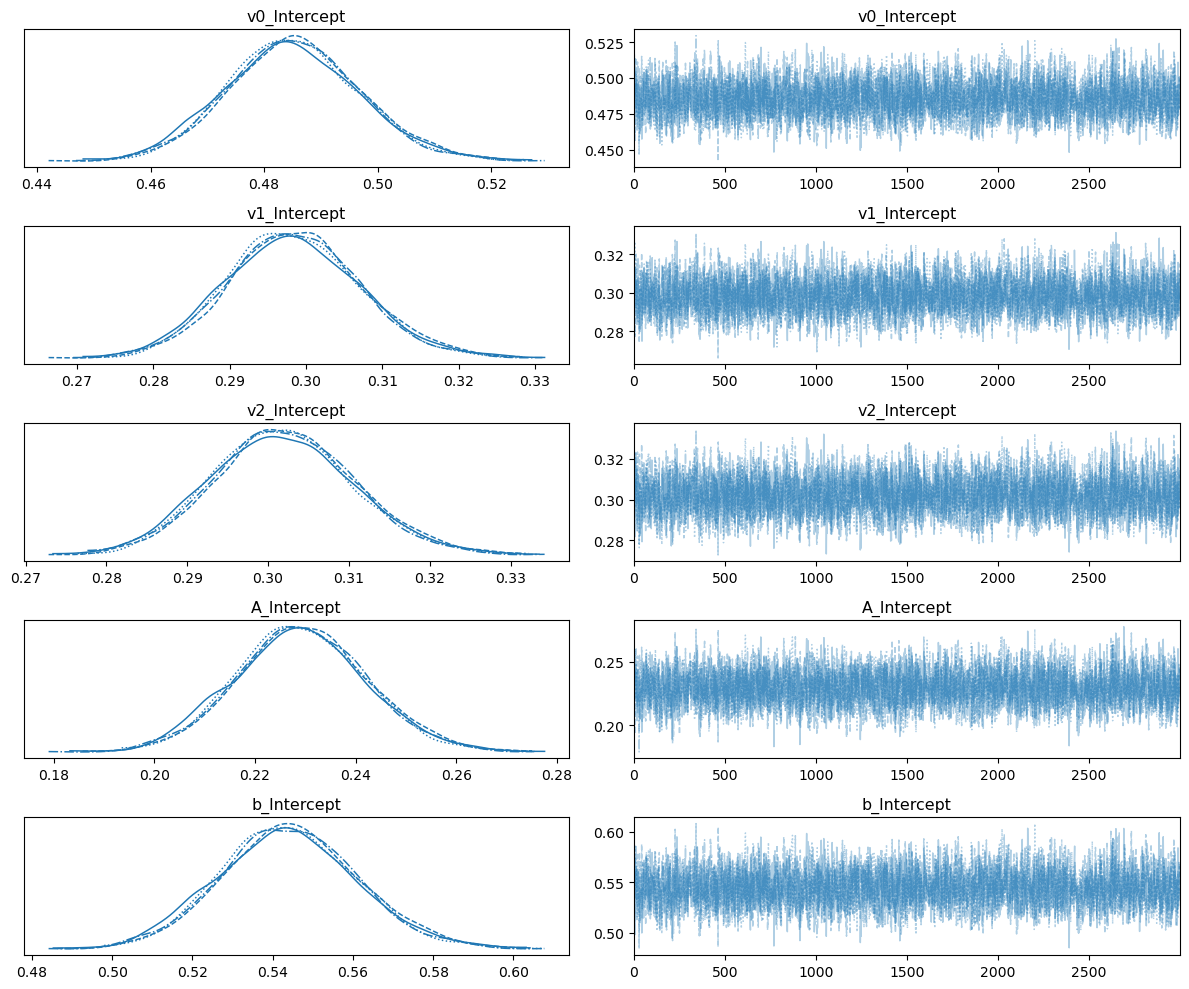

In [82]:
az.plot_trace(
    inferenceData_simple_LBA_model_hier_all_noPrior,var_names=['v0_Intercept','v1_Intercept',
                                                               'v2_Intercept', 'A_Intercept',
                                                               'b_Intercept']
)
plt.tight_layout()

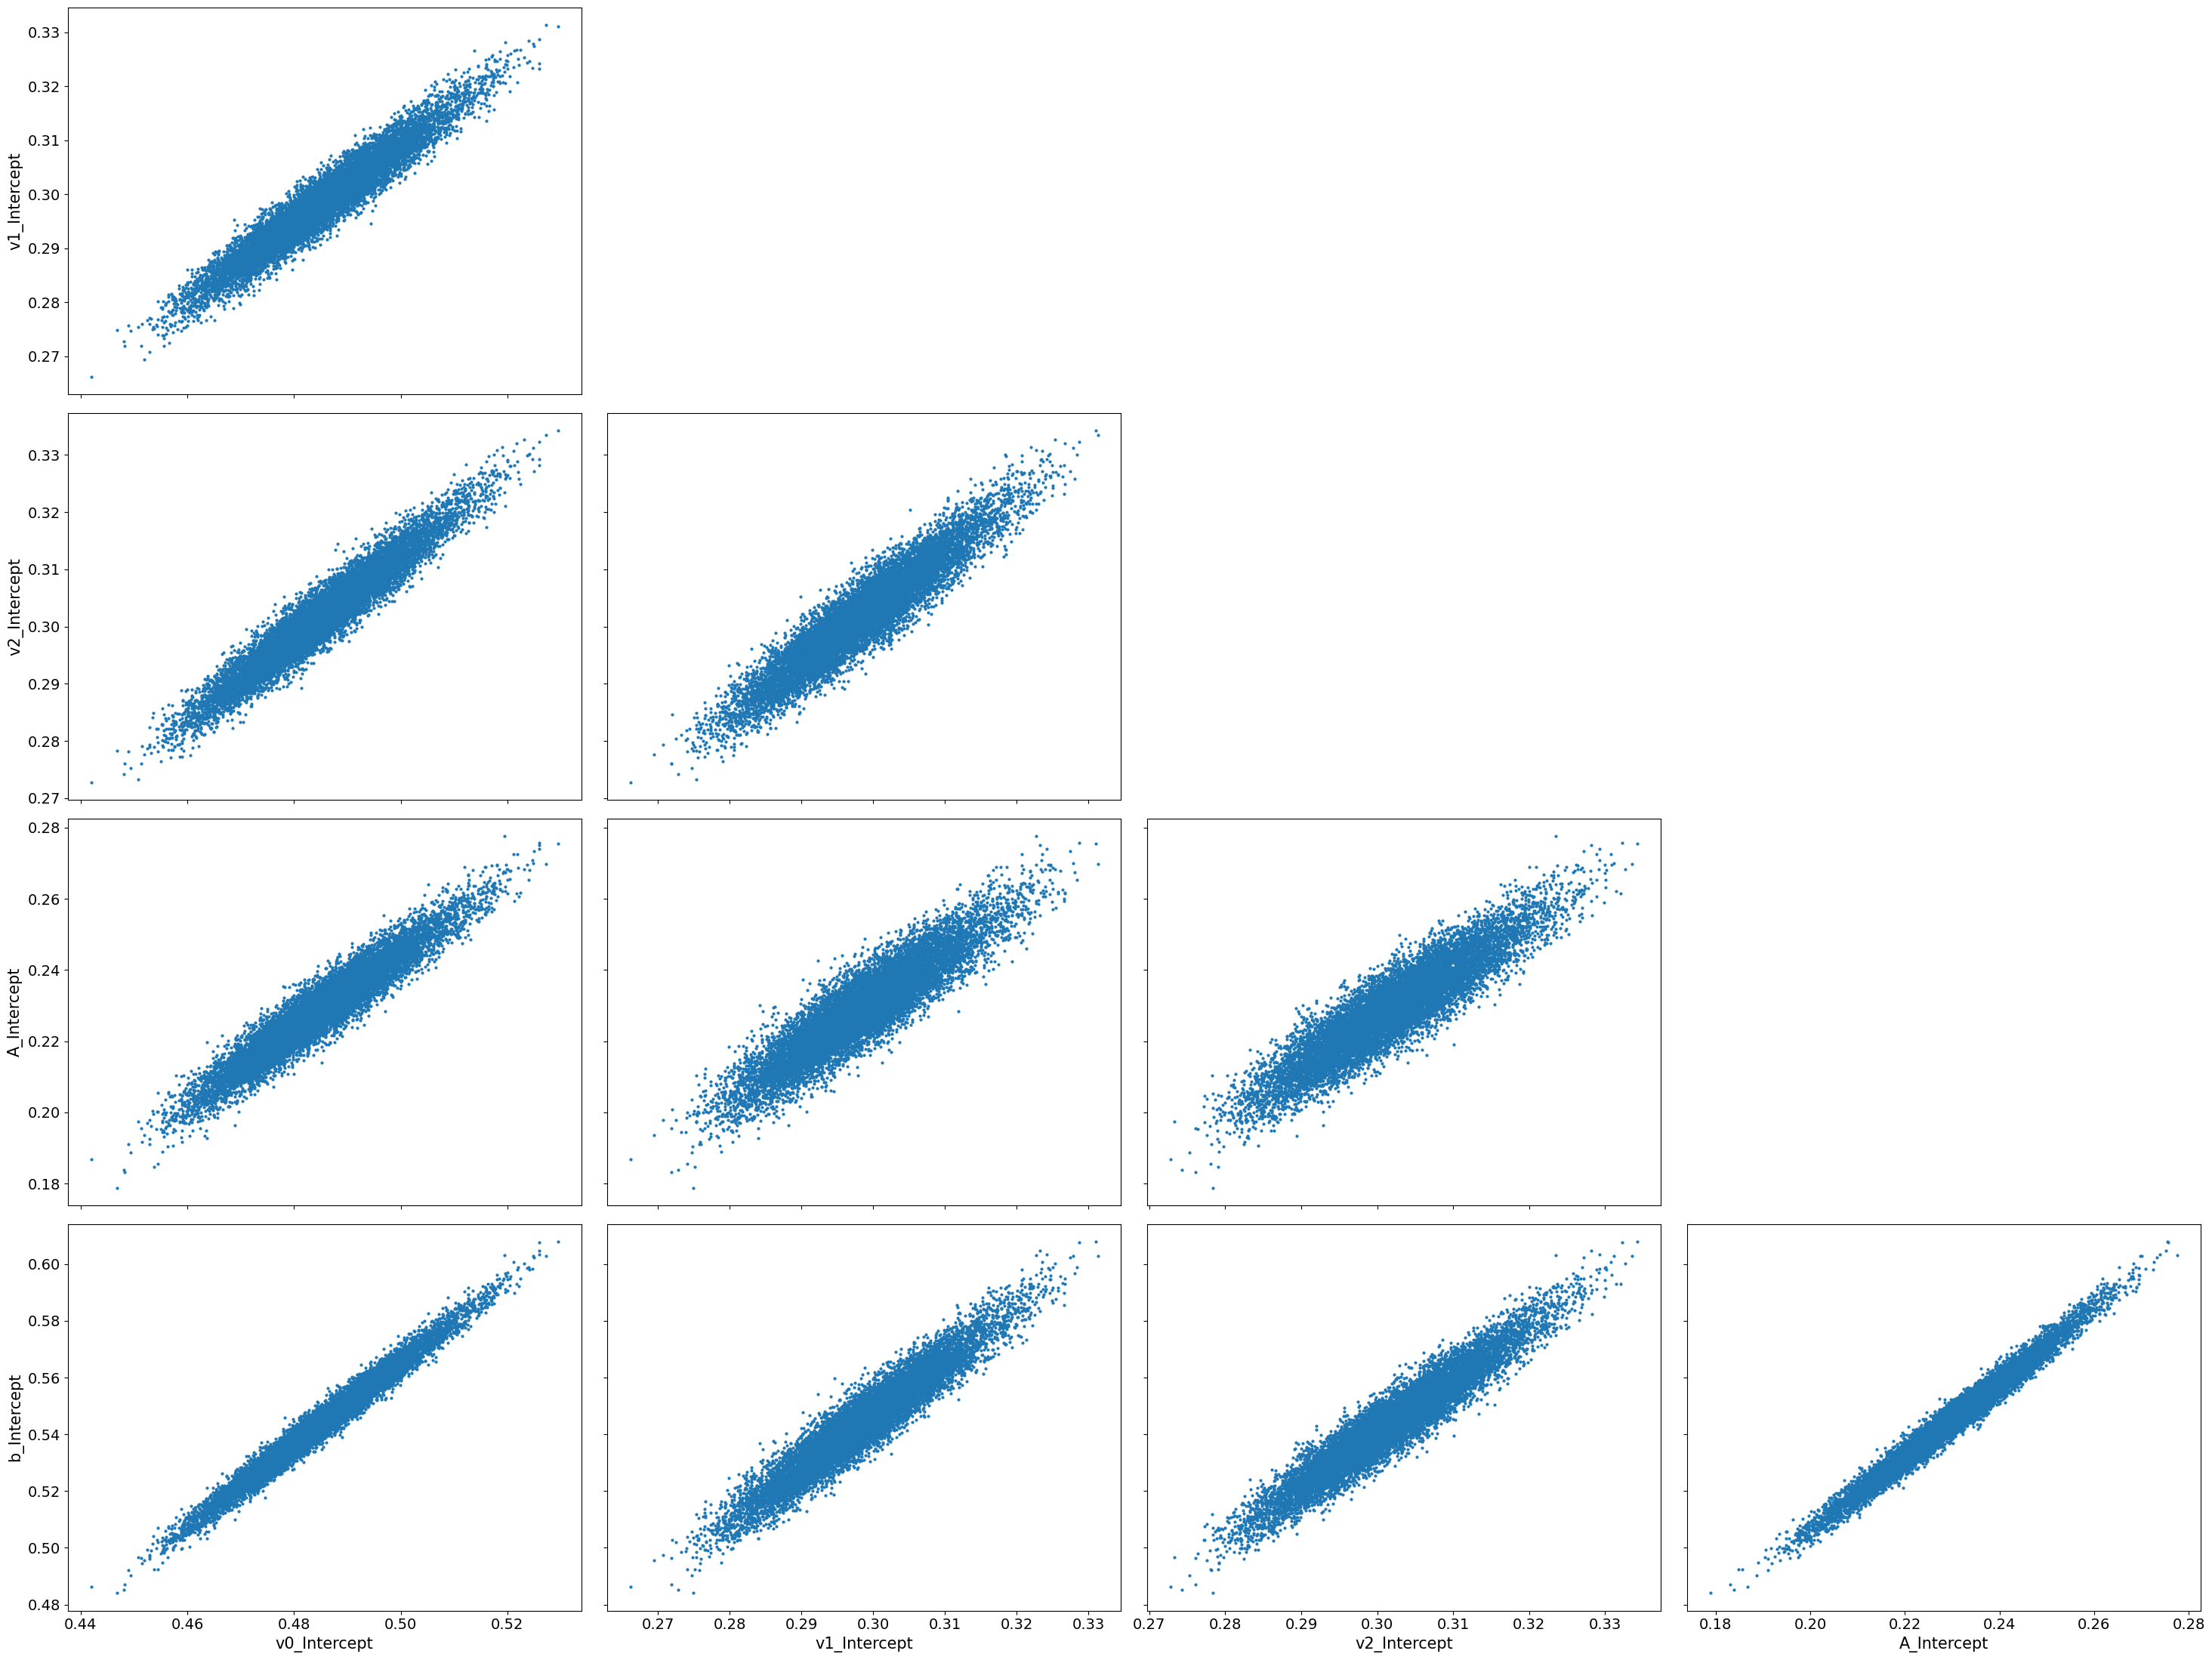

In [83]:
az.plot_pair(
    inferenceData_simple_LBA_model_hier_all_noPrior,var_names=['v0_Intercept','v1_Intercept',
                                                               'v2_Intercept', 'A_Intercept',
                                                               'b_Intercept']
)
plt.tight_layout()

## play around with the ground truth params to simulate data with more errors

In [11]:
vanillaLBAallFree_simDataEvenChoice=pd.DataFrame();
for sub in range(len(day2SubList)):
    
    idNum=day2SubList[sub]
    
    # figure out trial number from real data for the sub to determine sample numbers in the simulator
    trialNum=len(oddballDataDay2Choice.loc[oddballDataDay2Choice['participant_id'] == idNum])
    
    idCol=pd.DataFrame({'participant_id': [idNum] * trialNum})

    
    # Specify parameters based on gaussians using stats from the model fit with real data
    v0_true, v1_true, v2_true, a_true, z_true = [np.random.normal(1/3,0.001), 
                                                 np.random.normal(1/3,0.001), 
                                                 np.random.normal(1/3,0.001),
                                                 np.random.normal(0.5,0.001),
                                                 np.random.normal(0.2,0.001)]

#     v0_true, v1_true, v2_true, a_true, z_true = [1/3, 
#                                                  1/3, 
#                                                  1/3,
#                                                  0.5,
#                                                  0.2]
    # Simulate data
    sim_out = simulator(
        theta=[v0_true, v1_true, v2_true, a_true, z_true],  # parameter list
        model="lba_3_v1",  # specify model (many are included in ssms)
        n_samples=trialNum,  # number of samples for each set of parameters
    )

    # Turn into nice dataset
    # Turn data into a pandas dataframe
    subDataset = pd.DataFrame(
        np.column_stack([idCol["participant_id"],sim_out["rts"][:, 0], sim_out["choices"][:, 0]]),
        columns=["participant_id", "rt", "response"],
    )

    vanillaLBAallFree_simDataEvenChoice=pd.concat([vanillaLBAallFree_simDataEvenChoice, subDataset], ignore_index=True)

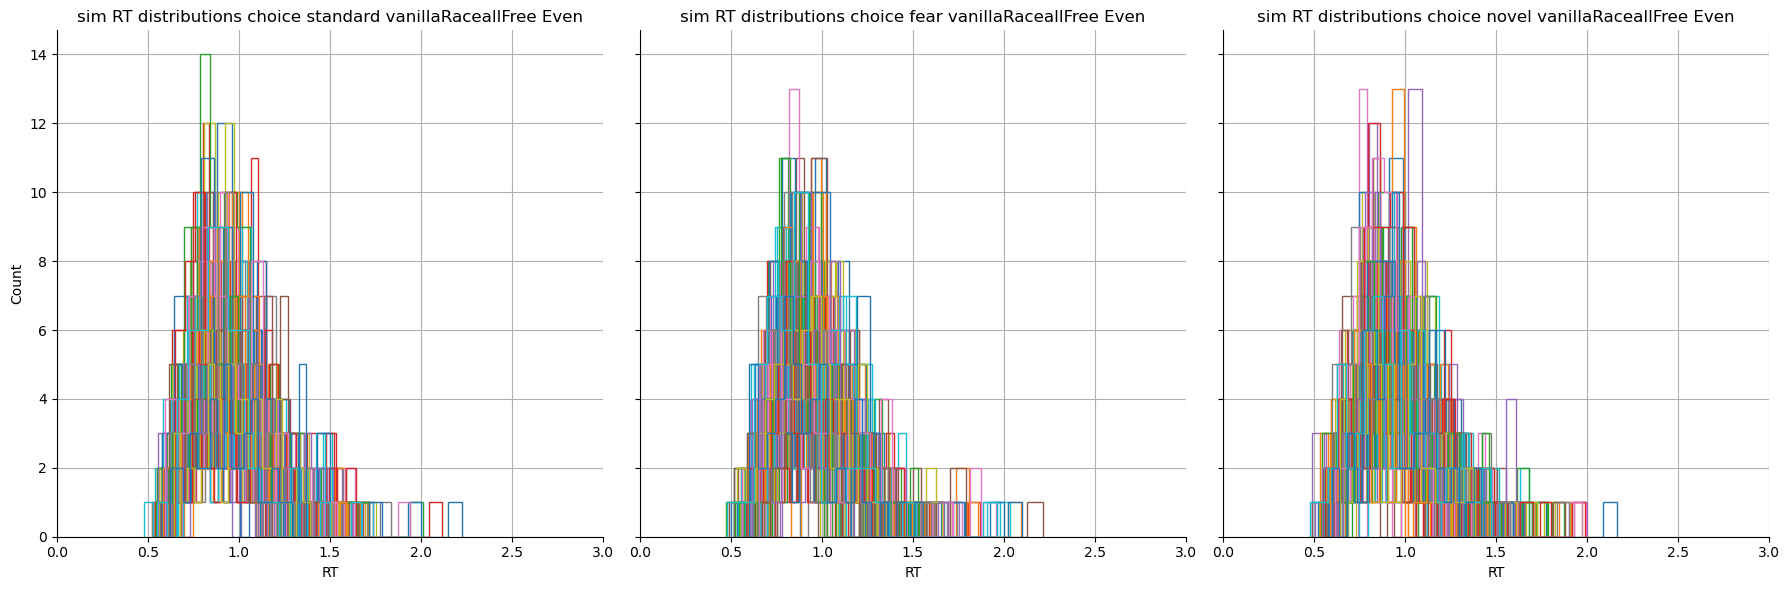

In [12]:
vanillaLBAallFree_simDataEvenChoice['rtPlot']=vanillaLBAallFree_simDataEvenChoice['rt']

# Filter data for each response type
dataResponse0 = vanillaLBAallFree_simDataEvenChoice.loc[vanillaLBAallFree_simDataEvenChoice['response'] == 0]
dataResponse1 = vanillaLBAallFree_simDataEvenChoice.loc[vanillaLBAallFree_simDataEvenChoice['response'] == 1]
dataResponse2 = vanillaLBAallFree_simDataEvenChoice.loc[vanillaLBAallFree_simDataEvenChoice['response'] == 2]

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot for response == 0
for i, subj_data in dataResponse0.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[0])
axes[0].set_title('sim RT distributions choice standard vanillaRaceallFree Even')
axes[0].set_xlabel('RT')
axes[0].set_ylabel('Count')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].set_xlim(0, 3)

# Plot for response == 1
for i, subj_data in dataResponse1.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[1])
axes[1].set_title('sim RT distributions choice fear vanillaRaceallFree Even')
axes[1].set_xlabel('RT')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].set_xlim(0, 3)

# Plot for response == 2
for i, subj_data in dataResponse2.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[2])
axes[2].set_title('sim RT distributions choice novel vanillaRaceallFree Even')
axes[2].set_xlabel('RT')
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)
axes[2].set_xlim(0, 3)

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig(basepath + '/figures/sim_subRT_dist_all_choices_vanillaRaceallFree_evenChoice.pdf')


### set up LBA model nuts numpyro

In [13]:
simple_LBA_model_hier_all_noPrior_simData_evenChoice = hssm.HSSM(
    data=vanillaLBAallFree_simDataEvenChoice,
    model="lba3",
    choices = [0,1,2],
    hierarchical=True,
    noncentered=False,
    loglik_kind="analytical")


Model initialized successfully.


In [14]:
pathlib.Path(basepath+'/models/lba/sept24/numpyro/').mkdir(parents=True, exist_ok=True)

inferenceData_simple_LBA_model_hier_all_noPrior=simple_LBA_model_hier_all_noPrior_simData_evenChoice.sample(
    sampler="nuts_numpyro",
    chains=4,
    cores=1,
    draws=3000,
    tune=1000,
    discard_tuned_samples=False,
    idata_kwargs=dict(log_likelihood=False),)



Using default initvals. 



2024-09-01 19:09:07.557383: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.68). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/pymc/sampling/jax.py:451: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/jax/_src/numpy/array_methods

In [15]:
fileName = basepath + '/models/lba/sept24/numpyro/inferenceData_sim_evenChoice_simple_LBA_model_hier_all_noPrior.nc'
data = inferenceData_simple_LBA_model_hier_all_noPrior
az.to_netcdf(data, fileName)


'/users/afengler/data/proj_tt/mpib-HSSM-oddball-data/models/lba/sept24/numpyro/inferenceData_sim_evenChoice_simple_LBA_model_hier_all_noPrior.nc'

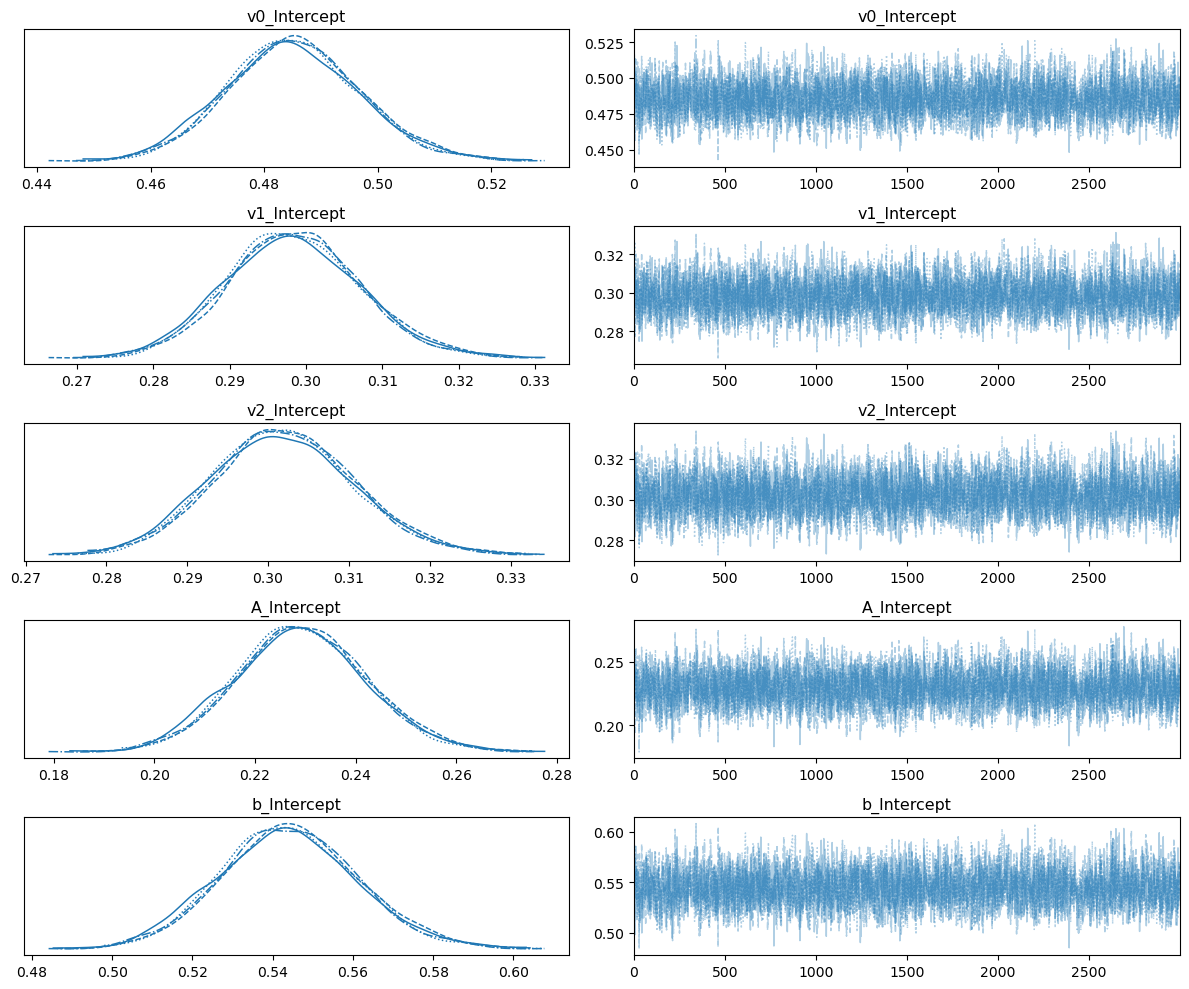

In [87]:
az.plot_trace(
    inferenceData_simple_LBA_model_hier_all_noPrior,var_names=['v0_Intercept','v1_Intercept',
                                                               'v2_Intercept', 'A_Intercept',
                                                               'b_Intercept']
)
plt.tight_layout()

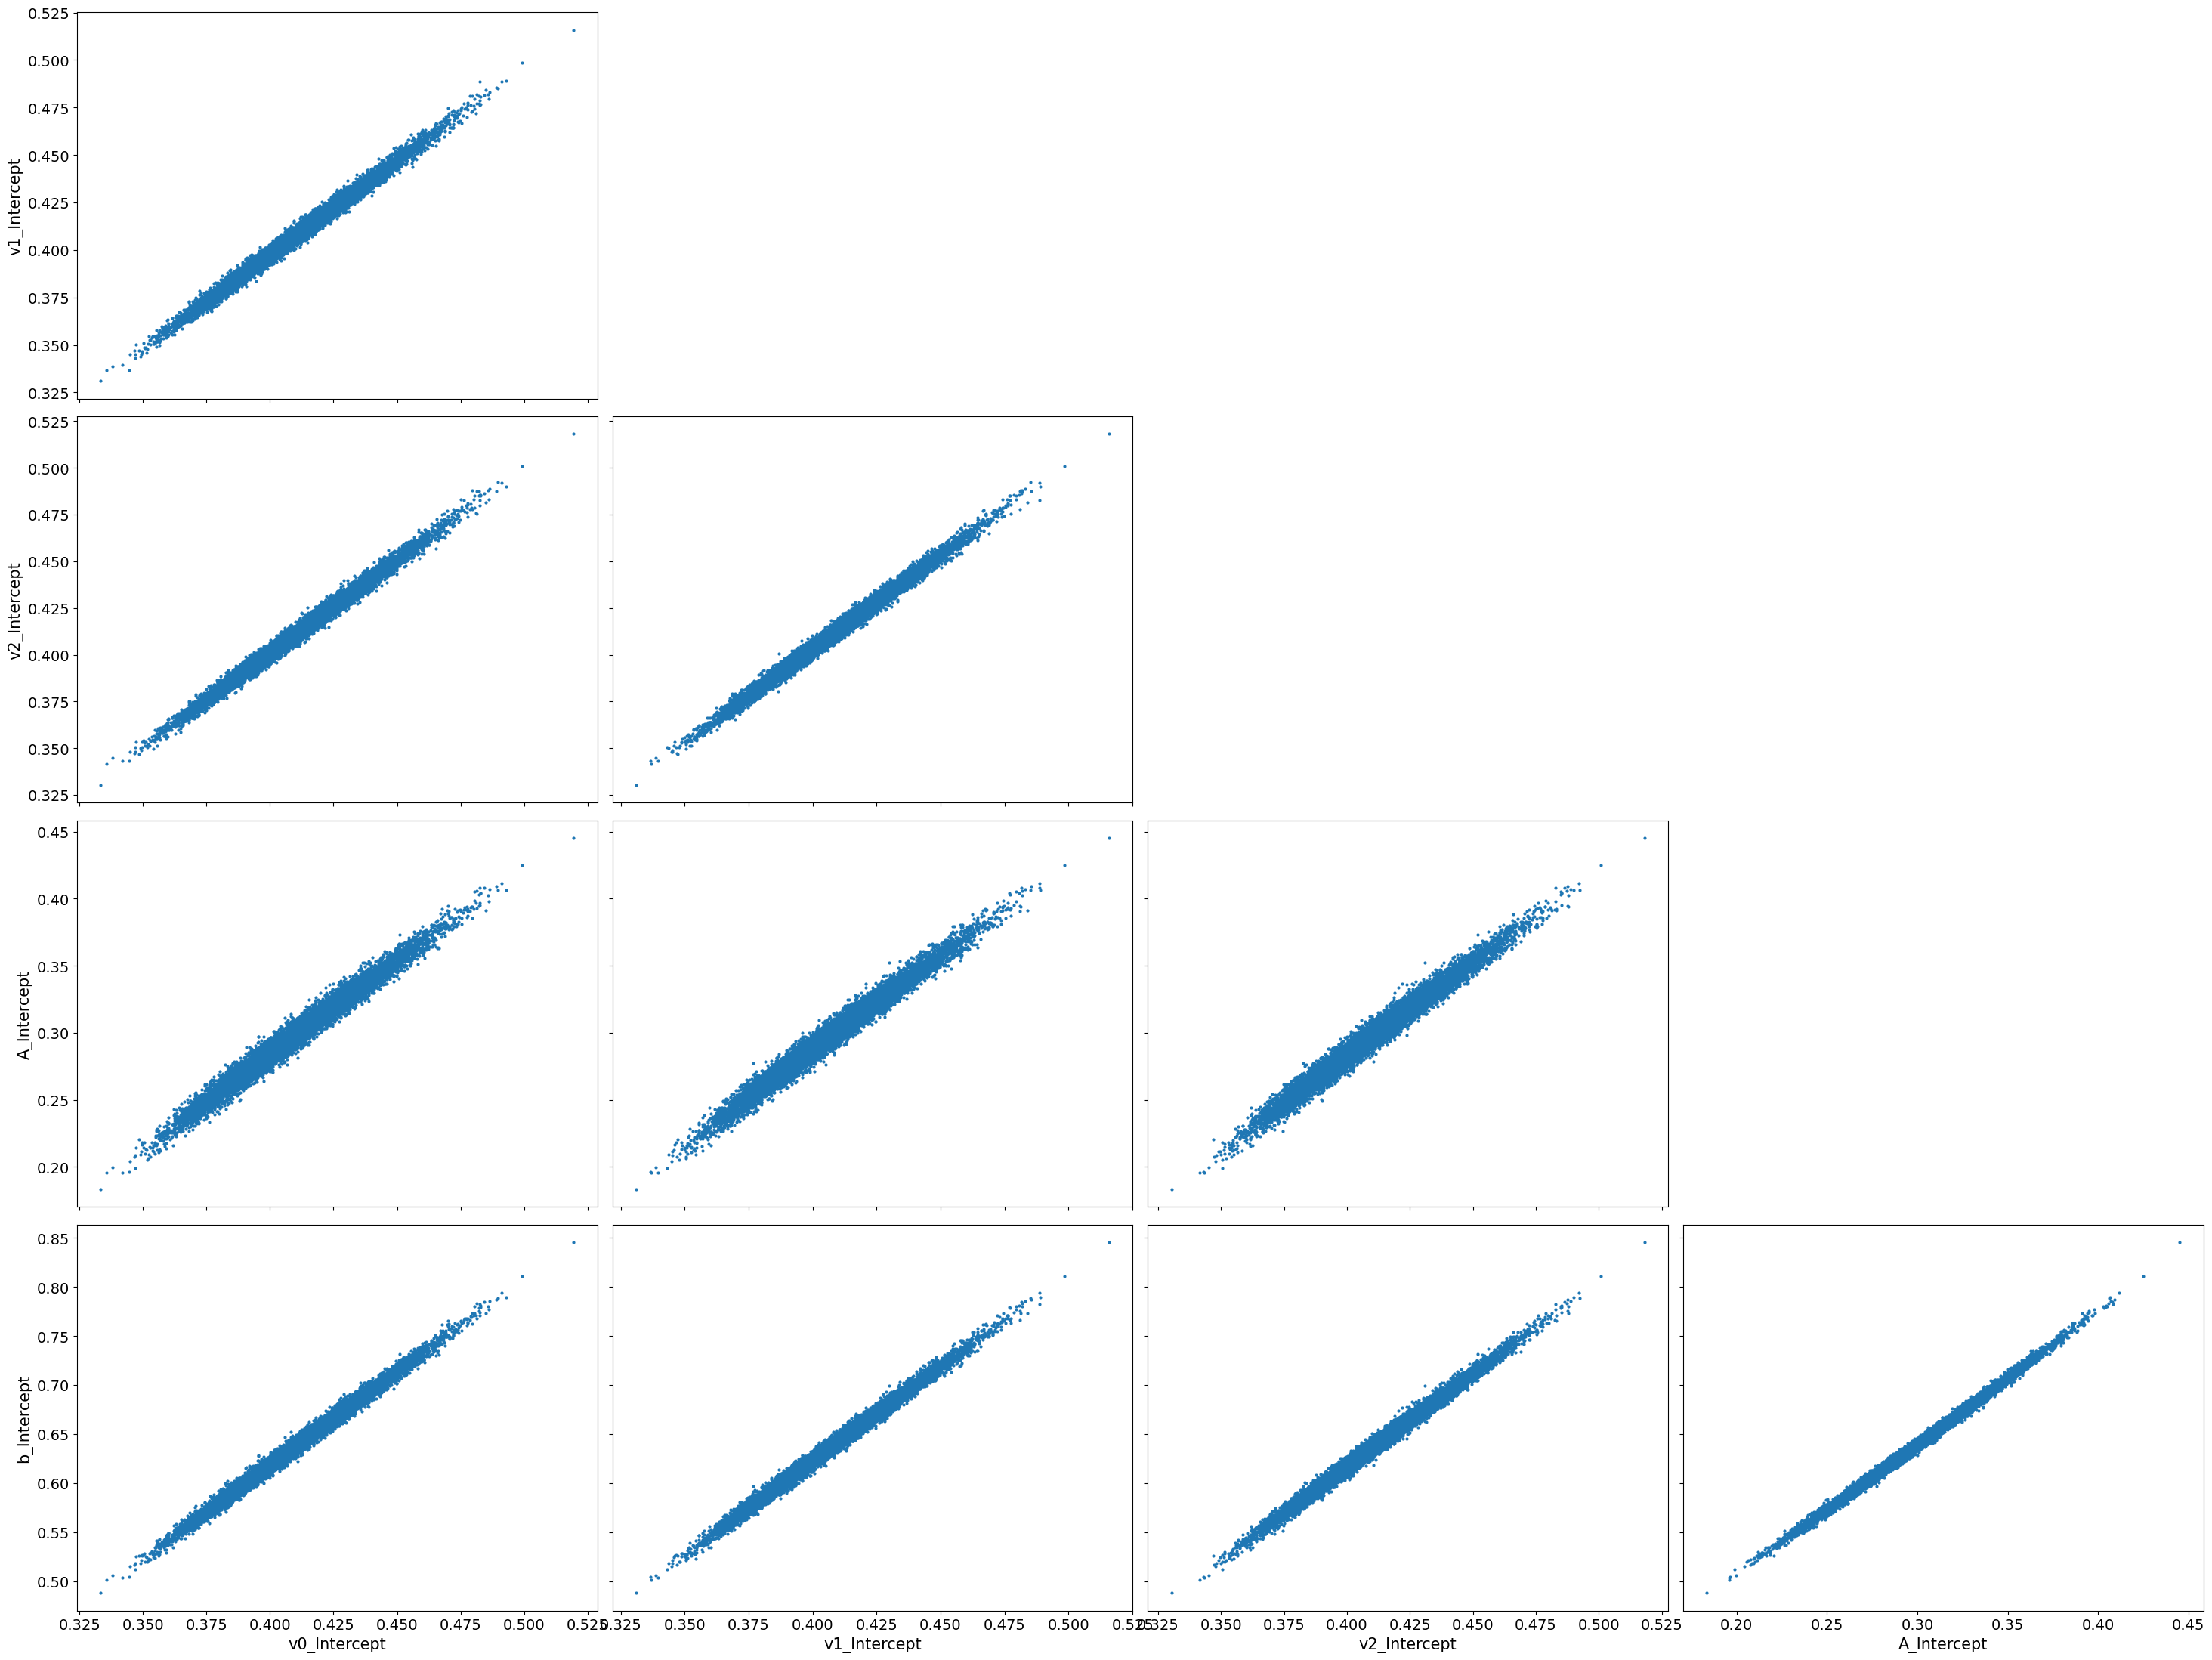

In [16]:
az.plot_pair(
    inferenceData_simple_LBA_model_hier_all_noPrior,var_names=['v0_Intercept','v1_Intercept',
                                                               'v2_Intercept', 'A_Intercept',
                                                               'b_Intercept']
)
plt.tight_layout()

## lba_3 model instead of lba_3_v1

In [16]:
#sim data
vanillaLBAallFree_simData=pd.DataFrame();
for sub in range(len(day2SubList)):
    
    idNum=day2SubList[sub]
    
    # figure out trial number from real data for the sub to determine sample numbers in the simulator
    trialNum=len(oddballDataDay2Choice.loc[oddballDataDay2Choice['participant_id'] == idNum])
    
    idCol=pd.DataFrame({'participant_id': [idNum] * trialNum})

    
    # Specify parameters based on gaussians using stats from the model fit with real data
    A_true, b_true, v0_true, v1_true, v2_true  = [np.random.normal(0.137,0.020),
                                                 np.random.normal(0.498,0.032),
                                                 np.random.normal(0.501,0.017), 
                                                 np.random.normal(0.349,0.015), 
                                                 np.random.normal(0.358,0.011)
                                                 ]

#     v0_true, v1_true, v2_true, a_true, z_true = [1/3, 
#                                                  1/3, 
#                                                  1/3,
#                                                  0.5,
#                                                  0.2]
    # Simulate data
    sim_out = simulator(
        theta=[A_true, b_true, v0_true, v1_true, v2_true],  # parameter list
        model="lba3",  # specify model (many are included in ssms)
        n_samples=trialNum,  # number of samples for each set of parameters
    )

    # Turn into nice dataset
    # Turn data into a pandas dataframe
    subDataset = pd.DataFrame(
        np.column_stack([idCol["participant_id"],sim_out["rts"][:, 0], sim_out["choices"][:, 0]]),
        columns=["participant_id", "rt", "response"],
    )

    vanillaLBAallFree_simData=pd.concat([vanillaLBAallFree_simData, subDataset], ignore_index=True)


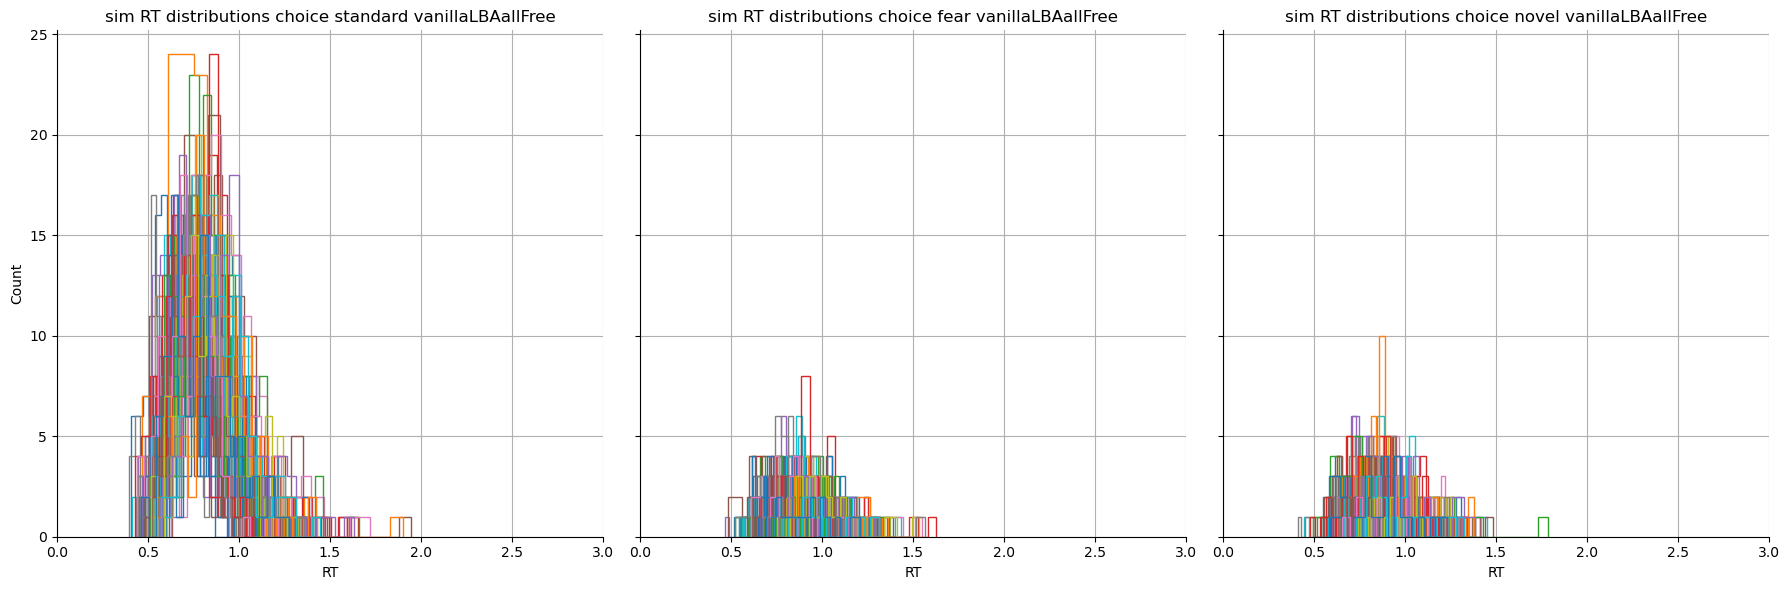

In [17]:
vanillaLBAallFree_simData['rtPlot']=vanillaLBAallFree_simData['rt']

# Filter data for each response type
dataResponse0 = vanillaLBAallFree_simData.loc[vanillaLBAallFree_simData['response'] == 0]
dataResponse1 = vanillaLBAallFree_simData.loc[vanillaLBAallFree_simData['response'] == 1]
dataResponse2 = vanillaLBAallFree_simData.loc[vanillaLBAallFree_simData['response'] == 2]

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot for response == 0
for i, subj_data in dataResponse0.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[0])
axes[0].set_title('sim RT distributions choice standard vanillaLBAallFree')
axes[0].set_xlabel('RT')
axes[0].set_ylabel('Count')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].set_xlim(0, 3)

# Plot for response == 1
for i, subj_data in dataResponse1.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[1])
axes[1].set_title('sim RT distributions choice fear vanillaLBAallFree')
axes[1].set_xlabel('RT')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].set_xlim(0, 3)

# Plot for response == 2
for i, subj_data in dataResponse2.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[2])
axes[2].set_title('sim RT distributions choice novel vanillaLBAallFree')
axes[2].set_xlabel('RT')
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)
axes[2].set_xlim(0, 3)

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig(basepath + '/figures/sim_subRT_dist_all_choices_vanillaLBAallFree.pdf')


## play around with the ground truth params to simulate data with more errors

In [20]:
vanillaLBAallFree_simDataEvenChoice=pd.DataFrame();
for sub in range(len(day2SubList)):
    
    idNum=day2SubList[sub]
    
    # figure out trial number from real data for the sub to determine sample numbers in the simulator
    trialNum=len(oddballDataDay2Choice.loc[oddballDataDay2Choice['participant_id'] == idNum])
    
    idCol=pd.DataFrame({'participant_id': [idNum] * trialNum})

    
    # Specify parameters based on gaussians using stats from the model fit with real data
    A_true, b_true, v0_true, v1_true, v2_true  = [np.random.normal(0.137,0.020),
                                                 np.random.normal(0.498,0.032),
                                                 np.random.normal(1/3,0.01), 
                                                 np.random.normal(1/3,0.01), 
                                                 np.random.normal(1/3,0.01)
                                                 ]

#     v0_true, v1_true, v2_true, a_true, z_true = [1/3, 
#                                                  1/3, 
#                                                  1/3,
#                                                  0.5,
#                                                  0.2]
    # Simulate data
    sim_out = simulator(
        theta=[A_true, b_true, v0_true, v1_true, v2_true],  # parameter list
        model="lba3",  # specify model (many are included in ssms)
        n_samples=trialNum,  # number of samples for each set of parameters
    )

    # Turn into nice dataset
    # Turn data into a pandas dataframe
    subDataset = pd.DataFrame(
        np.column_stack([idCol["participant_id"],sim_out["rts"][:, 0], sim_out["choices"][:, 0]]),
        columns=["participant_id", "rt", "response"],
    )

    vanillaLBAallFree_simDataEvenChoice=pd.concat([vanillaLBAallFree_simDataEvenChoice, subDataset], ignore_index=True)

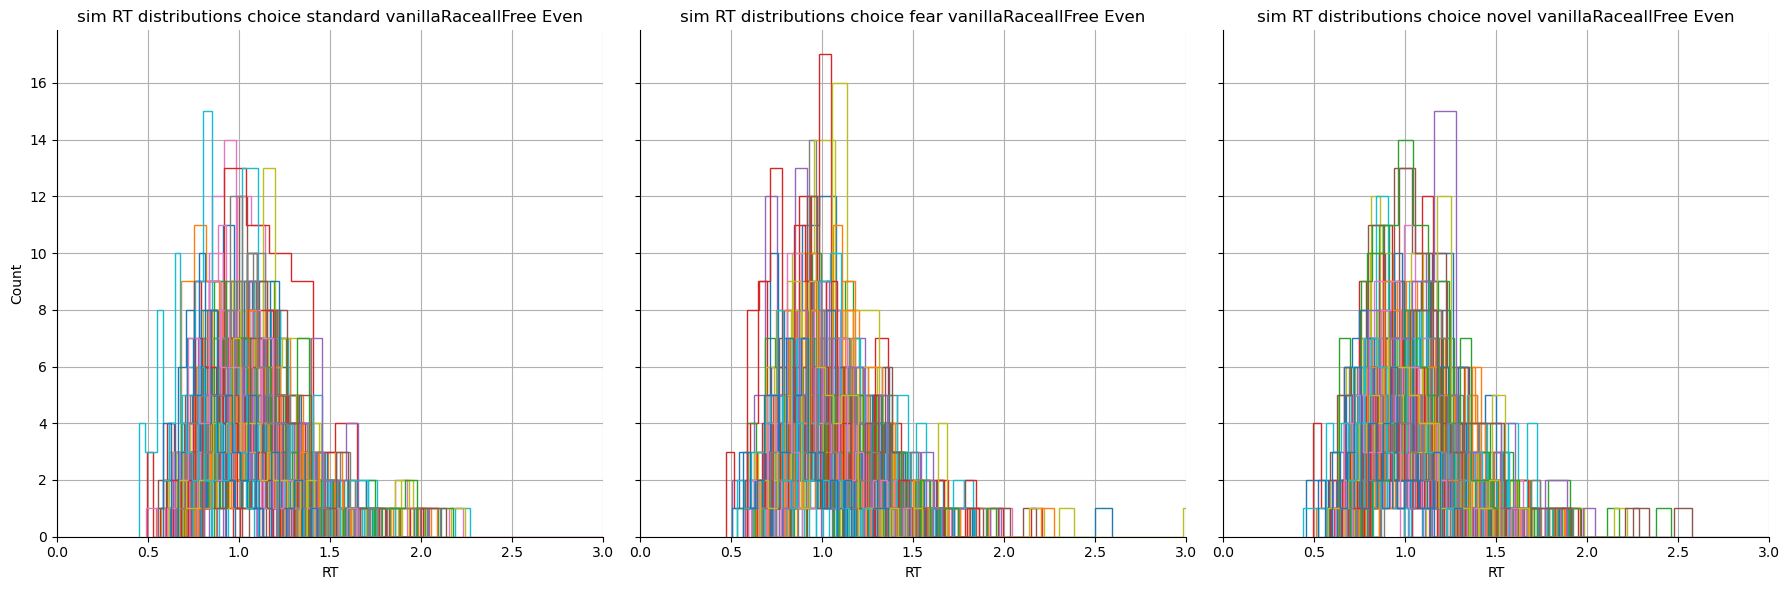

In [21]:
vanillaLBAallFree_simDataEvenChoice['rtPlot']=vanillaLBAallFree_simDataEvenChoice['rt']

# Filter data for each response type
dataResponse0 = vanillaLBAallFree_simDataEvenChoice.loc[vanillaLBAallFree_simDataEvenChoice['response'] == 0]
dataResponse1 = vanillaLBAallFree_simDataEvenChoice.loc[vanillaLBAallFree_simDataEvenChoice['response'] == 1]
dataResponse2 = vanillaLBAallFree_simDataEvenChoice.loc[vanillaLBAallFree_simDataEvenChoice['response'] == 2]

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot for response == 0
for i, subj_data in dataResponse0.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[0])
axes[0].set_title('sim RT distributions choice standard vanillaRaceallFree Even')
axes[0].set_xlabel('RT')
axes[0].set_ylabel('Count')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].set_xlim(0, 3)

# Plot for response == 1
for i, subj_data in dataResponse1.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[1])
axes[1].set_title('sim RT distributions choice fear vanillaRaceallFree Even')
axes[1].set_xlabel('RT')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].set_xlim(0, 3)

# Plot for response == 2
for i, subj_data in dataResponse2.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[2])
axes[2].set_title('sim RT distributions choice novel vanillaRaceallFree Even')
axes[2].set_xlabel('RT')
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)
axes[2].set_xlim(0, 3)

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig(basepath + '/figures/sim_subRT_dist_all_choices_vanillaRaceallFree_evenChoice.pdf')


# simulate subject level data with trial type dependency

In [12]:
oddballDataDay2Choice

id_runningnum  participant_id  agegrp    toi1    toi2  offset  \
0                  1           42013       1   52293   54793   -1250   
1                  1           42013       1   54293   56793   -1250   
2                  1           42013       1   57293   59793   -1250   
3                  1           42013       1   59293   61793   -1250   
4                  1           42013       1   61293   63793   -1250   
...              ...             ...     ...     ...     ...     ...   
11159             77           62433       2  463649  466149   -1250   
11160             77           62433       2  465649  468149   -1250   
11161             77           62433       2  470649  473149   -1250   
11162             77           62433       2  472649  475149   -1250   
11163             77           62433       2  475649  478149   -1250   

       trl_runningnum  event  trigger  artfree  ...   beta_LC     pupil  \
0                   2     74       16        1  ... -0.771706 -0.275299   
1                   3     78       16        1  ... -0.017799  1.874566   
2                   4     82       16        1  ... -0.247686 -0.516399   
3                   5     86       16        1  ...  0.441441  0.710667   
4                   6     90       16        1  ...  1.490605  0.795430   
...               ...    ...      ...      ...  ...       ...       ...   
11159             155    657       16        1  ... -1.274403  0.761824   
11160             156    661       16        1  ... -0.852999 -0.115871   
11161             157    665       16        1  ...  1.145411  1.098559   
11162             158    669       16        1  ...  1.448574 -0.044915   
11163             159    673       16        1  ...  0.867637  0.324306   

            LCr  trl_condition_bin    switch_condition  switch_condition_num  \
0      0.985568                  1       stay_standard                   1.0   
1      0.985568                  2   switch_to_oddball                   3.0   
2      0.985568                  2        stay_oddball                   2.0   
3      0.985568                  1  switch_to_standard                   4.0   
4      0.985568                  1       stay_standard                   1.0   
...         ...                ...                 ...                   ...   
11159  0.386572                  1       stay_standard                   1.0   
11160  0.386572                  1       stay_standard                   1.0   
11161  0.386572                  2   switch_to_oddball                   3.0   
11162  0.386572                  1  switch_to_standard                   4.0   
11163  0.386572                  1       stay_standard                   1.0   

       logreactiontime  logreactiontimez response    rtPlot  
0            -0.174549         -0.033526      0.0  0.839835  
1             0.289645          1.666682      2.0  1.335954  
2             0.296416          1.691481      1.0  1.345030  
3            -0.418396         -0.926666      0.0  0.658101  
4            -0.238042         -0.266080      0.0  0.788170  
...                ...               ...      ...       ...  
11159        -0.137351         -0.110256      0.0  0.871665  
11160        -0.197492         -0.575755      0.0  0.820787  
11161         0.066526          1.467764      1.0  1.068788  
11162        -0.082262          0.316131      0.0  0.921030  
11163        -0.133665         -0.081732      0.0  0.874883  

[11164 rows x 24 columns]

In [13]:
sub=1
idNum=day2SubList[sub]
subData=oddballDataDay2Choice.loc[oddballDataDay2Choice['participant_id'] == idNum]
subData

id_runningnum  participant_id  agegrp    toi1    toi2  offset  \
158              2           42023       1   28979   31479   -1250   
159              2           42023       1   30979   33479   -1250   
160              2           42023       1   33979   36479   -1250   
161              2           42023       1   36979   39479   -1250   
162              2           42023       1   38979   41479   -1250   
..             ...             ...     ...     ...     ...     ...   
311              2           42023       1  454991  457491   -1250   
312              2           42023       1  456991  459491   -1250   
313              2           42023       1  460991  463491   -1250   
314              2           42023       1  463991  466491   -1250   
315              2           42023       1  465991  468491   -1250   

     trl_runningnum  event  trigger  artfree  ...   beta_LC     pupil  \
158               2     77       16        1  ... -1.685352  0.503079   
159               3     81       16        1  ...  0.852059  0.166881   
160               4     85       16        1  ... -0.445233 -1.079784   
161               5     89       16        1  ... -3.029917 -0.133608   
162               6     93       16        1  ...  0.715380  0.117239   
..              ...    ...      ...      ...  ...       ...       ...   
311             155    689       16        1  ... -0.711964  0.087293   
312             156    693       16        1  ...  0.240697 -0.781967   
313             157    697       16        1  ...  0.487265 -1.117331   
314             158    701       16        1  ...  0.843866 -2.525354   
315             159    705       16        1  ... -0.983967  0.491644   

          LCr  trl_condition_bin    switch_condition  switch_condition_num  \
158  0.281014                  2   switch_to_oddball                   3.0   
159  0.281014                  2        stay_oddball                   2.0   
160  0.281014                  1  switch_to_standard                   4.0   
161  0.281014                  2   switch_to_oddball                   3.0   
162  0.281014                  1  switch_to_standard                   4.0   
..        ...                ...                 ...                   ...   
311  0.281014                  1       stay_standard                   1.0   
312  0.281014                  1       stay_standard                   1.0   
313  0.281014                  1       stay_standard                   1.0   
314  0.281014                  1       stay_standard                   1.0   
315  0.281014                  1       stay_standard                   1.0   

     logreactiontime  logreactiontimez response    rtPlot  
158         0.260543          3.626267      2.0  1.297635  
159        -0.580107         -0.919373      2.0  0.559838  
160        -0.402217          0.042532      0.0  0.668836  
161        -0.541309         -0.709578      2.0  0.581986  
162        -0.191097          1.184115      0.0  0.826052  
..               ...               ...      ...       ...  
311        -0.539291         -0.698669      0.0  0.583162  
312        -0.649600         -1.295139      0.0  0.522255  
313        -0.532203         -0.660340      0.0  0.587310  
314        -0.465958         -0.302137      0.0  0.627533  
315        -0.504958         -0.513021      0.0  0.603531  

[158 rows x 24 columns]

In [14]:
trialNum=len(subData)
trialNum

158

In [19]:
subData.loc[subData['trl_condition'] == 1]

id_runningnum  participant_id  agegrp    toi1    toi2  offset  \
160              2           42023       1   33979   36479   -1250   
162              2           42023       1   38979   41479   -1250   
165              2           42023       1   47979   50479   -1250   
166              2           42023       1   50979   53479   -1250   
167              2           42023       1   52979   55479   -1250   
..             ...             ...     ...     ...     ...     ...   
311              2           42023       1  454991  457491   -1250   
312              2           42023       1  456991  459491   -1250   
313              2           42023       1  460991  463491   -1250   
314              2           42023       1  463991  466491   -1250   
315              2           42023       1  465991  468491   -1250   

     trl_runningnum  event  trigger  artfree  ...   beta_LC     pupil  \
160               4     85       16        1  ... -0.445233 -1.079784   
162               6     93       16        1  ...  0.715380  0.117239   
165               9    105       16        1  ...  0.171602       NaN   
166              10    109       16        1  ...  1.325085  0.138719   
167              11    113       16        1  ...  0.865673  0.331199   
..              ...    ...      ...      ...  ...       ...       ...   
311             155    689       16        1  ... -0.711964  0.087293   
312             156    693       16        1  ...  0.240697 -0.781967   
313             157    697       16        1  ...  0.487265 -1.117331   
314             158    701       16        1  ...  0.843866 -2.525354   
315             159    705       16        1  ... -0.983967  0.491644   

          LCr  trl_condition_bin    switch_condition  switch_condition_num  \
160  0.281014                  1  switch_to_standard                   4.0   
162  0.281014                  1  switch_to_standard                   4.0   
165  0.281014                  1  switch_to_standard                   4.0   
166  0.281014                  1       stay_standard                   1.0   
167  0.281014                  1       stay_standard                   1.0   
..        ...                ...                 ...                   ...   
311  0.281014                  1       stay_standard                   1.0   
312  0.281014                  1       stay_standard                   1.0   
313  0.281014                  1       stay_standard                   1.0   
314  0.281014                  1       stay_standard                   1.0   
315  0.281014                  1       stay_standard                   1.0   

     logreactiontime  logreactiontimez response    rtPlot  
160        -0.402217          0.042532      0.0  0.668836  
162        -0.191097          1.184115      0.0  0.826052  
165        -0.182360          1.231359      2.0  0.833301  
166        -0.363176          0.253637      0.0  0.695464  
167        -0.392395          0.095641      0.0  0.675437  
..               ...               ...      ...       ...  
311        -0.539291         -0.698669      0.0  0.583162  
312        -0.649600         -1.295139      0.0  0.522255  
313        -0.532203         -0.660340      0.0  0.587310  
314        -0.465958         -0.302137      0.0  0.627533  
315        -0.504958         -0.513021      0.0  0.603531  

[110 rows x 24 columns]

In [18]:
sim_out_trial.update(sim_out_trial)
sim_out_trial

{'rts': array([[0.5485102]], dtype=float32),
 'choices': array([[0]], dtype=int32),
 'metadata': {'v_0': array([0.891595], dtype=float32),
  'v_1': array([0.05858314], dtype=float32),
  'v_2': array([0.05092535], dtype=float32),
  'a': array([[0.52025855]], dtype=float32),
  'z': array([[0.15195338]], dtype=float32),
  'deadline': array([999.], dtype=float32),
  'sd': 0.10000000149011612,
  'n_samples': 1,
  'simulator': 'lba_vanilla',
  'possible_choices': [0, 1, 2],
  'max_t': 20.0,
  'model': 'lba3'},
 'choice_p': array([[1., 0., 0.]]),
 'choice_p_no_omission': array([[1., 0., 0.]]),
 'omission_p': array([[0.]]),
 'nogo_p': array([[1.]]),
 'go_p': array([[0.]]),
 'binned_128': array([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [1., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0.,

In [13]:
A_true, b_true, v0_true, v1_true, v2_true  = [np.random.normal(0.137,0.020),
                                                        np.random.normal(0.498,0.032),
                                                        np.random.normal(0.05,0.01), 
                                                        np.random.normal(0.05,0.01), 
                                                        np.random.normal(0.9,0.01)
                                                        ]
sim_out_trial = simulator(
            theta=[A_true, b_true, v0_true, v1_true, v2_true],  # parameter list
            model="lba3",  # specify model (many are included in ssms)
            n_samples=1,  # number of samples for each set of parameters
        )

In [14]:
sim_out_trial

{'rts': array([[0.46724585]], dtype=float32),
 'choices': array([[2]], dtype=int32),
 'metadata': {'v_0': array([0.0454096], dtype=float32),
  'v_1': array([0.05462774], dtype=float32),
  'v_2': array([0.9046021], dtype=float32),
  'a': array([[0.49573728]], dtype=float32),
  'z': array([[0.12741788]], dtype=float32),
  'deadline': array([999.], dtype=float32),
  'sd': 0.10000000149011612,
  'n_samples': 1,
  'simulator': 'lba_vanilla',
  'possible_choices': [0, 1, 2],
  'max_t': 20.0,
  'model': 'lba3'},
 'choice_p': array([[0., 0., 1.]]),
 'choice_p_no_omission': array([[0., 0., 1.]]),
 'omission_p': array([[0.]]),
 'nogo_p': array([[0.]]),
 'go_p': array([[1.]]),
 'binned_128': array([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 1.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0.

In [39]:
idNum=day2SubList[sub]
    
subData=oddballDataDay2Choice.loc[oddballDataDay2Choice['participant_id'] == idNum]

# figure out trial number from real data for the sub to determine sample numbers in the simulator
trialNum=len(subData)
    
standardTrials=subData.loc[subData['trl_condition'] == 1]
fearTrials=subData.loc[subData['trl_condition'] == 2]
novelTrials=subData.loc[subData['trl_condition'] == 3]

standardN=len(standardTrials)
fearN=len(fearTrials)
novelN=len(novelTrials)


idCol=pd.DataFrame({'participant_id': [idNum] * trialNum})

    # Specify parameters based on gaussians using stats from the model fit with real data

choices=[]
rts=[]
for trial in range(trialNum):
    if subData.iloc[trial].trl_condition==1:
        A_true, b_true, v0_true, v1_true, v2_true  = [np.random.normal(0.137,0.020),
                                                        np.random.normal(0.498,0.032),
                                                        np.random.normal(0.9,0.01), 
                                                        np.random.normal(0.05,0.01), 
                                                        np.random.normal(0.05,0.01)
                                                        ]
    elif subData.iloc[trial].trl_condition==2:
        A_true, b_true, v0_true, v1_true, v2_true  = [np.random.normal(0.137,0.020),
                                                        np.random.normal(0.498,0.032),
                                                        np.random.normal(0.05,0.01), 
                                                        np.random.normal(0.9,0.01), 
                                                        np.random.normal(0.05,0.01)
                                                        ]

    elif subData.iloc[trial].trl_condition==3:
        A_true, b_true, v0_true, v1_true, v2_true  = [np.random.normal(0.137,0.020),
                                                        np.random.normal(0.498,0.032),
                                                        np.random.normal(0.05,0.01), 
                                                        np.random.normal(0.05,0.01), 
                                                        np.random.normal(0.9,0.01)
                                                        ]


    

    # Simulate trial data
    sim_out_trial = simulator(
            theta=[A_true, b_true, v0_true, v1_true, v2_true],  # parameter list
            model="lba3",  # specify model (many are included in ssms)
            n_samples=1,  # number of samples for each set of parameters
        )

    choices=np.append(choices, sim_out_trial["choices"])
    rts=np.append(rts,sim_out_trial["rts"])



In [41]:
rts

array([0.36938515, 0.47935629, 0.41370979, 0.36568627, 0.4329522 ,
       0.49377412, 0.51498693, 0.62133193, 0.33981603, 0.54928941,
       0.42389336, 0.40213451, 0.62327844, 0.42919612, 0.43597871,
       0.53322566, 0.45010054, 0.60848945, 0.49684319, 0.45093742,
       0.53559613, 0.63787329, 0.43875912, 0.52369696, 0.40524307,
       0.53602493, 0.52685362, 0.56929195, 0.52517462, 0.50539076,
       0.49637195, 0.64151388, 0.44049031, 0.41890964, 0.39804062,
       0.362849  , 0.48986647, 0.53186643, 0.41944259, 0.49782467,
       0.58076286, 0.49077669, 0.61900645, 0.66106784, 0.52001297,
       0.40758428, 0.45952973, 0.66325945, 0.46119604, 0.51931524,
       0.4769901 , 0.48580953, 0.42113182, 0.50211465, 0.59538072,
       0.44249013, 0.52481961, 0.55657357, 0.41204619, 0.45642892,
       0.59553641, 0.44986662, 0.51854277, 0.35643041, 0.45280463,
       0.43483385, 0.44935712, 0.39643779, 0.46005264, 0.61884522,
       0.5177843 , 0.48375183, 0.4651078 , 0.60673618, 0.64126

In [16]:
idCol["participant_id"]

0      42013
1      42013
2      42013
3      42013
4      42013
       ...  
153    42013
154    42013
155    42013
156    42013
157    42013
Name: participant_id, Length: 158, dtype: int64

### simulate starts

In [20]:
#sim data
vanillaLBA_SingleSub_trialType_simData=pd.DataFrame()

for sub in range(len(day2SubList)):
    
    idNum=day2SubList[sub]
    
    subData=oddballDataDay2Choice.loc[oddballDataDay2Choice['participant_id'] == idNum]

    # figure out trial number from real data for the sub to determine sample numbers in the simulator
    trialNum=len(subData)
    
    standardTrials=subData.loc[subData['trl_condition'] == 1]
    fearTrials=subData.loc[subData['trl_condition'] == 2]
    novelTrials=subData.loc[subData['trl_condition'] == 3]

    standardN=len(standardTrials)
    fearN=len(fearTrials)
    novelN=len(novelTrials)


    idCol=pd.DataFrame({'participant_id': [idNum] * trialNum})

    
    # Specify parameters based on gaussians using stats from the model fit with real data
    
    choices=[]
    rts=[]
    trialType=[]
    dummyV0=[]
    dummyV1=[]
    dummyV2=[]


    for trial in range(trialNum):
        if subData.iloc[trial].trl_condition==1:
            A_true, b_true, v0_true, v1_true, v2_true  = [np.random.normal(0.137,0.020),
                                                        np.random.normal(0.498,0.032),
                                                        np.random.normal(0.9,0.01), 
                                                        np.random.normal(0.05,0.01), 
                                                        np.random.normal(0.05,0.01)
                                                        ]
            trialV0=1
            trialV1=0
            trialV2=0                                        
        elif subData.iloc[trial].trl_condition==2:
            A_true, b_true, v0_true, v1_true, v2_true  = [np.random.normal(0.137,0.020),
                                                        np.random.normal(0.498,0.032),
                                                        np.random.normal(0.05,0.01), 
                                                        np.random.normal(0.9,0.01), 
                                                        np.random.normal(0.05,0.01)
                                                        ]
            trialV0=0
            trialV1=1
            trialV2=0
        elif subData.iloc[trial].trl_condition==3:
            A_true, b_true, v0_true, v1_true, v2_true  = [np.random.normal(0.137,0.020),
                                                        np.random.normal(0.498,0.032),
                                                        np.random.normal(0.05,0.01), 
                                                        np.random.normal(0.05,0.01), 
                                                        np.random.normal(0.9,0.01)
                                                        ]
            trialV0=0
            trialV1=0
            trialV2=1
        # Simulate trial data
        sim_out_trial = simulator(
            theta=[A_true, b_true, v0_true, v1_true, v2_true],  # parameter list
            model="lba3",  # specify model (many are included in ssms)
            n_samples=1,  # number of samples for each set of parameters
        )

        choices=np.append(choices, sim_out_trial["choices"])
        rts=np.append(rts,sim_out_trial["rts"])
        trialType=np.append(trialType,subData.iloc[trial].trl_condition-1)
        dummyV0=np.append(dummyV0,trialV0)
        dummyV1=np.append(dummyV1,trialV1)
        dummyV2=np.append(dummyV2,trialV2)


    subDataset = pd.DataFrame(
        np.column_stack([idCol["participant_id"], rts, choices,trialType,dummyV0,dummyV1,dummyV2]),
        columns=["participant_id", "rt", "response","trial_type","dummyV0","dummyV1","dummyV2"],
    )
        
    # vanillaLBA_SingleSub_trialType_simData.append(subDataset, ignore_index=True)
    vanillaLBA_SingleSub_trialType_simData=pd.concat([vanillaLBA_SingleSub_trialType_simData, subDataset], ignore_index=True)


In [21]:
vanillaLBA_SingleSub_trialType_simData

participant_id        rt  response  trial_type  dummyV0  dummyV1  \
0             42013.0  0.511326       0.0         0.0      1.0      0.0   
1             42013.0  0.541798       2.0         2.0      0.0      0.0   
2             42013.0  0.401961       1.0         1.0      0.0      1.0   
3             42013.0  0.426338       0.0         0.0      1.0      0.0   
4             42013.0  0.533135       0.0         0.0      1.0      0.0   
...               ...       ...       ...         ...      ...      ...   
11159         62433.0  0.545553       0.0         0.0      1.0      0.0   
11160         62433.0  0.437659       0.0         0.0      1.0      0.0   
11161         62433.0  0.555089       1.0         1.0      0.0      1.0   
11162         62433.0  0.507339       0.0         0.0      1.0      0.0   
11163         62433.0  0.439674       0.0         0.0      1.0      0.0   

       dummyV2  
0          0.0  
1          1.0  
2          0.0  
3          0.0  
4          0.0  
...        ...  
11159      0.0  
11160      0.0  
11161      0.0  
11162      0.0  
11163      0.0  

[11164 rows x 7 columns]

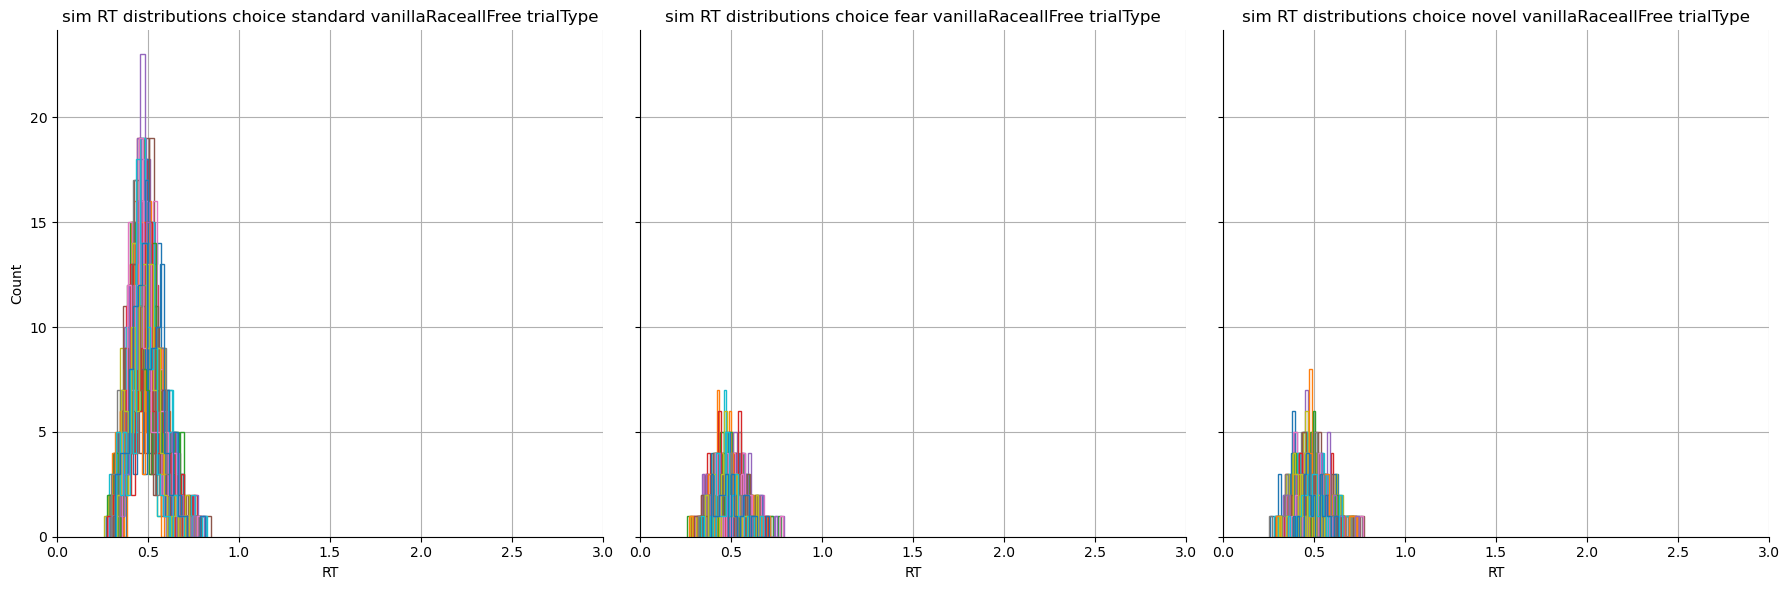

In [27]:
vanillaLBA_SingleSub_trialType_simData['rtPlot']=vanillaLBA_SingleSub_trialType_simData['rt']

# Filter data for each response type
dataResponse0 = vanillaLBA_SingleSub_trialType_simData.loc[vanillaLBA_SingleSub_trialType_simData['response'] == 0]
dataResponse1 = vanillaLBA_SingleSub_trialType_simData.loc[vanillaLBA_SingleSub_trialType_simData['response'] == 1]
dataResponse2 = vanillaLBA_SingleSub_trialType_simData.loc[vanillaLBA_SingleSub_trialType_simData['response'] == 2]

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot for response == 0
for i, subj_data in dataResponse0.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[0])
axes[0].set_title('sim RT distributions choice standard vanillaRaceallFree trialType')
axes[0].set_xlabel('RT')
axes[0].set_ylabel('Count')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].set_xlim(0, 3)

# Plot for response == 1
for i, subj_data in dataResponse1.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[1])
axes[1].set_title('sim RT distributions choice fear vanillaRaceallFree trialType')
axes[1].set_xlabel('RT')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].set_xlim(0, 3)

# Plot for response == 2
for i, subj_data in dataResponse2.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[2])
axes[2].set_title('sim RT distributions choice novel vanillaRaceallFree trialType')
axes[2].set_xlabel('RT')
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)
axes[2].set_xlim(0, 3)

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig(basepath + '/figures/sim_subRT_dist_all_choices_vanillaRaceallFree_trialType.pdf')


In [22]:
simple_LBA_model_hier_all_noPrior_simData_trialType = hssm.HSSM(
    data=vanillaLBA_SingleSub_trialType_simData,
    model="lba3",
    choices = [0,1,2],
    hierarchical=True,
    noncentered=False,
    loglik_kind="analytical",
    include=[
        {
            "name": "v0",
            "formula": "v0 ~ 1 + (1|participant_id)+(dummyV0|participant_id)",
            "link": "identity",
        },
        {
            "name": "v1",
            "formula": "v1 ~ 1 + (1|participant_id)+(dummyV1|participant_id)",
            "link": "identity",
        },
        {
            "name": "v2",
            "formula": "v2 ~ 1 + (1|participant_id)+(dummyV2|participant_id)",
            "link": "identity",
        }]
    )





Model initialized successfully.


In [23]:
pathlib.Path(basepath+'/models/lba/sept24/numpyro/').mkdir(parents=True, exist_ok=True)

inferenceData_simple_LBA_model_hier_all_noPrior=simple_LBA_model_hier_all_noPrior_simData_trialType.sample(
    sampler="nuts_numpyro",
    chains=2,
    cores=1,
    draws=3000,
    tune=2000,
    discard_tuned_samples=False,
    idata_kwargs=dict(log_likelihood=False),)

Using default initvals. 



2024-09-05 11:55:37.717326: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.68). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/pymc/sampling/jax.py:451: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/jax/_src/numpy/array_methods

In [24]:
fileName = basepath + '/models/lba/sept24/numpyro/inferenceData_sim_trialType_simple_LBA_model_hier_all_noPrior.nc'
data = inferenceData_simple_LBA_model_hier_all_noPrior
az.to_netcdf(data, fileName)

'/users/afengler/data/proj_tt/mpib-HSSM-oddball-data/models/lba/sept24/numpyro/inferenceData_sim_trialType_simple_LBA_model_hier_all_noPrior.nc'

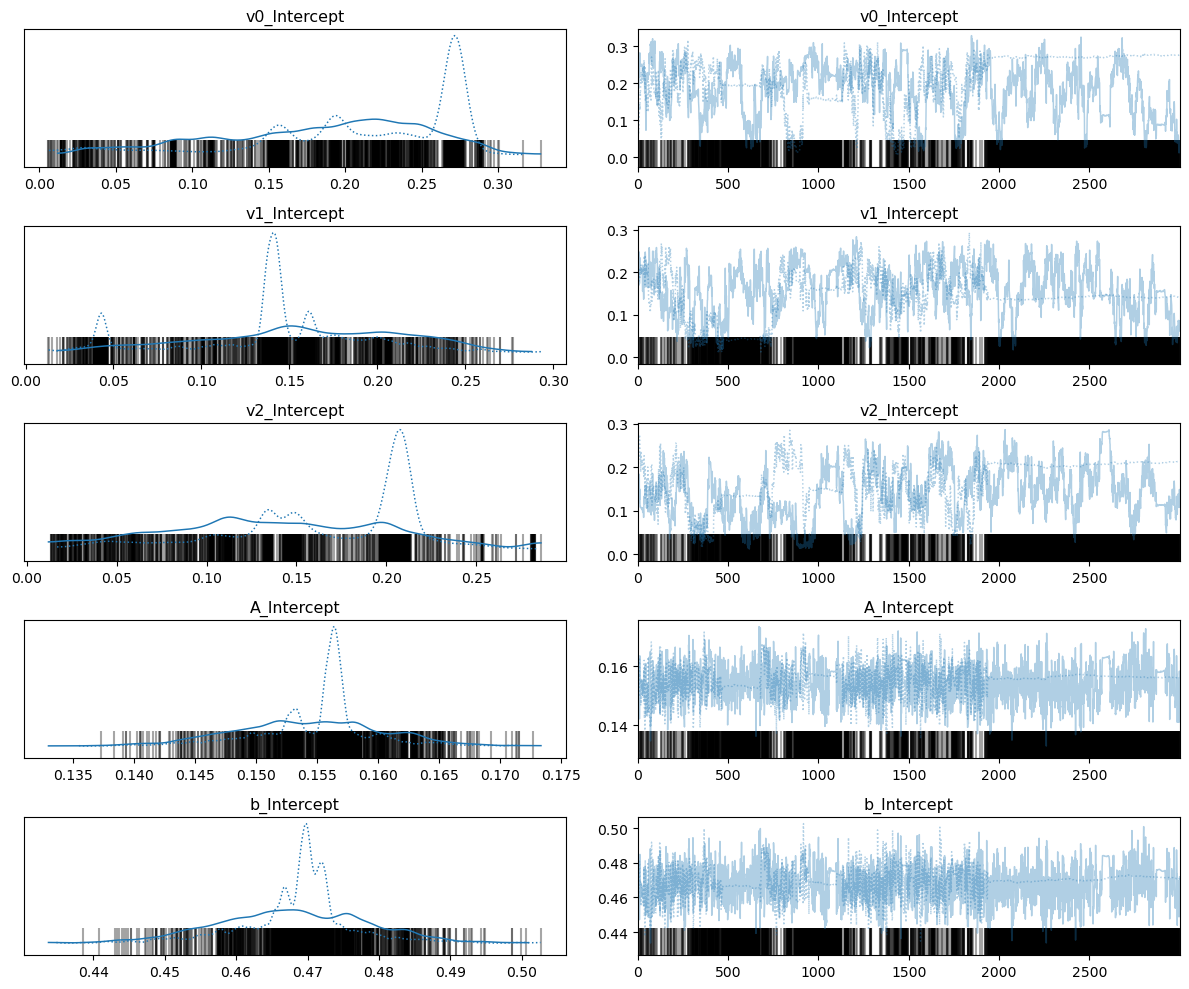

In [25]:
az.plot_trace(
    simple_LBA_model_hier_all_noPrior_simData_trialType.traces,var_names=['v0_Intercept','v1_Intercept',
                                                               'v2_Intercept', 'A_Intercept',
                                                               'b_Intercept']
)
plt.tight_layout()

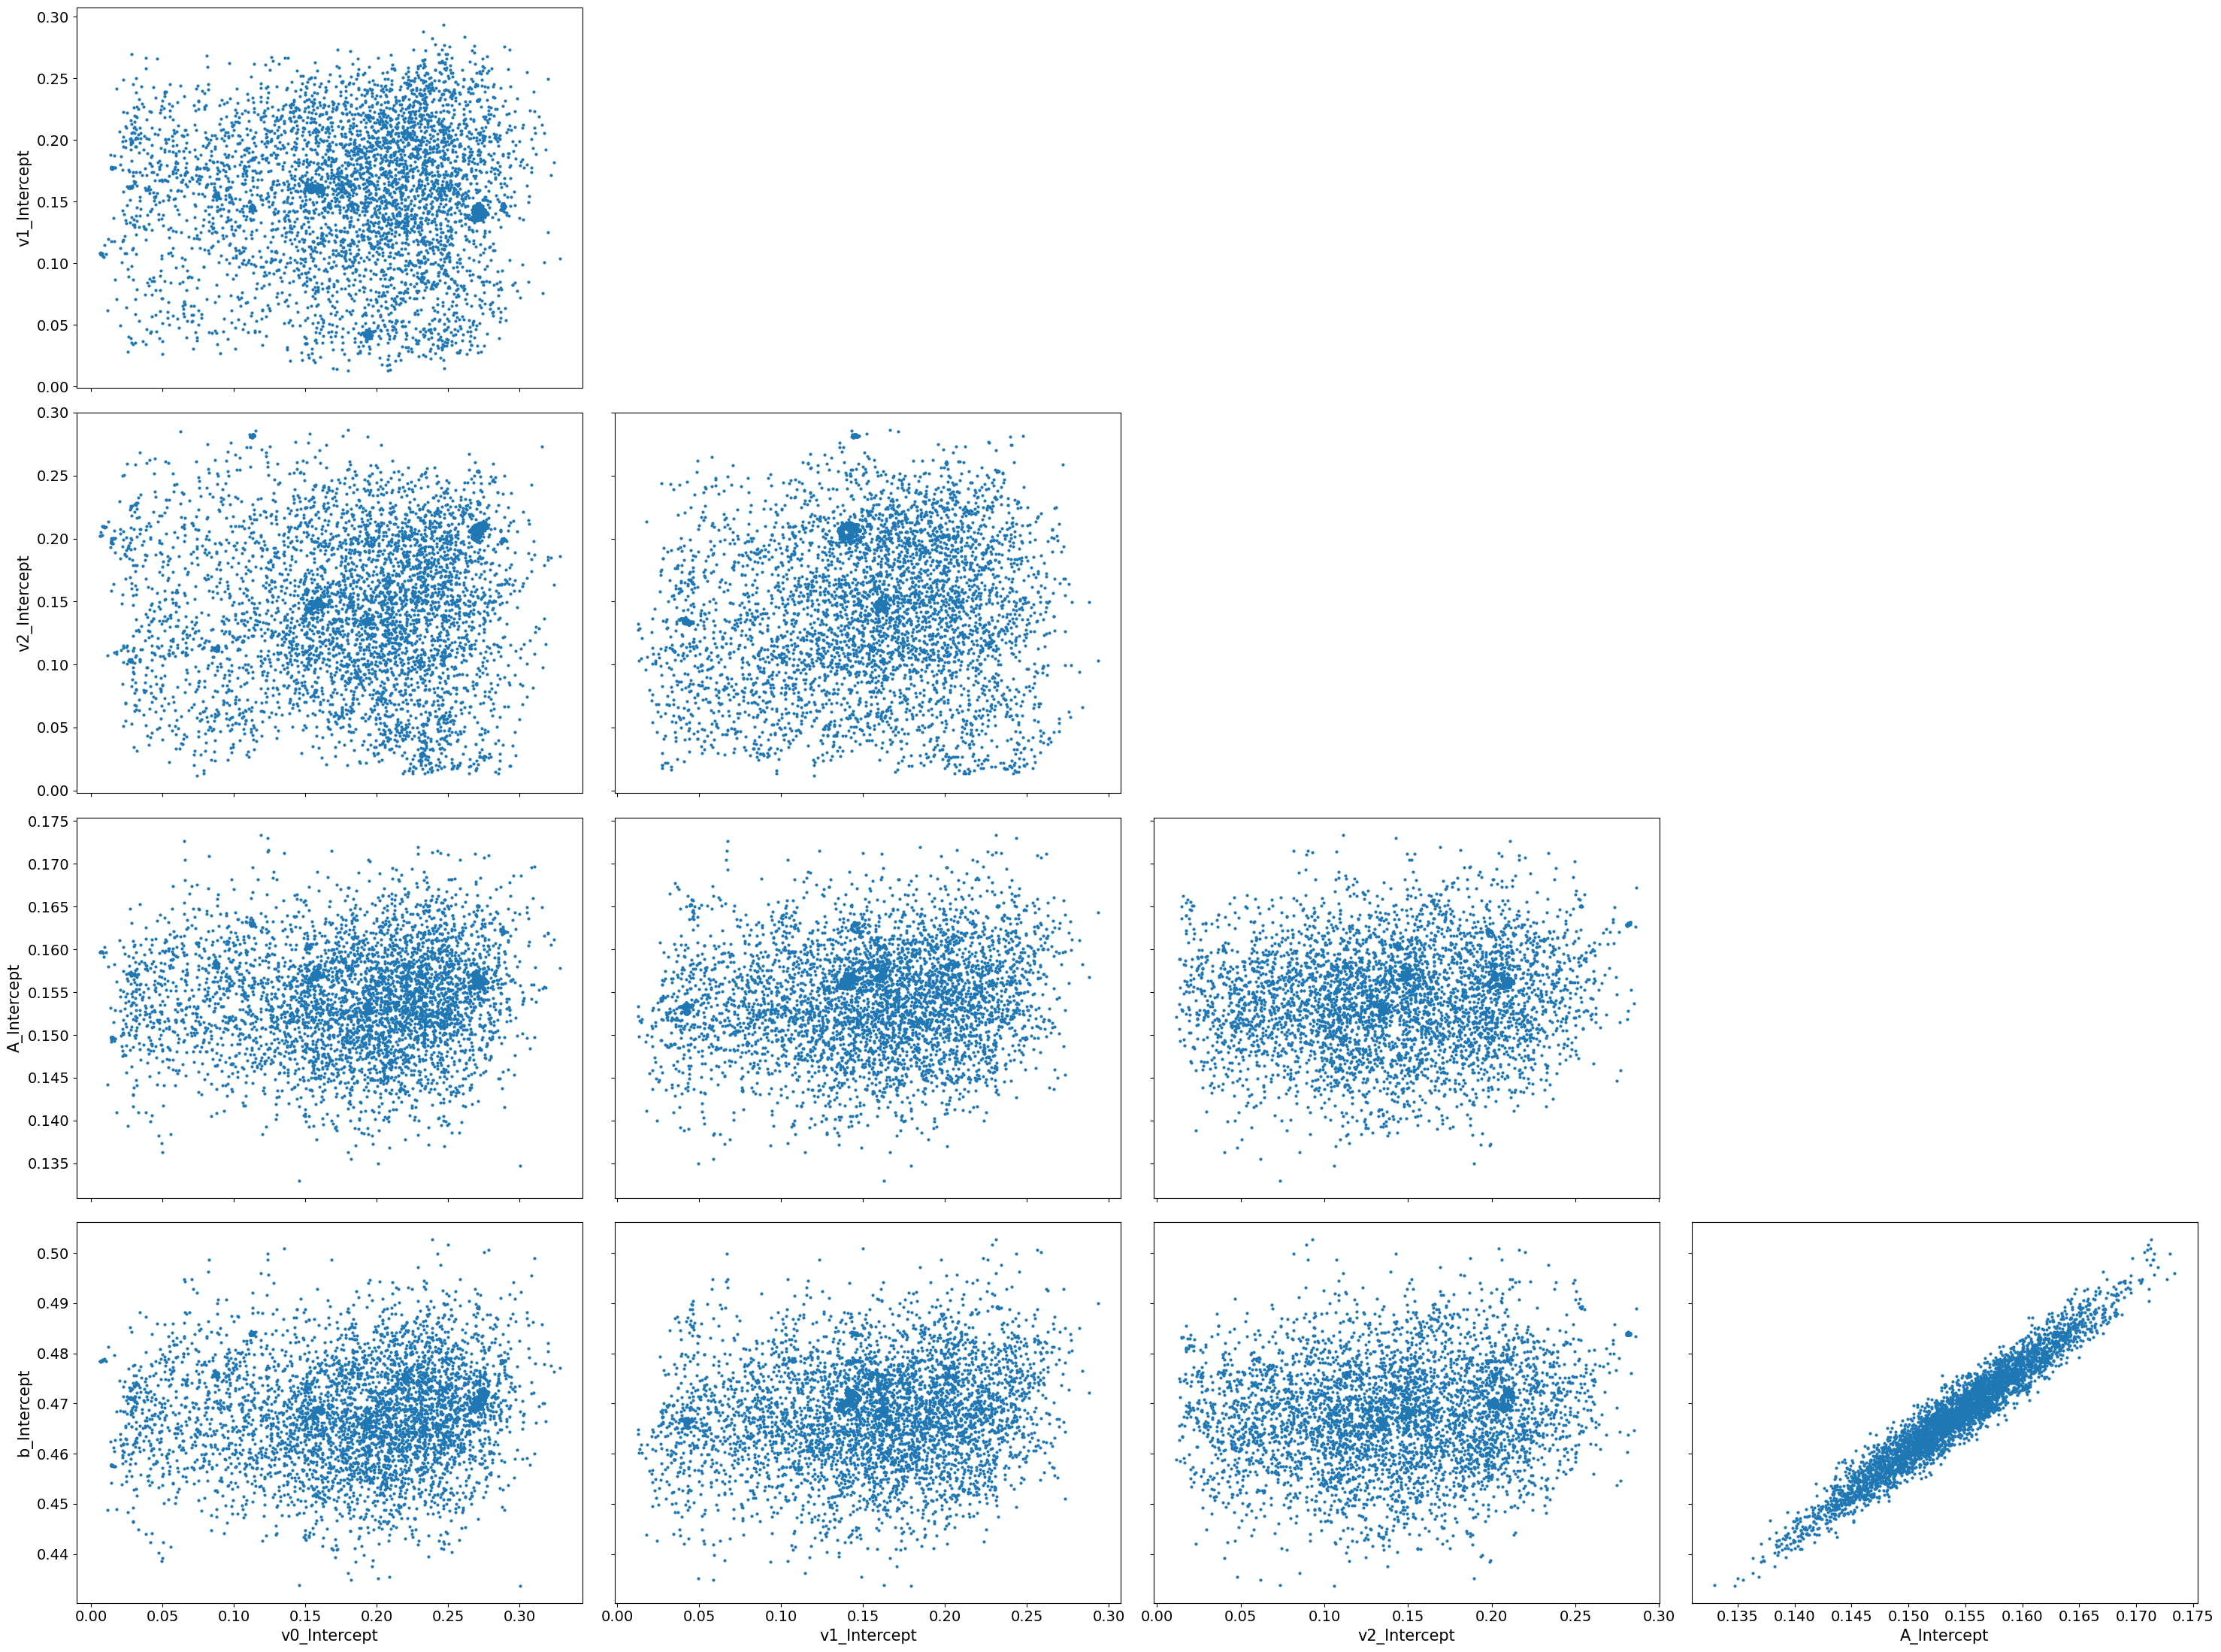

In [26]:
az.plot_pair(
    simple_LBA_model_hier_all_noPrior_simData_trialType.traces,var_names=['v0_Intercept','v1_Intercept',
                                                               'v2_Intercept', 'A_Intercept',
                                                               'b_Intercept']
)
plt.tight_layout()

In [27]:
az.summary(simple_LBA_model_hier_all_noPrior_simData_trialType.traces,var_names=['v0_Intercept','v1_Intercept',
                                                               'v2_Intercept', 'A_Intercept',
                                                               'b_Intercept'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
v0_Intercept  0.198  0.069   0.053    0.290      0.023    0.019       8.0   
v1_Intercept  0.150  0.054   0.039    0.242      0.009    0.006      44.0   
v2_Intercept  0.153  0.058   0.036    0.241      0.016    0.012      14.0   
A_Intercept   0.155  0.005   0.143    0.164      0.000    0.000     370.0   
b_Intercept   0.468  0.009   0.449    0.486      0.000    0.000     394.0   

              ess_tail  r_hat  
v0_Intercept     179.0   1.18  
v1_Intercept      44.0   1.18  
v2_Intercept     120.0   1.12  
A_Intercept      908.0   1.16  
b_Intercept      783.0   1.11

# no hier all subs

In [22]:
fileName = basepath + '/models/lba/sept24/numpyro/inferenceData_simple_LBA_model_noHier.nc'
lba_inferenceData_noHier=az.from_netcdf(fileName)
lba_inferenceData_noHier

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/arviz/stats/density_utils.py:981: RuntimeWarning: divide by zero encountered in divide
  hist_dens = hist / (hist.sum() * np.diff(bin_edges))
/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/arviz/stats/density_utils.py:981: RuntimeWarning: invalid value encountered in divide
  hist_dens = hist / (hist.sum() * np.diff(bin_edges))
/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/arviz/stats/density_utils.py:700: RuntimeWarning: divide by zero encountered in divide
  f = grid_counts / bin_width / len(x)
/users/afengler/data/software/miniconda3/envs/hssm_gpyou/li

OverflowError: cannot convert float infinity to integer

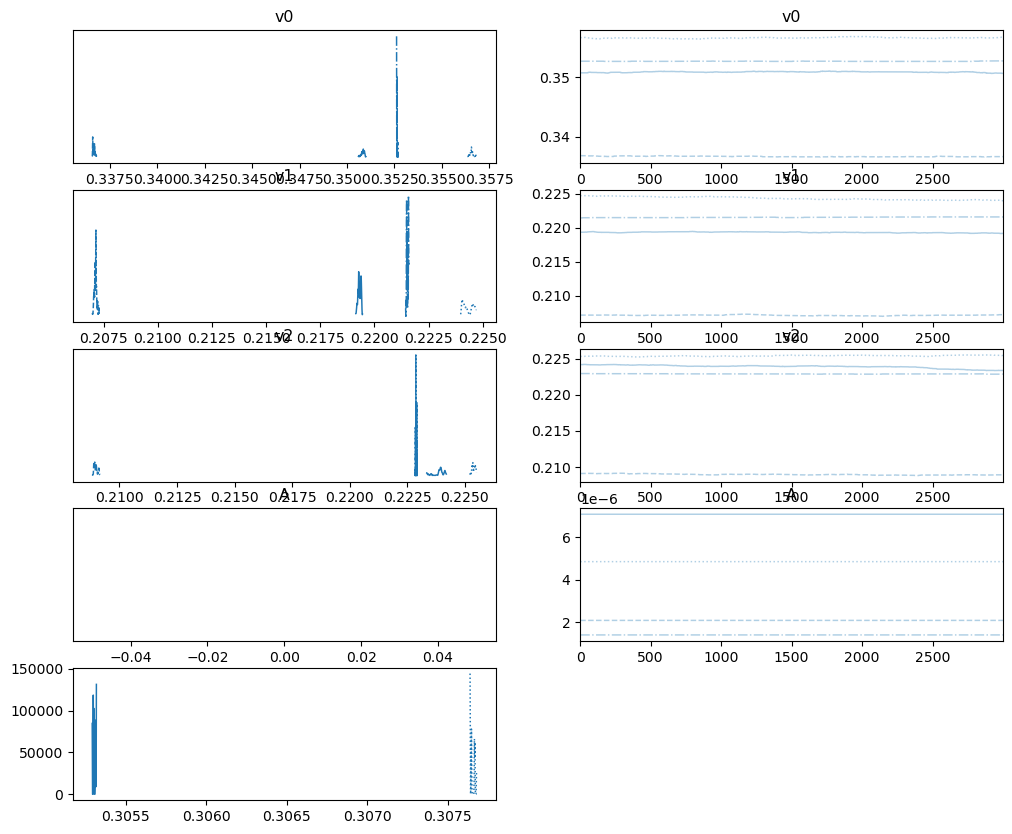

In [25]:
az.plot_trace(
    lba_inferenceData_noHier,var_names=['v0','v1','v2','A','b']
)
plt.tight_layout()

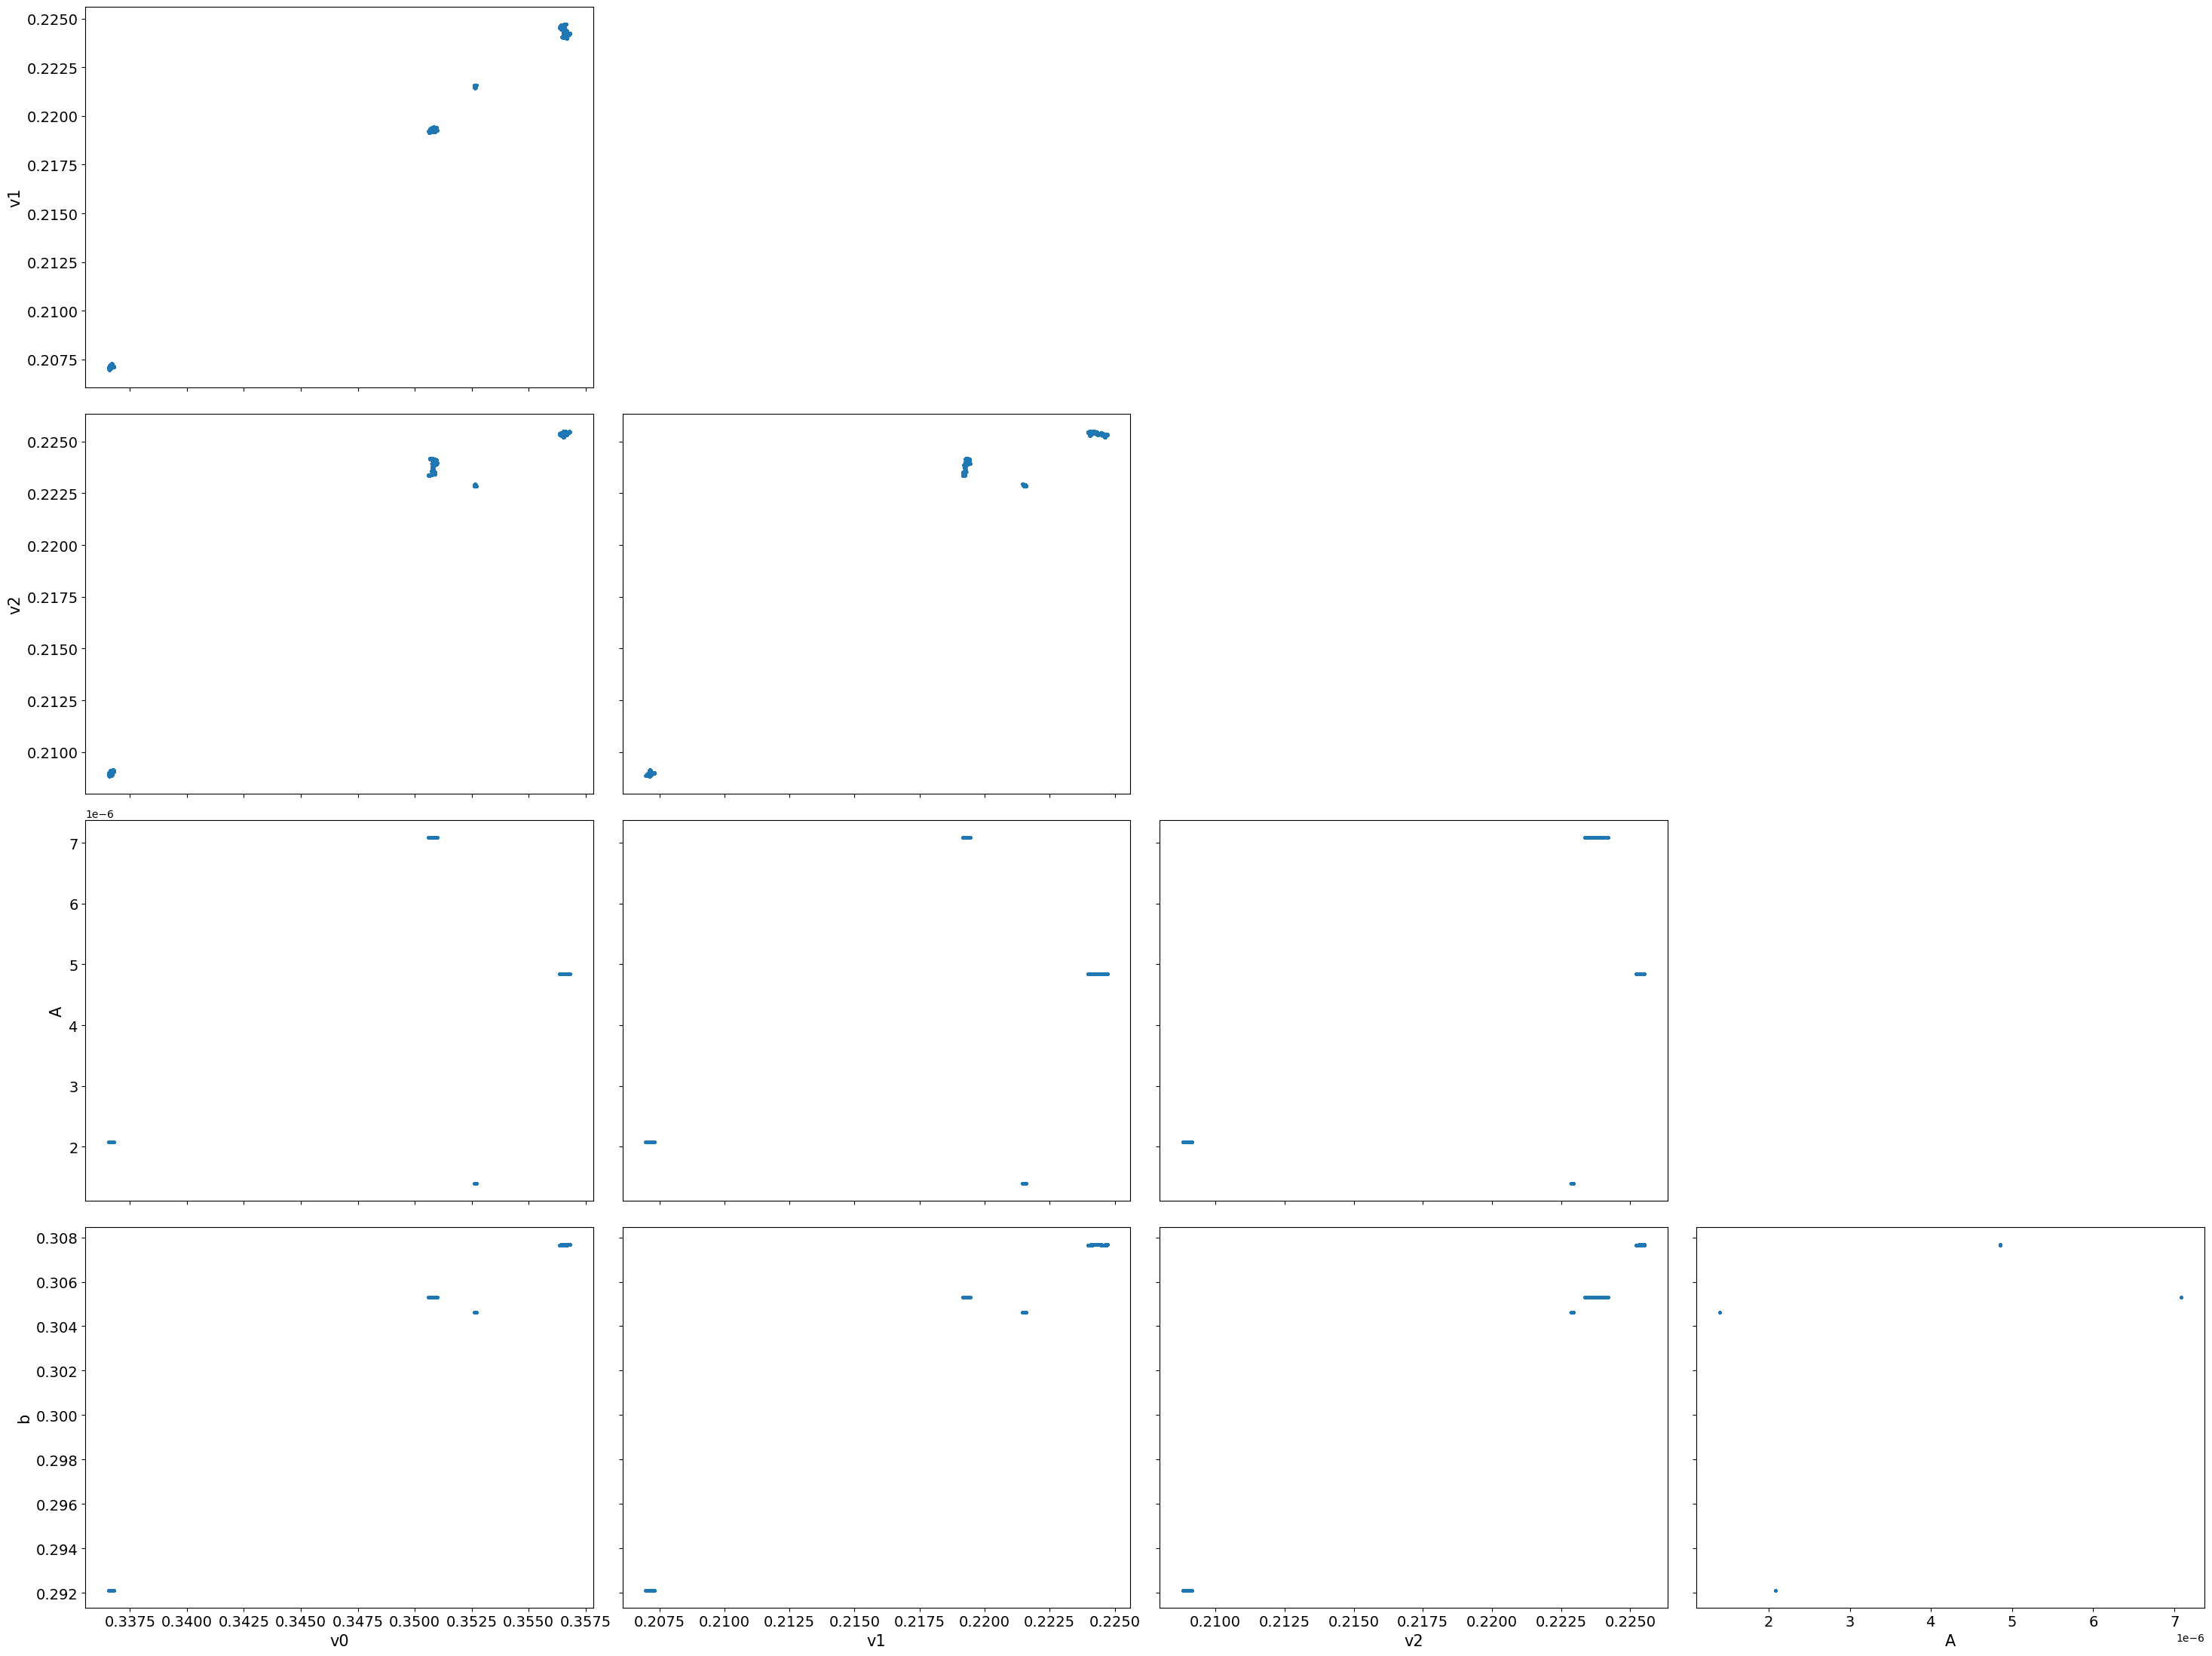

In [24]:
az.plot_pair(
    lba_inferenceData_noHier,var_names=['v0','v1','v2','A','b']
)
plt.tight_layout()

# check single sub data

In [12]:
subID = day2SubList[0]
fileName = basepath + '/models/lba/sept24/numpyro/singleSub/' + str(subID) + '/inferenceData_lba_simple_allFree' + str(subID) + '.nc'
lba_inferenceData_singleSub = az.from_netcdf(fileName)
lba_inferenceData_singleSub 

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [16]:
skipped_subjects_traces = []
for subNum in range(70, 71):
    try:
        subID = day2SubList[subNum]
        fileName = basepath + '/models/lba/sept24/numpyro/singleSub/' + str(subID) + '/inferenceData_lba_simple_allFree' + str(subID) + '.nc'
        lba_inferenceData_singleSub = az.from_netcdf(fileName)

        # Plotting trace
        az.plot_trace(lba_inferenceData_singleSub, var_names=["v0", "v1", "v2", "A", "b"])
        plt.tight_layout()
        
        # Saving the plot
        plt.savefig(basepath + '/models/lba/sept24/numpyro/singleSub/' + str(subID) + '/singleSub_traces_' + str(subID) + '.jpg')
        
        # Close the plot to prevent it from displaying
        plt.close()

    except OverflowError as e:
        print(f"Skipping subID {subID}: {e}")
        skipped_subjects_traces.append(subID)
         # Close the plot to prevent it from displaying
        plt.close()
    except Exception as e:
        print(f"An unexpected error occurred for subID {subID}: {e}")
         # Close the plot to prevent it from displaying
        skipped_subjects_traces.append(subID)
        plt.close()

In [14]:
print("Skipped subjects for trace plots:", skipped_subjects_traces)


Skipped subjects for trace plots: []


In [17]:
skipped_subjects_pair = []
for subNum in range(70, 71):
    try:
        subID = day2SubList[subNum]
        fileName = basepath + '/models/lba/sept24/numpyro/singleSub/' + str(subID) + '/inferenceData_lba_simple_allFree' + str(subID) + '.nc'
        race_inferenceData_singleSub = az.from_netcdf(fileName)
        
        # Plotting posterior pair
        az.plot_pair(race_inferenceData_singleSub,var_names=["v0", "v1", "v2", "A", "b"])
        plt.tight_layout()
        
        # Saving the plot
        plt.savefig(basepath + '/models/lba/sept24/numpyro/singleSub/' + str(subID) + '/singleSub_posteriorPair_' + str(subID) + '.jpg')
        
        # Close the plot to prevent it from displaying
        plt.close()

    except OverflowError as e:
        print(f"Skipping subID {subID}: {e}")
        skipped_subjects_pair.append(subID)
    except Exception as e:
        print(f"An unexpected error occurred for subID {subID}: {e}")
        skipped_subjects_pair.append(subID)

In [ ]:
print("Skipped subjects for pair plots:", skipped_subjects_pair)

Skipped subjects for pair plots: []


## look at specific sub data based on inference results

### kinda good subs

#### loop

In [12]:
subIDs = [42033]

for s in range(len(subIDs)):
        subID=subIDs[s]
        print(subID)

        subAllData=oddballDataDay2Choice[oddballDataDay2Choice.participant_id==subID]

        # Filter data for each response type
        dataResponse0 = subAllData.loc[subAllData['response'] == 0]
        dataResponse1 = subAllData.loc[subAllData['response'] == 1]
        dataResponse2 = subAllData.loc[subAllData['response'] == 2]

        # Create a figure with three subplots
        fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

        # Plot for response == 0
        for i, subj_data in dataResponse0.groupby('participant_id'):
            subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[0])
            axes[0].set_title('real RT distributions choice standard raw sub:'+ str(subID))
            axes[0].set_xlabel('RT')
            axes[0].set_ylabel('Count')
            axes[0].spines['top'].set_visible(False)
            axes[0].spines['right'].set_visible(False)
            axes[0].set_xlim(0, 3)

        # Plot for response == 1
        for i, subj_data in dataResponse1.groupby('participant_id'):
            subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[1])
            axes[1].set_title('real RT distributions choice fear raw sub:'+ str(subID))
            axes[1].set_xlabel('RT')
            axes[1].spines['top'].set_visible(False)
            axes[1].spines['right'].set_visible(False)
            axes[1].set_xlim(0, 3)

        # Plot for response == 2
        for i, subj_data in dataResponse2.groupby('participant_id'):
            subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[2])
            axes[2].set_title('real RT distributions choice novel raw sub:'+ str(subID))
            axes[2].set_xlabel('RT')
            axes[2].spines['top'].set_visible(False)
            axes[2].spines['right'].set_visible(False)
            axes[2].set_xlim(0, 3)

        # Adjust layout
        plt.tight_layout()

        # Save the figure
        plt.savefig(basepath + '/models/lba/sept24/numpyro/singleSub/' + str(subID) + '/choiceRT_dist_plot_' + str(subID) + '.jpg')
        

        # Close the plot to prevent it from displaying
        plt.close()

    

42033


#### big panel plot

Processing subject 42033


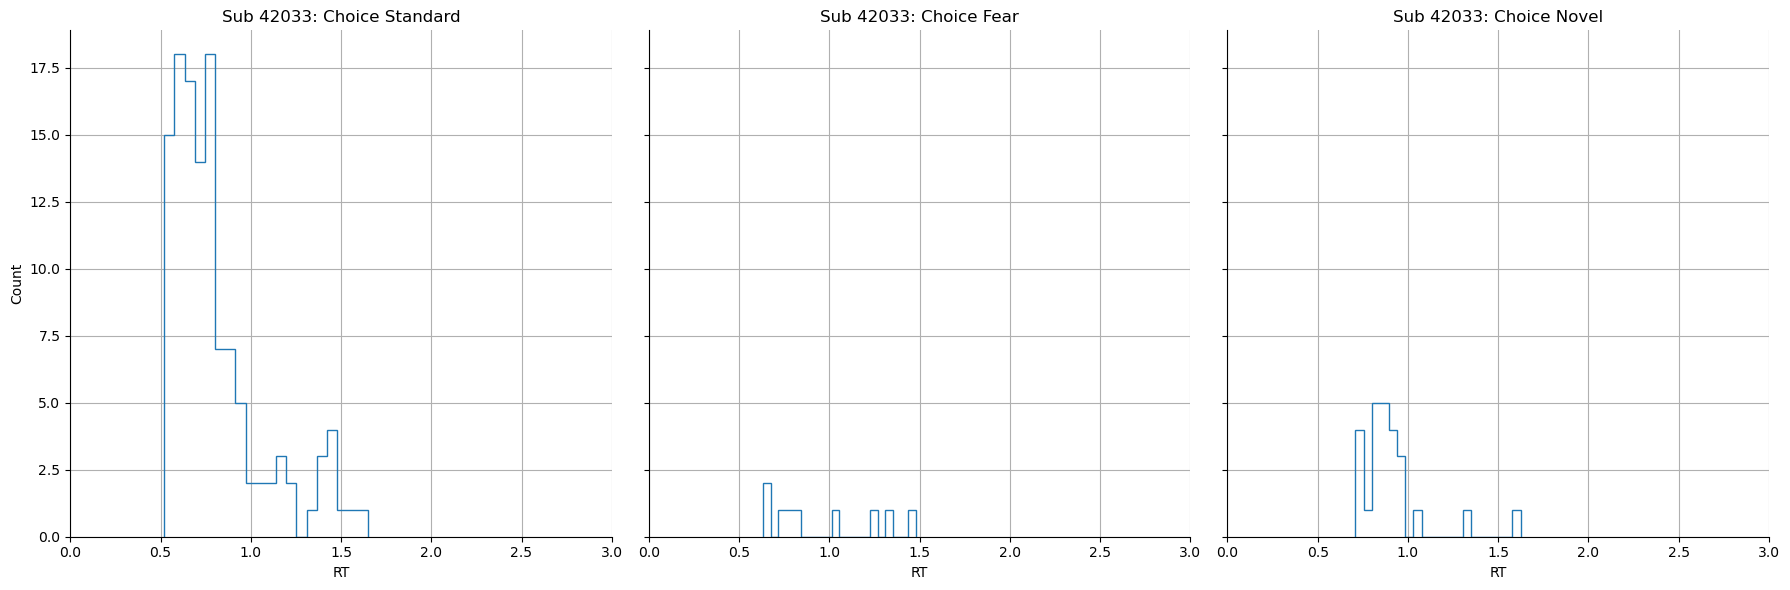

In [20]:
# List of subject IDs
subIDs = [42033]

n_subs = len(subIDs)
n_responses = 3  # 3 response types

# Create a figure with a grid of subplots, 3 columns for each response, and one row per subject
fig, axes = plt.subplots(n_subs, n_responses, figsize=(18, 6 * n_subs), sharey=True)

# Flatten the axes to make it easier to index
axes = axes.reshape(n_subs, n_responses)


for s in range(n_subs):
    subID = subIDs[s]
    print(f"Processing subject {subID}")

    # Extract data for the current subject
    subAllData = oddballDataDay2Choice[oddballDataDay2Choice.participant_id == subID]

    # Filter data for each response type
    dataResponse0 = subAllData.loc[subAllData['response'] == 0]
    dataResponse1 = subAllData.loc[subAllData['response'] == 1]
    dataResponse2 = subAllData.loc[subAllData['response'] == 2]

    trace_color = 'green' if s % 2 == 1 else None
    # Alternate row background color
    
    
    # Plot for response == 0
    for i, subj_data in dataResponse0.groupby('participant_id'):
        subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[s, 0], color=trace_color)
        axes[s, 0].set_title(f'Sub {subID}: Choice Standard')
        axes[s, 0].set_xlabel('RT')
        axes[s, 0].set_ylabel('Count')
        axes[s, 0].spines['top'].set_visible(False)
        axes[s, 0].spines['right'].set_visible(False)
        axes[s, 0].set_xlim(0, 3)

    # Plot for response == 1
    for i, subj_data in dataResponse1.groupby('participant_id'):
        subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[s, 1], color=trace_color)
        axes[s, 1].set_title(f'Sub {subID}: Choice Fear')
        axes[s, 1].set_xlabel('RT')
        axes[s, 1].spines['top'].set_visible(False)
        axes[s, 1].spines['right'].set_visible(False)
        axes[s, 1].set_xlim(0, 3)

    # Plot for response == 2
    for i, subj_data in dataResponse2.groupby('participant_id'):
        subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[s, 2], color=trace_color)
        axes[s, 2].set_title(f'Sub {subID}: Choice Novel')
        axes[s, 2].set_xlabel('RT')
        axes[s, 2].spines['top'].set_visible(False)
        axes[s, 2].spines['right'].set_visible(False)
        axes[s, 2].set_xlim(0, 3)

# Adjust layout to avoid overlapping
plt.tight_layout()

# Save the entire panel figure
plt.savefig(basepath + '/models/lba/sept24/numpyro/kindaGoodSubs_RT_dist_plots_combined.jpg')



### better subs

#### loop

In [1]:
subIDs = [42023, 42043, 42063, 42073, 42133, 42143, 42173, 42253, 42263, 42283, 
    42303, 42343, 42363, 42393, 42403, 62063, 62113, 62123, 62143, 62193, 
    62253, 62283, 62293, 62303, 62333, 62423, 62443]

In [3]:
len(subIDs)

27

In [14]:
subIDs = [42023, 42043, 42063, 42073, 42133, 42143, 42173, 42253, 42263, 42283, 
    42303, 42343, 42363, 42393, 42403, 62063, 62113, 62123, 62143, 62193, 
    62253, 62283, 62293, 62303, 62333, 62423, 62443]

for s in range(len(subIDs)):
        subID=subIDs[s]
        print(subID)

        subAllData=oddballDataDay2Choice[oddballDataDay2Choice.participant_id==subID]

        # Filter data for each response type
        dataResponse0 = subAllData.loc[subAllData['response'] == 0]
        dataResponse1 = subAllData.loc[subAllData['response'] == 1]
        dataResponse2 = subAllData.loc[subAllData['response'] == 2]

        # Create a figure with three subplots
        fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

        # Plot for response == 0
        for i, subj_data in dataResponse0.groupby('participant_id'):
            subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[0])
            axes[0].set_title('real RT distributions choice standard raw sub:'+ str(subID))
            axes[0].set_xlabel('RT')
            axes[0].set_ylabel('Count')
            axes[0].spines['top'].set_visible(False)
            axes[0].spines['right'].set_visible(False)
            axes[0].set_xlim(0, 3)

        # Plot for response == 1
        for i, subj_data in dataResponse1.groupby('participant_id'):
            subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[1])
            axes[1].set_title('real RT distributions choice fear raw sub:'+ str(subID))
            axes[1].set_xlabel('RT')
            axes[1].spines['top'].set_visible(False)
            axes[1].spines['right'].set_visible(False)
            axes[1].set_xlim(0, 3)

        # Plot for response == 2
        for i, subj_data in dataResponse2.groupby('participant_id'):
            subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[2])
            axes[2].set_title('real RT distributions choice novel raw sub:'+ str(subID))
            axes[2].set_xlabel('RT')
            axes[2].spines['top'].set_visible(False)
            axes[2].spines['right'].set_visible(False)
            axes[2].set_xlim(0, 3)

        # Adjust layout
        plt.tight_layout()

        # Save the figure
        plt.savefig(basepath + '/models/lba/sept24/numpyro/singleSub/' + str(subID) + '/choiceRT_dist_plot_' + str(subID) + '.jpg')
        

        # Close the plot to prevent it from displaying
        plt.close()

    

42023
42043
42063
42073
42133
42143
42173
42253
42263
42283
42303
42343
42363
42393
42403
62063
62113
62123
62143
62193
62253
62283
62293
62303
62333
62423
62443


#### big panel plot

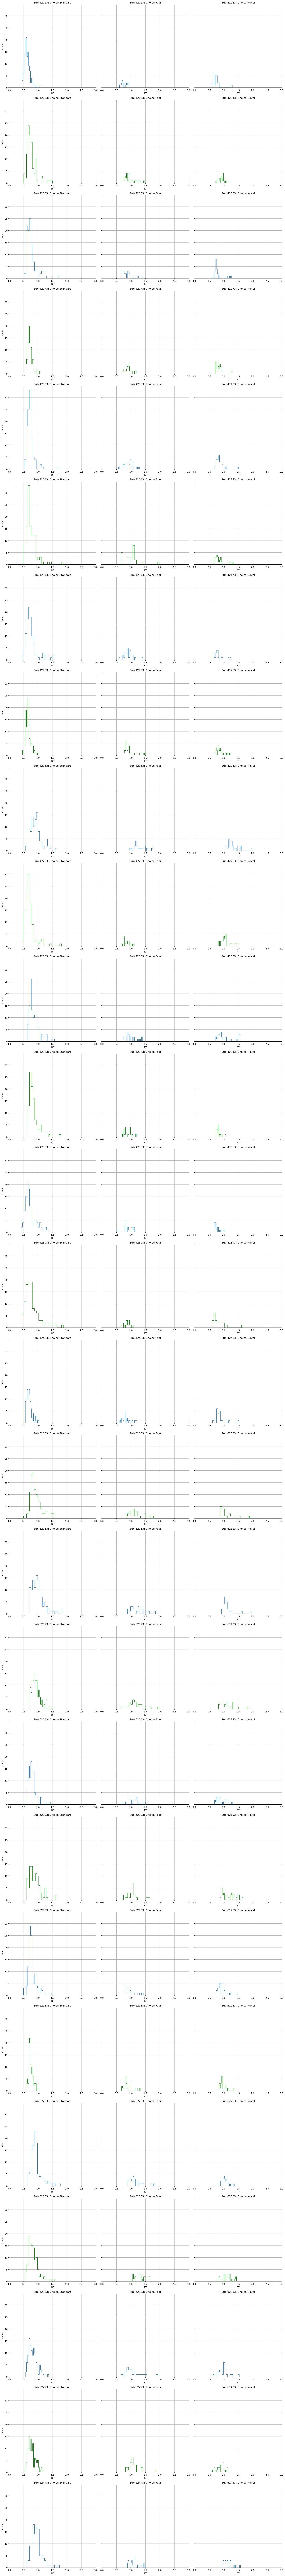

In [15]:

subIDs = [42023, 42043, 42063, 42073, 42133, 42143, 42173, 42253, 42263, 42283, 
    42303, 42343, 42363, 42393, 42403, 62063, 62113, 62123, 62143, 62193, 
    62253, 62283, 62293, 62303, 62333, 62423, 62443]

n_subs = len(subIDs)
n_responses = 3  # 3 response types

# Create a figure with a grid of subplots, 3 columns for each response, and one row per subject
fig, axes = plt.subplots(n_subs, n_responses, figsize=(18, 6 * n_subs), sharey=True)

# Flatten the axes to make it easier to index
axes = axes.reshape(n_subs, n_responses)


for s in range(n_subs):
    subID = subIDs[s]
    #print(f"Processing subject {subID}")

    # Extract data for the current subject
    subAllData = oddballDataDay2Choice[oddballDataDay2Choice.participant_id == subID]

    # Filter data for each response type
    dataResponse0 = subAllData.loc[subAllData['response'] == 0]
    dataResponse1 = subAllData.loc[subAllData['response'] == 1]
    dataResponse2 = subAllData.loc[subAllData['response'] == 2]

    trace_color = 'green' if s % 2 == 1 else None
    # Alternate row background color
    
    
    # Plot for response == 0
    for i, subj_data in dataResponse0.groupby('participant_id'):
        subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[s, 0], color=trace_color)
        axes[s, 0].set_title(f'Sub {subID}: Choice Standard')
        axes[s, 0].set_xlabel('RT')
        axes[s, 0].set_ylabel('Count')
        axes[s, 0].spines['top'].set_visible(False)
        axes[s, 0].spines['right'].set_visible(False)
        axes[s, 0].set_xlim(0, 3)

    # Plot for response == 1
    for i, subj_data in dataResponse1.groupby('participant_id'):
        subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[s, 1], color=trace_color)
        axes[s, 1].set_title(f'Sub {subID}: Choice Fear')
        axes[s, 1].set_xlabel('RT')
        axes[s, 1].spines['top'].set_visible(False)
        axes[s, 1].spines['right'].set_visible(False)
        axes[s, 1].set_xlim(0, 3)

    # Plot for response == 2
    for i, subj_data in dataResponse2.groupby('participant_id'):
        subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[s, 2], color=trace_color)
        axes[s, 2].set_title(f'Sub {subID}: Choice Novel')
        axes[s, 2].set_xlabel('RT')
        axes[s, 2].spines['top'].set_visible(False)
        axes[s, 2].spines['right'].set_visible(False)
        axes[s, 2].set_xlim(0, 3)

# Adjust layout to avoid overlapping
plt.tight_layout()

# Save the entire panel figure
plt.savefig(basepath + '/models/lba/sept24/numpyro/betterSubs_RT_dist_plots_combined.jpg')



### bad trade off subs

In [15]:
subIDs = [42013, 42053, 42103, 42123, 42153, 42163, 42183, 42233, 42273, 42293, 
    42313, 42323, 42353, 42373, 42383, 42413, 42423, 62013, 62023, 62043, 
    62073, 62093, 62103, 62133, 62163, 62173, 62213, 62233, 62263, 62273, 
    62313, 62343, 62363, 62373, 62393, 62413, 62433]
len(subIDs)

37

#### loop

In [16]:
subIDs = [42013, 42053, 42103, 42123, 42153, 42163, 42183, 42233, 42273, 42293, 
    42313, 42323, 42353, 42373, 42383, 42413, 42423, 62013, 62023, 62043, 
    62073, 62093, 62103, 62133, 62163, 62173, 62213, 62233, 62263, 62273, 
    62313, 62343, 62363, 62373, 62393, 62413, 62433]

for s in range(len(subIDs)):
        subID=subIDs[s]
        #print(subID)

        subAllData=oddballDataDay2Choice[oddballDataDay2Choice.participant_id==subID]

        # Filter data for each response type
        dataResponse0 = subAllData.loc[subAllData['response'] == 0]
        dataResponse1 = subAllData.loc[subAllData['response'] == 1]
        dataResponse2 = subAllData.loc[subAllData['response'] == 2]

        # Create a figure with three subplots
        fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

        # Plot for response == 0
        for i, subj_data in dataResponse0.groupby('participant_id'):
            subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[0])
            axes[0].set_title('real RT distributions choice standard raw sub:'+ str(subID))
            axes[0].set_xlabel('RT')
            axes[0].set_ylabel('Count')
            axes[0].spines['top'].set_visible(False)
            axes[0].spines['right'].set_visible(False)
            axes[0].set_xlim(0, 3)

        # Plot for response == 1
        for i, subj_data in dataResponse1.groupby('participant_id'):
            subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[1])
            axes[1].set_title('real RT distributions choice fear raw sub:'+ str(subID))
            axes[1].set_xlabel('RT')
            axes[1].spines['top'].set_visible(False)
            axes[1].spines['right'].set_visible(False)
            axes[1].set_xlim(0, 3)

        # Plot for response == 2
        for i, subj_data in dataResponse2.groupby('participant_id'):
            subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[2])
            axes[2].set_title('real RT distributions choice novel raw sub:'+ str(subID))
            axes[2].set_xlabel('RT')
            axes[2].spines['top'].set_visible(False)
            axes[2].spines['right'].set_visible(False)
            axes[2].set_xlim(0, 3)

        # Adjust layout
        plt.tight_layout()

        # Save the figure
        plt.savefig(basepath + '/models/lba/sept24/numpyro/singleSub/' + str(subID) + '/choiceRT_dist_plot_' + str(subID) + '.jpg')
        

        # Close the plot to prevent it from displaying
        plt.close()

    

#### big panel plot

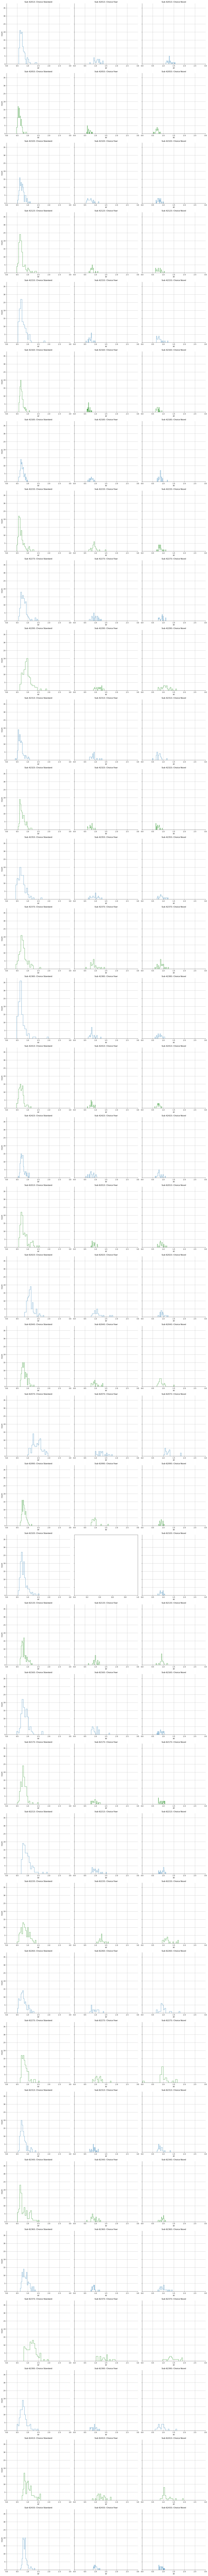

In [17]:
# List of subject IDs
subIDs = [42013, 42053, 42103, 42123, 42153, 42163, 42183, 42233, 42273, 42293, 
    42313, 42323, 42353, 42373, 42383, 42413, 42423, 62013, 62023, 62043, 
    62073, 62093, 62103, 62133, 62163, 62173, 62213, 62233, 62263, 62273, 
    62313, 62343, 62363, 62373, 62393, 62413, 62433]

n_subs = len(subIDs)
n_responses = 3  # 3 response types

# Create a figure with a grid of subplots, 3 columns for each response, and one row per subject
fig, axes = plt.subplots(n_subs, n_responses, figsize=(18, 6 * n_subs), sharey=True)

# Flatten the axes to make it easier to index
axes = axes.reshape(n_subs, n_responses)


for s in range(n_subs):
    subID = subIDs[s]
    #print(f"Processing subject {subID}")

    # Extract data for the current subject
    subAllData = oddballDataDay2Choice[oddballDataDay2Choice.participant_id == subID]

    # Filter data for each response type
    dataResponse0 = subAllData.loc[subAllData['response'] == 0]
    dataResponse1 = subAllData.loc[subAllData['response'] == 1]
    dataResponse2 = subAllData.loc[subAllData['response'] == 2]

    trace_color = 'green' if s % 2 == 1 else None
    # Alternate row background color
    
    
    # Plot for response == 0
    for i, subj_data in dataResponse0.groupby('participant_id'):
        subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[s, 0], color=trace_color)
        axes[s, 0].set_title(f'Sub {subID}: Choice Standard')
        axes[s, 0].set_xlabel('RT')
        axes[s, 0].set_ylabel('Count')
        axes[s, 0].spines['top'].set_visible(False)
        axes[s, 0].spines['right'].set_visible(False)
        axes[s, 0].set_xlim(0, 3)

    # Plot for response == 1
    for i, subj_data in dataResponse1.groupby('participant_id'):
        subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[s, 1], color=trace_color)
        axes[s, 1].set_title(f'Sub {subID}: Choice Fear')
        axes[s, 1].set_xlabel('RT')
        axes[s, 1].spines['top'].set_visible(False)
        axes[s, 1].spines['right'].set_visible(False)
        axes[s, 1].set_xlim(0, 3)

    # Plot for response == 2
    for i, subj_data in dataResponse2.groupby('participant_id'):
        subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[s, 2], color=trace_color)
        axes[s, 2].set_title(f'Sub {subID}: Choice Novel')
        axes[s, 2].set_xlabel('RT')
        axes[s, 2].spines['top'].set_visible(False)
        axes[s, 2].spines['right'].set_visible(False)
        axes[s, 2].set_xlim(0, 3)

# Adjust layout to avoid overlapping
plt.tight_layout()

# Save the entire panel figure
plt.savefig(basepath + '/models/lba/sept24/numpyro/badTradeOffSubs_RT_dist_plots_combined.jpg')



### weird posterior dist?

In [16]:
subIDs = [42083, 42203, 42213, 62153, 62253, 62323, 62403]
len(subIDs)

7

#### loop

In [18]:
subIDs = [42083, 42203, 42213, 62153, 62253, 62323, 62403]

for s in range(len(subIDs)):
        subID=subIDs[s]
        print(subID)

        subAllData=oddballDataDay2Choice[oddballDataDay2Choice.participant_id==subID]

        # Filter data for each response type
        dataResponse0 = subAllData.loc[subAllData['response'] == 0]
        dataResponse1 = subAllData.loc[subAllData['response'] == 1]
        dataResponse2 = subAllData.loc[subAllData['response'] == 2]

        # Create a figure with three subplots
        fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

        # Plot for response == 0
        for i, subj_data in dataResponse0.groupby('participant_id'):
            subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[0])
            axes[0].set_title('real RT distributions choice standard raw sub:'+ str(subID))
            axes[0].set_xlabel('RT')
            axes[0].set_ylabel('Count')
            axes[0].spines['top'].set_visible(False)
            axes[0].spines['right'].set_visible(False)
            axes[0].set_xlim(0, 3)

        # Plot for response == 1
        for i, subj_data in dataResponse1.groupby('participant_id'):
            subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[1])
            axes[1].set_title('real RT distributions choice fear raw sub:'+ str(subID))
            axes[1].set_xlabel('RT')
            axes[1].spines['top'].set_visible(False)
            axes[1].spines['right'].set_visible(False)
            axes[1].set_xlim(0, 3)

        # Plot for response == 2
        for i, subj_data in dataResponse2.groupby('participant_id'):
            subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[2])
            axes[2].set_title('real RT distributions choice novel raw sub:'+ str(subID))
            axes[2].set_xlabel('RT')
            axes[2].spines['top'].set_visible(False)
            axes[2].spines['right'].set_visible(False)
            axes[2].set_xlim(0, 3)

        # Adjust layout
        plt.tight_layout()

        # Save the figure
        plt.savefig(basepath + '/models/lba/sept24/numpyro/singleSub/' + str(subID) + '/choiceRT_dist_plot_' + str(subID) + '.jpg')
        

        # Close the plot to prevent it from displaying
        plt.close()

    

42083
42203
42213
62153
62253
62323
62403


#### big panel plot

Processing subject 42083
Processing subject 42203
Processing subject 42213
Processing subject 62153
Processing subject 62253
Processing subject 62323
Processing subject 62403


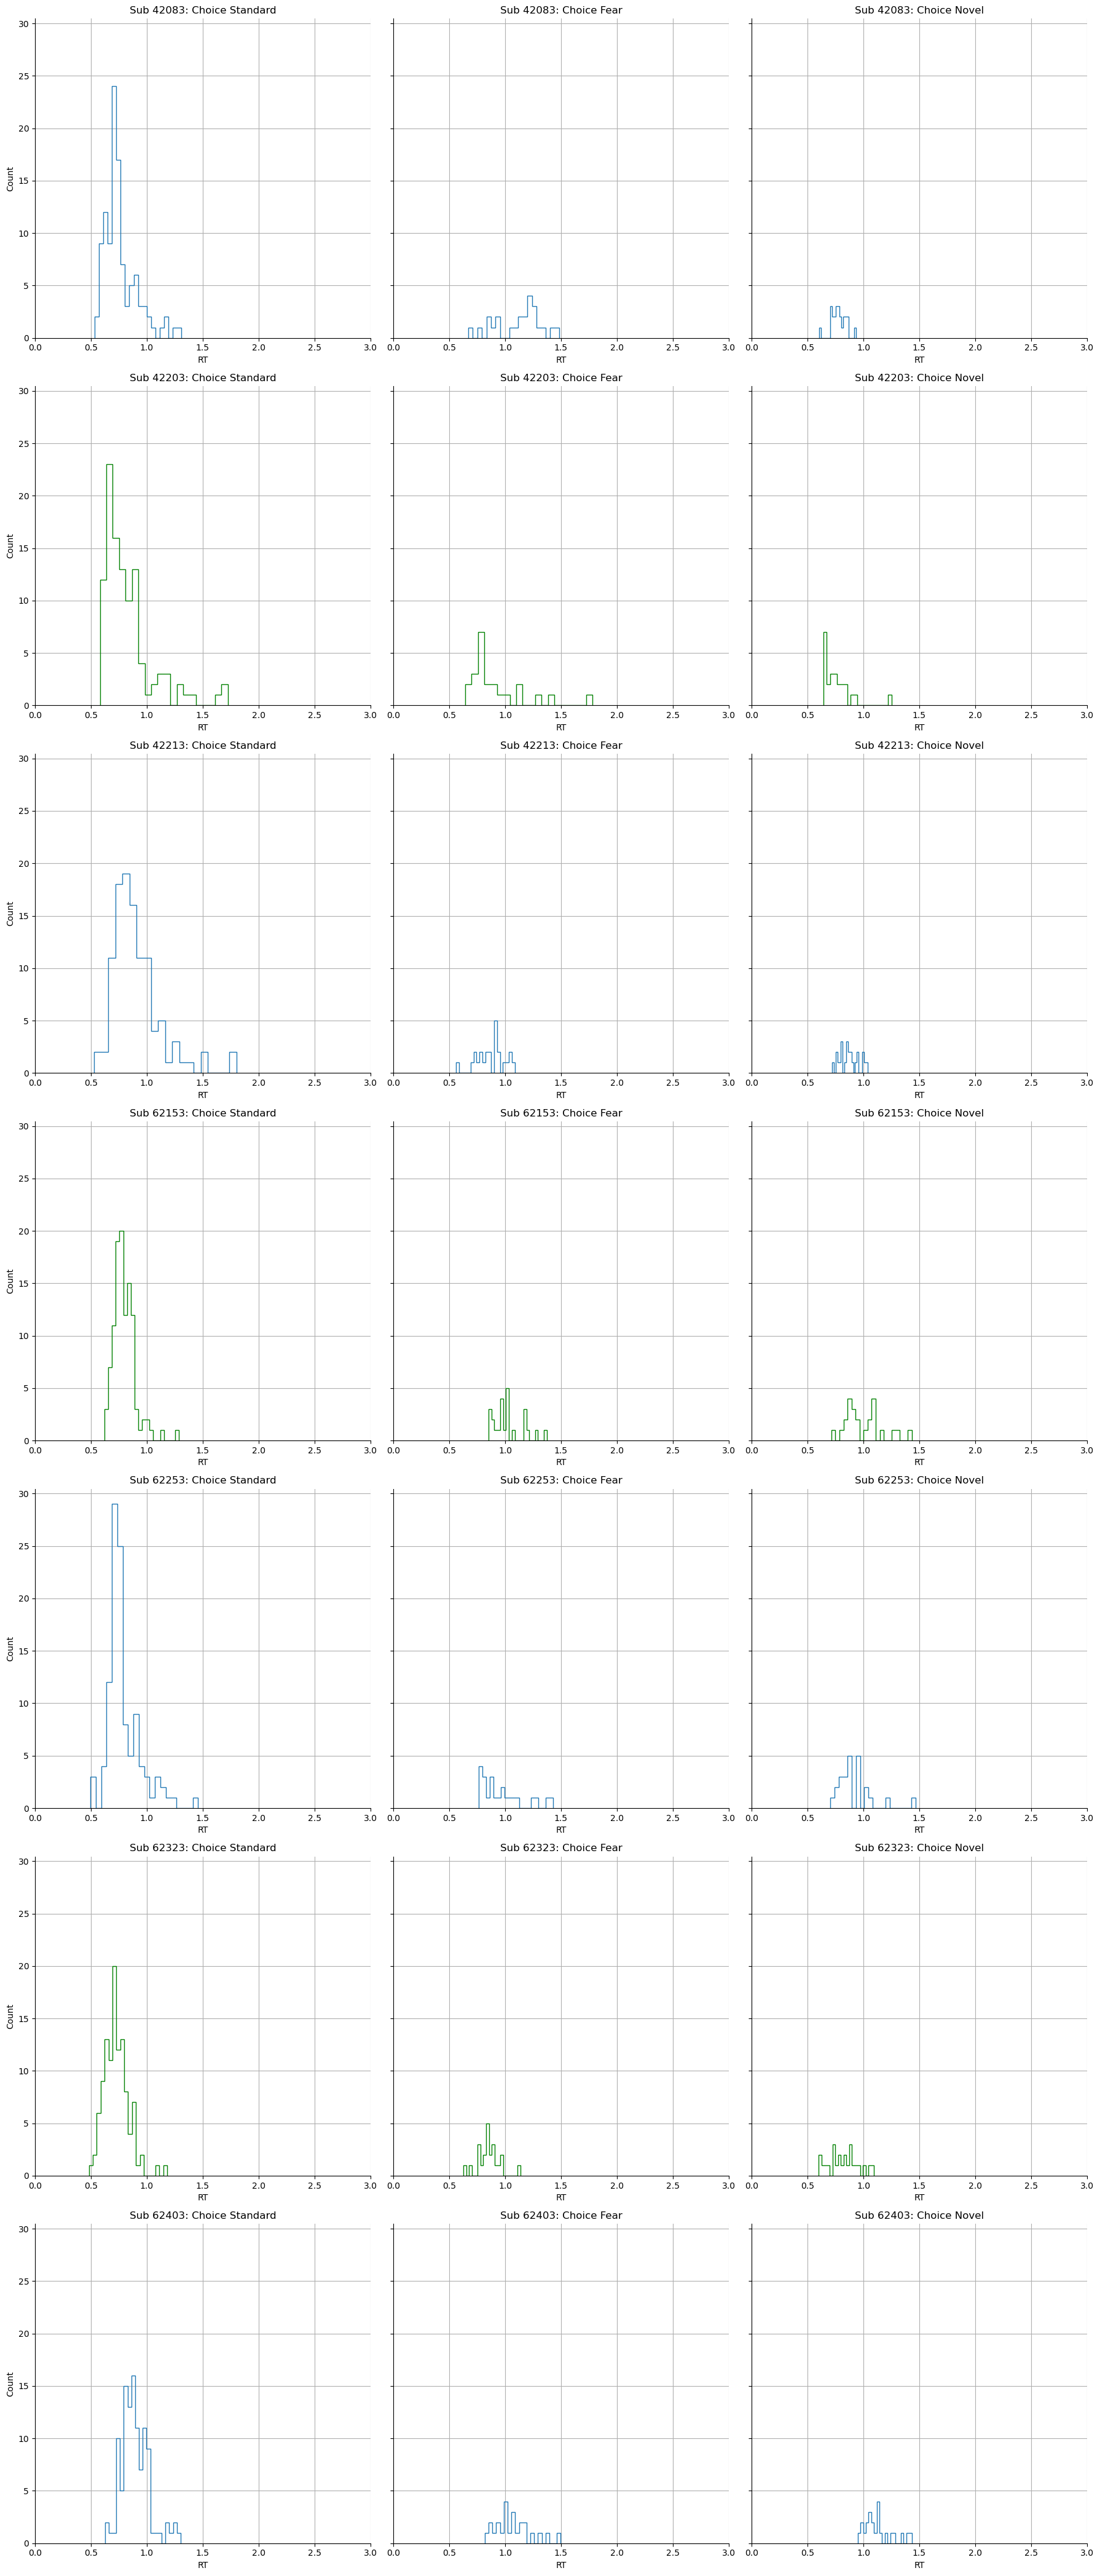

In [19]:
# List of subject IDs
subIDs = [42083, 42203, 42213, 62153, 62253, 62323, 62403]

n_subs = len(subIDs)
n_responses = 3  # 3 response types

# Create a figure with a grid of subplots, 3 columns for each response, and one row per subject
fig, axes = plt.subplots(n_subs, n_responses, figsize=(18, 6 * n_subs), sharey=True)

# Flatten the axes to make it easier to index
axes = axes.reshape(n_subs, n_responses)


for s in range(n_subs):
    subID = subIDs[s]
    print(f"Processing subject {subID}")

    # Extract data for the current subject
    subAllData = oddballDataDay2Choice[oddballDataDay2Choice.participant_id == subID]

    # Filter data for each response type
    dataResponse0 = subAllData.loc[subAllData['response'] == 0]
    dataResponse1 = subAllData.loc[subAllData['response'] == 1]
    dataResponse2 = subAllData.loc[subAllData['response'] == 2]

    trace_color = 'green' if s % 2 == 1 else None
    # Alternate row background color
    
    
    # Plot for response == 0
    for i, subj_data in dataResponse0.groupby('participant_id'):
        subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[s, 0], color=trace_color)
        axes[s, 0].set_title(f'Sub {subID}: Choice Standard')
        axes[s, 0].set_xlabel('RT')
        axes[s, 0].set_ylabel('Count')
        axes[s, 0].spines['top'].set_visible(False)
        axes[s, 0].spines['right'].set_visible(False)
        axes[s, 0].set_xlim(0, 3)

    # Plot for response == 1
    for i, subj_data in dataResponse1.groupby('participant_id'):
        subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[s, 1], color=trace_color)
        axes[s, 1].set_title(f'Sub {subID}: Choice Fear')
        axes[s, 1].set_xlabel('RT')
        axes[s, 1].spines['top'].set_visible(False)
        axes[s, 1].spines['right'].set_visible(False)
        axes[s, 1].set_xlim(0, 3)

    # Plot for response == 2
    for i, subj_data in dataResponse2.groupby('participant_id'):
        subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[s, 2], color=trace_color)
        axes[s, 2].set_title(f'Sub {subID}: Choice Novel')
        axes[s, 2].set_xlabel('RT')
        axes[s, 2].spines['top'].set_visible(False)
        axes[s, 2].spines['right'].set_visible(False)
        axes[s, 2].set_xlim(0, 3)

# Adjust layout to avoid overlapping
plt.tight_layout()

# Save the entire panel figure
plt.savefig(basepath + '/models/lba/sept24/numpyro/weirdPosteriorSubs_RT_dist_plots_combined.jpg')



# test


In [25]:
oddballDataDay2

id_runningnum  participant_id  agegrp    toi1    toi2  offset  \
0                  1           42013       1   48306   50806   -1250   
1                  1           42013       1   52293   54793   -1250   
2                  1           42013       1   54293   56793   -1250   
3                  1           42013       1   57293   59793   -1250   
4                  1           42013       1   59293   61793   -1250   
...              ...             ...     ...     ...     ...     ...   
11284             77           62433       2  463649  466149   -1250   
11285             77           62433       2  465649  468149   -1250   
11286             77           62433       2  470649  473149   -1250   
11287             77           62433       2  472649  475149   -1250   
11288             77           62433       2  475649  478149   -1250   

       trl_runningnum  event  trigger  artfree  ...  beta_insula   beta_LC  \
0                   1     70       16        1  ...    -0.010940 -0.997148   
1                   2     74       16        1  ...    -0.065556 -0.771706   
2                   3     78       16        1  ...     0.509185 -0.017799   
3                   4     82       16        1  ...     1.049503 -0.247686   
4                   5     86       16        1  ...    -0.611262  0.441441   
...               ...    ...      ...      ...  ...          ...       ...   
11284             155    657       16        1  ...    -0.901538 -1.274403   
11285             156    661       16        1  ...     0.026958 -0.852999   
11286             157    665       16        1  ...    -0.940993  1.145411   
11287             158    669       16        1  ...    -0.779456  1.448574   
11288             159    673       16        1  ...    -0.750940  0.867637   

          pupil       LCr  trl_condition_bin    switch_condition  \
0      2.175158  0.985568                  1                 NaN   
1     -0.275299  0.985568                  1       stay_standard   
2      1.874566  0.985568                  2   switch_to_oddball   
3     -0.516399  0.985568                  2        stay_oddball   
4      0.710667  0.985568                  1  switch_to_standard   
...         ...       ...                ...                 ...   
11284  0.761824  0.386572                  1       stay_standard   
11285 -0.115871  0.386572                  1       stay_standard   
11286  1.098559  0.386572                  2   switch_to_oddball   
11287 -0.044915  0.386572                  1  switch_to_standard   
11288  0.324306  0.386572                  1       stay_standard   

       switch_condition_num  logreactiontime logreactiontimez  response  
0                       NaN         0.210081         1.375260       1.0  
1                       1.0        -0.174549        -0.033526       1.0  
2                       3.0         0.289645         1.666682       1.0  
3                       2.0         0.296416         1.691481       1.0  
4                       4.0        -0.418396        -0.926666       1.0  
...                     ...              ...              ...       ...  
11284                   1.0        -0.137351        -0.110256       1.0  
11285                   1.0        -0.197492        -0.575755       1.0  
11286                   3.0         0.066526         1.467764       1.0  
11287                   4.0        -0.082262         0.316131       1.0  
11288                   1.0        -0.133665        -0.081732       1.0  

[11227 rows x 23 columns]